## Introducción
Este cuaderno se centra en el procesamiento y análisis de un conjunto de datos de melanoma. Incluye pasos para la carga de datos, preprocesamiento, entrenamiento del modelo y evaluación.

In [271]:
%matplotlib inline

# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split



In [272]:
import torch
# Configuración del dispositivo CUDA
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo configurado para usar: {device}")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.1.1+cu121
Dispositivo configurado para usar: cuda
True
NVIDIA GeForce RTX 2060


In [273]:
# consts
cats = ["MEL","NV","BCC","AK","BKL","DF","VASC","SCC","UNK"]

train_percent = .7
val_percent = .2
test_percent = .1

## Configuración
Las siguientes celdas importan las librerías necesarias y definen constantes utilizadas a lo largo del cuaderno.

In [274]:
csv = pd.read_csv("./dataset/ISIC_2019_Training_GroundTruth.csv")

print("> Cantidad de elementos", csv.count(axis=1).size )
print("> Head de los datos del csv")
print(csv.head())

> Cantidad de elementos 25331
> Head de los datos del csv
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [275]:
header = list(csv.columns)
header.remove("image")

print("> Categorias")
print(header)

> Categorias
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']


In [276]:

data = pd.DataFrame({"img":[], "cat": []}, dtype=int)
rows_list = []
for entry in csv.values:
    new_row = {"img": entry[0], "cat": np.where(entry==1.0)[0][0]-1}
    rows_list.append(new_row)

data = pd.DataFrame(rows_list)


print("> Cantidad de filas", csv.count(axis=1).size)
print("> Head de los datos en el formato que usa pytorch")
print(data.head())

> Cantidad de filas 25331
> Head de los datos en el formato que usa pytorch
            img  cat
0  ISIC_0000000    1
1  ISIC_0000001    1
2  ISIC_0000002    0
3  ISIC_0000003    1
4  ISIC_0000004    0


## Carga de Datos y Exploración Inicial
El conjunto de datos se carga desde un archivo CSV, y se realiza una exploración inicial para entender su estructura y contenidos.

In [277]:
counter = np.zeros(len(cats), dtype=int)

for elm in data.values:
    counter[int(elm[1])]+=1

print("> Cantidad de imagenes de cada tipo:")
print(counter)

> Cantidad de imagenes de cada tipo:
[ 4522 12875  3323   867  2624   239   253   628     0]


In [278]:
# counter = list(filter(lambda elm: elm > 0, counter))
# min_cat_size = min(counter)

min_cat_size = data.cat.value_counts().min()

print("> Cantidad mínima de imagenes de un tipo:")
print(min_cat_size)

> Cantidad mínima de imagenes de un tipo:
239


In [279]:
data = pd.DataFrame(data.groupby("cat").apply(lambda cat: cat.sample(min_cat_size)).reset_index(drop=True))

print("> Cantidad de elemntos:", data.count(axis=1).size )
print("> Datos equilibrados")
print(data.head())

> Cantidad de elemntos: 1912
> Datos equilibrados
            img  cat
0  ISIC_0071957    0
1  ISIC_0056092    0
2  ISIC_0070398    0
3  ISIC_0054725    0
4  ISIC_0030183    0


In [280]:
data = data.sample(frac=1)

print("> cantidad de elementos", data.count(axis=1).size)
print("> datos barajados")
print(data.head())

> cantidad de elementos 1912
> datos barajados
               img  cat
1538  ISIC_0033135    6
1889  ISIC_0058904    7
1530  ISIC_0054903    6
1846  ISIC_0069943    7
625   ISIC_0057504    2


## Preprocesamiento y Análisis de Datos
Estas celdas manejan el preprocesamiento de datos, incluyendo la limpieza, equilibrio y preparación para el aprendizaje automático.

In [281]:
counter = np.zeros(len(cats), dtype=int)

for elm in data.values:
    counter[int(elm[1])]+=1

print("> Cantidad de imagenes de cada tipo:")
print(counter)

> Cantidad de imagenes de cada tipo:
[239 239 239 239 239 239 239 239   0]


In [282]:
data.to_csv("./dataset/balanced_data.csv", index=False)

In [283]:
train_data, tmp = train_test_split(data, train_size=train_percent, stratify=data['cat'], shuffle=True)
val_data, test_data = train_test_split(tmp, test_size=test_percent/(test_percent+val_percent), stratify=tmp['cat'], shuffle=True)


print("> train", train_data.count(axis=1).size)
print(test_data.head())
print()

print("> val", val_data.count(axis=1).size)
print(val_data.head())
print()

print("> test", test_data.count(axis=1).size)
print(test_data.head())
print()

> train 1338
               img  cat
256   ISIC_0027701    1
121   ISIC_0032400    0
679   ISIC_0054873    2
1203  ISIC_0072970    5
1616  ISIC_0066097    6

> val 382
               img  cat
740   ISIC_0070014    3
913   ISIC_0063293    3
1370  ISIC_0055667    5
1822  ISIC_0071077    7
839   ISIC_0055400    3

> test 192
               img  cat
256   ISIC_0027701    1
121   ISIC_0032400    0
679   ISIC_0054873    2
1203  ISIC_0072970    5
1616  ISIC_0066097    6


In [284]:
counter = np.zeros(len(cats), dtype=int)
for elm in train_data.values:
    counter[int(elm[1])]+=1

print("> train", train_data.count(axis=1).size, train_data.count(axis=1).size/data.count(axis=1).size)
print(counter, f"({counter[0]/train_data.count(axis=1).size})")
print()

counter = np.zeros(len(cats), dtype=int)
for elm in val_data.values:
    counter[int(elm[1])]+=1

print("> val", val_data.count(axis=1).size, val_data.count(axis=1).size/data.count(axis=1).size)
print(counter, f"({counter[0]/val_data.count(axis=1).size})")
print()

counter = np.zeros(len(cats), dtype=int)
for elm in test_data.values:
    counter[int(elm[1])]+=1

print("> test", test_data.count(axis=1).size, test_data.count(axis=1).size/data.count(axis=1).size)
print(counter, f"({counter[0]/test_data.count(axis=1).size})")
print()

> train 1338 0.6997907949790795
[168 168 167 167 167 167 167 167   0] (0.12556053811659193)

> val 382 0.1997907949790795
[47 47 48 48 48 48 48 48  0] (0.12303664921465969)

> test 192 0.100418410041841
[24 24 24 24 24 24 24 24  0] (0.125)


## División de Datos para el Entrenamiento del Modelo
El conjunto de datos se divide en conjuntos de entrenamiento, validación y prueba para prepararse para el entrenamiento del modelo.

In [285]:
train_data.to_csv("dataset/train_data.csv", index=False)
val_data.to_csv("dataset/val_data.csv", index=False)
test_data.to_csv("dataset/test_data.csv", index=False)

# creacion de un dataset personalizado

In [286]:

from torch.utils.data import  Dataset
image_dir = "C:/Users/elena/Desktop/universidad/3º año/FSI/pythorch/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
       

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx]['img'] + ".jpg")
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx]['cat']
        if self.transform:
            image = self.transform(image)
        return image, label

In [287]:

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
# Carga el conjunto de datos de entrenamiento sin ninguna normalización para calcular la media y la desviación estándar
unnormalized_transform = transforms.Compose([
    transforms.Resize((150, 150)), 
    transforms.ToTensor()
])
unnormalized_dataset = CustomDataset(data, image_dir, transform=unnormalized_transform)
loader = DataLoader(unnormalized_dataset, batch_size=64, shuffle=False)

# Calcular la media y la desviación estándar
mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)
n_samples = 0

for images, _ in loader:
    mean = images.mean(dim=(0, 2, 3))
    std = images.std(dim=(0, 2, 3))
    mean_sum += mean
    std_sum += std
    n_samples += images.size(0)


mean = mean_sum / n_samples
std = std_sum / n_samples

# Transformaciones para el conjunto de entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),             
    transforms.RandomRotation(180),            
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para el conjunto de validación y test (sin data augmentation)
test_valid_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_data,image_dir, transform=train_transform)
val_dataset = CustomDataset(val_data,image_dir, transform=test_valid_transforms)
test_dataset = CustomDataset(test_data, image_dir,transform=test_valid_transforms)

# comprobaciones
sample_dataset = CustomDataset(train_data, image_dir, transform=train_transform)

# Acceder e imprimir las primeras 5 muestras del dataset
for i in range(5):
    image, label = sample_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")

# Imprimir los valores de la media y la desviación estándar
print(f"Media: {mean}, Desviación Estándar: {std}")



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar DataLoader
for images, labels in train_loader:
    print(f"Batch de imágenes: {images.shape}, Batch de etiquetas: {labels.shape}")
    break 

Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 150, 150]), Etiqueta - 0
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 150, 150]), Etiqueta - 5
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 150, 150]), Etiqueta - 5
Muestra 3: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 150, 150]), Etiqueta - 0
Muestra 4: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 150, 150]), Etiqueta - 4
Media: tensor([0.0102, 0.0082, 0.0083]), Desviación Estándar: tensor([0.0036, 0.0033, 0.0034])
Batch de imágenes: torch.Size([32, 3, 150, 150]), Batch de etiquetas: torch.Size([32])


In [288]:
# imports
import torch.nn as nn
import torch.nn.functional as F


## Red Neuronal simple 

In [289]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Capa Dropout 
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)

        # Capas Fully connected 
        # ajustado para 150x150
        self.fc1 = nn.Linear(in_features=128 * 18 * 18, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=8)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))


        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout25(x)

   
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout25(x)

       
        x = x.view(-1, 128 *18 * 18)

        x = F.relu(self.fc1(x))
        x = self.dropout50(x)

        x = self.fc2(x)
        return x


model = CNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=41472, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)


## Preparación del Modelo
Esta sección prepara el modelo de red neuronal usando PyTorch, incluyendo la definición de la arquitectura del modelo y los cargadores de datos.

In [290]:
def plot_loss(history):
    plt.plot(history)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

## Funciones de Entrenamiento y Evaluación
Aquí se definen las funciones para entrenar el modelo y evaluar su rendimiento.

In [291]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from datetime import datetime

def eval(model, test_loader, device):
    model.eval()

    total = 0
    correct = 0

    pred = []
    real = []

    with torch.no_grad():
        for imgs, cats in test_loader:
            imgs, cats = imgs.to(device), cats.to(device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)

            pred.extend(predicted.cpu().numpy())  # Convertir a NumPy array
            real.extend(cats.cpu().numpy())       # Convertir a NumPy array

            total += cats.size(0)
            correct += (predicted == cats).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on images: {accuracy:.2f}%')

    # Imprime el informe de clasificación
    print("Classification Report:")
    print(classification_report(real, pred))

    # Genera y muestra la matriz de confusión
    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [292]:
def train_loop(model, train_loader, optimizer, criterion, num_epochs, device, history=[]):
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        start_time = datetime.now()
        running_loss = 0

        for i, (imgs, cats) in enumerate(train_loader, 1):
            model.train()
            imgs, cats = imgs.to(device), cats.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, cats)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if not i % 10:
                print(f"Epoch {epoch}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss: {running_loss/10:.4f}")
                running_loss = 0.0

        #CAalcula la validacion y las metricas por cada epoca
        eval(model, val_loader, device) 

        elapsed_time = datetime.now() - start_time
        print(f"Time elapsed for epoch {epoch}: {elapsed_time}")

    print("Finished training")

## Utilidades Adicionales
Funciones de utilidad adicionales, como la detención temprana, se definen en esta sección.

In [293]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=10, min_delta=0.01)


Epoch 1/200, Batch 10/42, Loss: 2.2860
Epoch 1/200, Batch 20/42, Loss: 2.0827
Epoch 1/200, Batch 30/42, Loss: 2.0797
Epoch 1/200, Batch 40/42, Loss: 2.0586
Accuracy on images: 20.94%
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.09      0.12        47
           1       0.33      0.60      0.42        47
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        48
           5       0.17      0.90      0.28        48
           6       0.28      0.10      0.15        48
           7       0.00      0.00      0.00        48

    accuracy                           0.21       382
   macro avg       0.12      0.21      0.12       382
weighted avg       0.12      0.21      0.12       382


C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

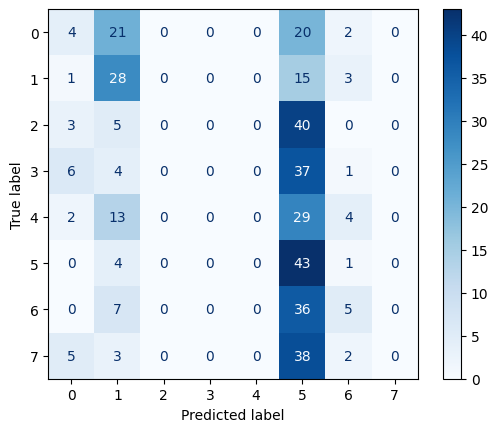

Time elapsed for epoch 1: 0:00:18.166110
Epoch 2/200, Batch 10/42, Loss: 1.9921
Epoch 2/200, Batch 20/42, Loss: 2.0215
Epoch 2/200, Batch 30/42, Loss: 1.9825
Epoch 2/200, Batch 40/42, Loss: 1.9278
Accuracy on images: 24.87%
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.26      0.28        47
           1       0.37      0.53      0.43        47
           2       0.00      0.00      0.00        48
           3       0.30      0.35      0.33        48
           4       0.00      0.00      0.00        48
           5       0.10      0.04      0.06        48
           6       0.20      0.79      0.32        48
           7       1.00      0.02      0.04        48

    accuracy                           0.25       382
   macro avg       0.29      0.25      0.18       382
weighted avg       0.28      0.25      0.18       382


C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

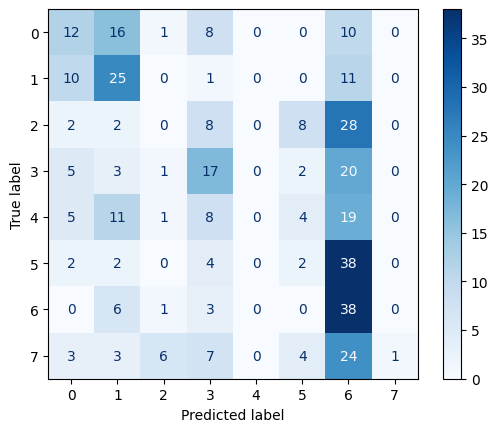

Time elapsed for epoch 2: 0:00:18.141103
Epoch 3/200, Batch 10/42, Loss: 1.9146
Epoch 3/200, Batch 20/42, Loss: 1.9097
Epoch 3/200, Batch 30/42, Loss: 1.8650
Epoch 3/200, Batch 40/42, Loss: 1.8060
Accuracy on images: 35.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.23      0.29        47
           1       0.43      0.68      0.52        47
           2       0.00      0.00      0.00        48
           3       0.28      0.50      0.36        48
           4       0.00      0.00      0.00        48
           5       0.23      0.58      0.33        48
           6       0.57      0.77      0.65        48
           7       0.44      0.08      0.14        48

    accuracy                           0.36       382
   macro avg       0.29      0.36      0.29       382
weighted avg       0.29      0.36      0.29       382


C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

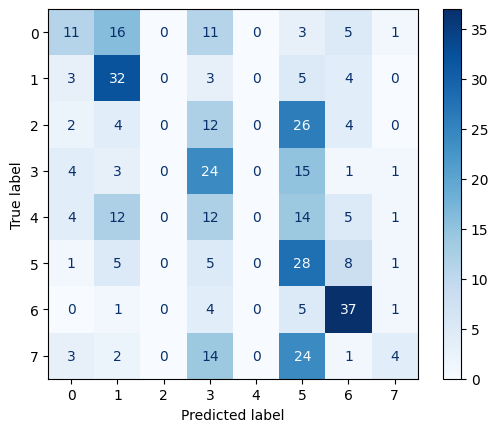

Time elapsed for epoch 3: 0:00:18.197117
Epoch 4/200, Batch 10/42, Loss: 1.8315
Epoch 4/200, Batch 20/42, Loss: 1.8444
Epoch 4/200, Batch 30/42, Loss: 1.8227
Epoch 4/200, Batch 40/42, Loss: 1.8072
Accuracy on images: 34.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.51      0.41        47
           1       0.35      0.53      0.42        47
           2       0.00      0.00      0.00        48
           3       0.25      0.54      0.34        48
           4       0.00      0.00      0.00        48
           5       0.24      0.27      0.25        48
           6       0.57      0.75      0.65        48
           7       0.40      0.12      0.19        48

    accuracy                           0.34       382
   macro avg       0.27      0.34      0.28       382
weighted avg       0.27      0.34      0.28       382


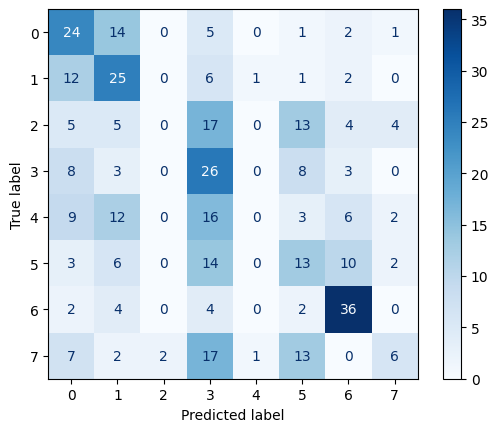

Time elapsed for epoch 4: 0:00:18.539195
Epoch 5/200, Batch 10/42, Loss: 1.7507
Epoch 5/200, Batch 20/42, Loss: 1.8082
Epoch 5/200, Batch 30/42, Loss: 1.8363
Epoch 5/200, Batch 40/42, Loss: 1.8140
Accuracy on images: 36.39%
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.40      0.37        47
           1       0.45      0.53      0.49        47
           2       0.00      0.00      0.00        48
           3       0.30      0.46      0.36        48
           4       0.00      0.00      0.00        48
           5       0.27      0.58      0.37        48
           6       0.52      0.85      0.65        48
           7       0.50      0.08      0.14        48

    accuracy                           0.36       382
   macro avg       0.30      0.36      0.30       382
weighted avg       0.30      0.36      0.30       382


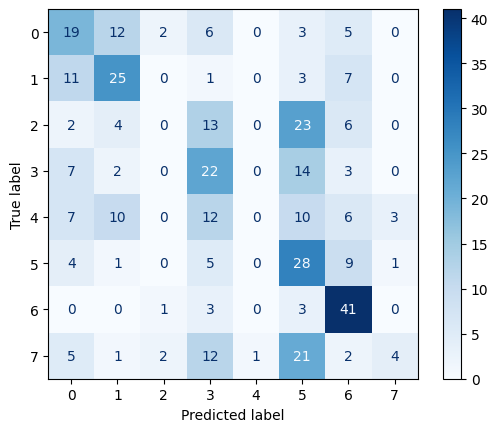

Time elapsed for epoch 5: 0:00:18.460176
Epoch 6/200, Batch 10/42, Loss: 1.7754
Epoch 6/200, Batch 20/42, Loss: 1.7942
Epoch 6/200, Batch 30/42, Loss: 1.8001
Epoch 6/200, Batch 40/42, Loss: 1.7642
Accuracy on images: 35.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.60      0.36        47
           1       0.37      0.43      0.40        47
           2       0.50      0.02      0.04        48
           3       0.31      0.54      0.39        48
           4       0.00      0.00      0.00        48
           5       0.32      0.50      0.39        48
           6       0.71      0.73      0.72        48
           7       0.12      0.02      0.04        48

    accuracy                           0.35       382
   macro avg       0.32      0.35      0.29       382
weighted avg       0.32      0.35      0.29       382


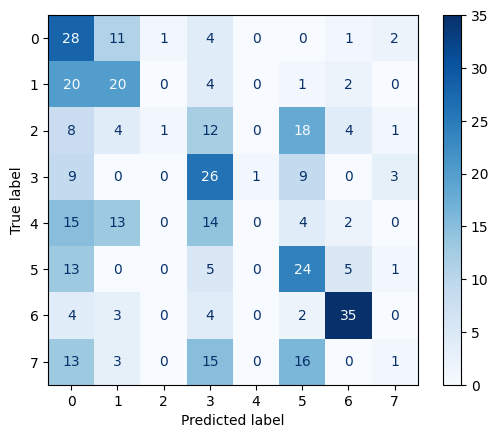

Time elapsed for epoch 6: 0:00:18.161110
Epoch 7/200, Batch 10/42, Loss: 1.7512
Epoch 7/200, Batch 20/42, Loss: 1.8017
Epoch 7/200, Batch 30/42, Loss: 1.7238
Epoch 7/200, Batch 40/42, Loss: 1.7736
Accuracy on images: 39.79%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43        47
           1       0.51      0.68      0.58        47
           2       0.17      0.02      0.04        48
           3       0.30      0.58      0.39        48
           4       0.00      0.00      0.00        48
           5       0.34      0.44      0.39        48
           6       0.54      0.83      0.66        48
           7       0.34      0.23      0.27        48

    accuracy                           0.40       382
   macro avg       0.33      0.40      0.34       382
weighted avg       0.33      0.40      0.34       382


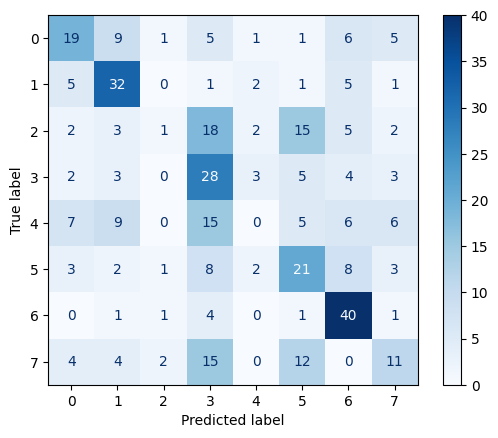

Time elapsed for epoch 7: 0:00:18.323145
Epoch 8/200, Batch 10/42, Loss: 1.7328
Epoch 8/200, Batch 20/42, Loss: 1.7240
Epoch 8/200, Batch 30/42, Loss: 1.7092
Epoch 8/200, Batch 40/42, Loss: 1.7253
Accuracy on images: 37.17%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43        47
           1       0.42      0.77      0.55        47
           2       0.22      0.10      0.14        48
           3       0.25      0.40      0.31        48
           4       0.12      0.04      0.06        48
           5       0.30      0.12      0.18        48
           6       0.66      0.73      0.69        48
           7       0.30      0.42      0.35        48

    accuracy                           0.37       382
   macro avg       0.34      0.37      0.34       382
weighted avg       0.34      0.37      0.34       382


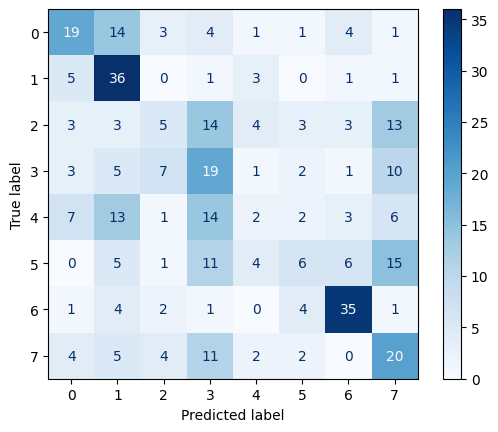

Time elapsed for epoch 8: 0:00:18.595208
Epoch 9/200, Batch 10/42, Loss: 1.7453
Epoch 9/200, Batch 20/42, Loss: 1.6651
Epoch 9/200, Batch 30/42, Loss: 1.7626
Epoch 9/200, Batch 40/42, Loss: 1.7688
Accuracy on images: 37.17%
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.53      0.39        47
           1       0.43      0.57      0.49        47
           2       0.27      0.06      0.10        48
           3       0.29      0.38      0.32        48
           4       0.22      0.04      0.07        48
           5       0.33      0.42      0.37        48
           6       0.67      0.73      0.70        48
           7       0.29      0.25      0.27        48

    accuracy                           0.37       382
   macro avg       0.35      0.37      0.34       382
weighted avg       0.35      0.37      0.34       382


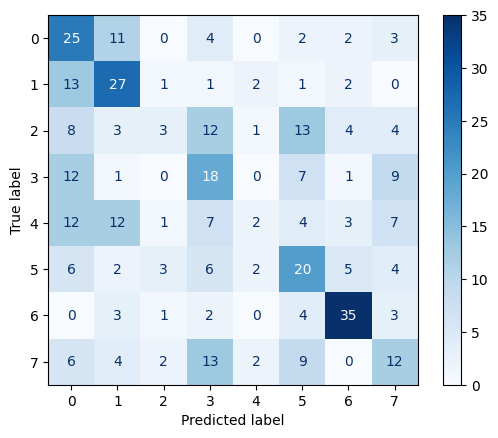

Time elapsed for epoch 9: 0:00:18.285136
Epoch 10/200, Batch 10/42, Loss: 1.6673
Epoch 10/200, Batch 20/42, Loss: 1.7139
Epoch 10/200, Batch 30/42, Loss: 1.7417
Epoch 10/200, Batch 40/42, Loss: 1.7871
Accuracy on images: 39.27%
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.47      0.42        47
           1       0.48      0.62      0.54        47
           2       0.25      0.04      0.07        48
           3       0.30      0.38      0.33        48
           4       0.25      0.06      0.10        48
           5       0.29      0.60      0.39        48
           6       0.71      0.71      0.71        48
           7       0.35      0.27      0.31        48

    accuracy                           0.39       382
   macro avg       0.38      0.39      0.36       382
weighted avg       0.38      0.39      0.36       382


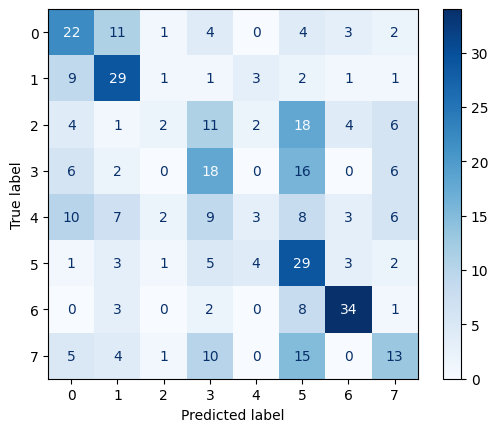

Time elapsed for epoch 10: 0:00:18.608209
Epoch 11/200, Batch 10/42, Loss: 1.6770
Epoch 11/200, Batch 20/42, Loss: 1.7296
Epoch 11/200, Batch 30/42, Loss: 1.7283
Epoch 11/200, Batch 40/42, Loss: 1.6703
Accuracy on images: 38.48%
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.45      0.40        47
           1       0.48      0.66      0.55        47
           2       0.44      0.08      0.14        48
           3       0.28      0.52      0.36        48
           4       0.13      0.06      0.08        48
           5       0.35      0.46      0.40        48
           6       0.75      0.62      0.68        48
           7       0.32      0.23      0.27        48

    accuracy                           0.38       382
   macro avg       0.39      0.39      0.36       382
weighted avg       0.39      0.38      0.36       382


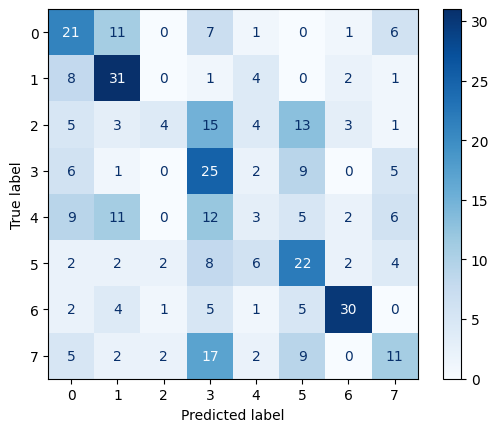

Time elapsed for epoch 11: 0:00:18.254131
Epoch 12/200, Batch 10/42, Loss: 1.6381
Epoch 12/200, Batch 20/42, Loss: 1.7018
Epoch 12/200, Batch 30/42, Loss: 1.6991
Epoch 12/200, Batch 40/42, Loss: 1.6546
Accuracy on images: 38.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.49      0.43        47
           1       0.45      0.72      0.55        47
           2       0.33      0.27      0.30        48
           3       0.32      0.23      0.27        48
           4       0.00      0.00      0.00        48
           5       0.29      0.54      0.38        48
           6       0.73      0.67      0.70        48
           7       0.21      0.15      0.17        48

    accuracy                           0.38       382
   macro avg       0.34      0.38      0.35       382
weighted avg       0.34      0.38      0.35       382


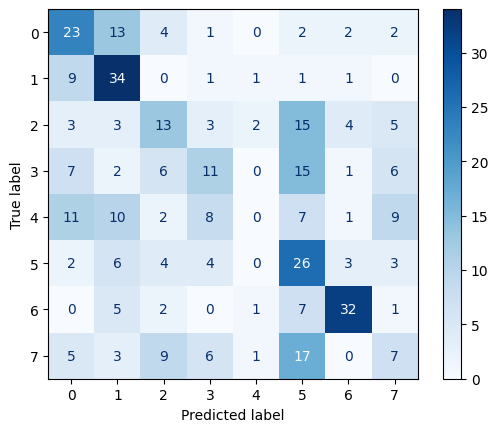

Time elapsed for epoch 12: 0:00:18.680760
Epoch 13/200, Batch 10/42, Loss: 1.6974
Epoch 13/200, Batch 20/42, Loss: 1.7066
Epoch 13/200, Batch 30/42, Loss: 1.6474
Epoch 13/200, Batch 40/42, Loss: 1.6464
Accuracy on images: 38.74%
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.64      0.43        47
           1       0.52      0.72      0.61        47
           2       0.21      0.21      0.21        48
           3       0.34      0.42      0.37        48
           4       0.17      0.02      0.04        48
           5       0.38      0.29      0.33        48
           6       0.75      0.69      0.72        48
           7       0.19      0.12      0.15        48

    accuracy                           0.39       382
   macro avg       0.36      0.39      0.36       382
weighted avg       0.36      0.39      0.36       382


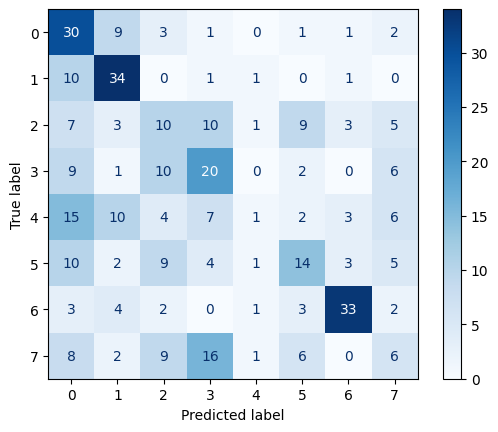

Time elapsed for epoch 13: 0:00:18.858267
Epoch 14/200, Batch 10/42, Loss: 1.7425
Epoch 14/200, Batch 20/42, Loss: 1.7040
Epoch 14/200, Batch 30/42, Loss: 1.7192
Epoch 14/200, Batch 40/42, Loss: 1.5737
Accuracy on images: 37.43%
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.51      0.42        47
           1       0.42      0.64      0.50        47
           2       0.25      0.08      0.12        48
           3       0.29      0.50      0.37        48
           4       0.14      0.04      0.06        48
           5       0.38      0.12      0.19        48
           6       0.65      0.81      0.72        48
           7       0.25      0.29      0.27        48

    accuracy                           0.37       382
   macro avg       0.34      0.38      0.33       382
weighted avg       0.34      0.37      0.33       382


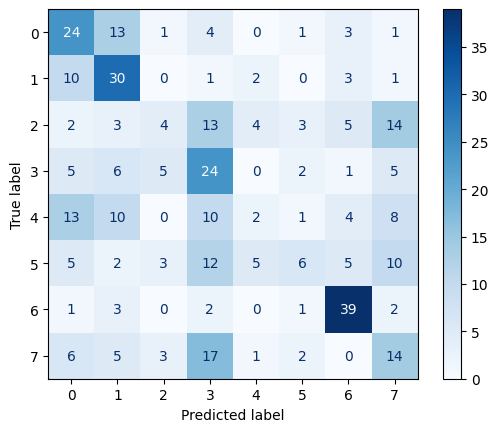

Time elapsed for epoch 14: 0:00:18.402163
Epoch 15/200, Batch 10/42, Loss: 1.6433
Epoch 15/200, Batch 20/42, Loss: 1.6994
Epoch 15/200, Batch 30/42, Loss: 1.7035
Epoch 15/200, Batch 40/42, Loss: 1.6376
Accuracy on images: 40.84%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.47      0.45        47
           1       0.46      0.70      0.56        47
           2       0.38      0.25      0.30        48
           3       0.31      0.48      0.38        48
           4       0.12      0.04      0.06        48
           5       0.30      0.40      0.34        48
           6       0.71      0.88      0.79        48
           7       0.19      0.06      0.09        48

    accuracy                           0.41       382
   macro avg       0.36      0.41      0.37       382
weighted avg       0.36      0.41      0.37       382


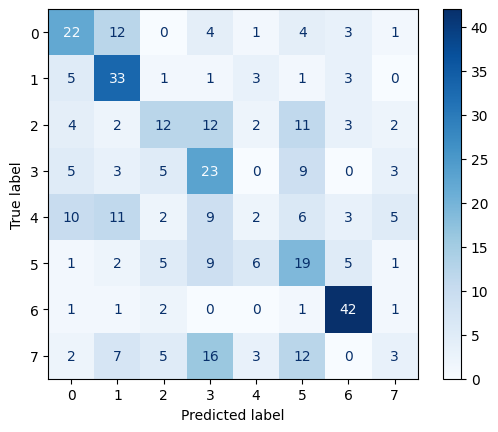

Time elapsed for epoch 15: 0:00:18.304142
Epoch 16/200, Batch 10/42, Loss: 1.6066
Epoch 16/200, Batch 20/42, Loss: 1.6906
Epoch 16/200, Batch 30/42, Loss: 1.6565
Epoch 16/200, Batch 40/42, Loss: 1.7875
Accuracy on images: 38.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.53      0.44        47
           1       0.43      0.70      0.53        47
           2       0.22      0.08      0.12        48
           3       0.26      0.52      0.34        48
           4       0.09      0.02      0.03        48
           5       0.35      0.29      0.32        48
           6       0.78      0.73      0.75        48
           7       0.33      0.19      0.24        48

    accuracy                           0.38       382
   macro avg       0.35      0.38      0.35       382
weighted avg       0.35      0.38      0.35       382


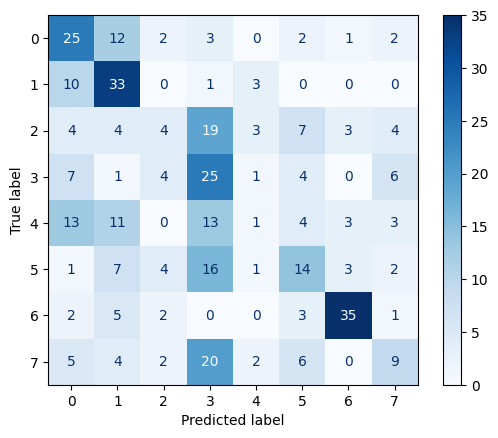

Time elapsed for epoch 16: 0:00:18.107096
Epoch 17/200, Batch 10/42, Loss: 1.6714
Epoch 17/200, Batch 20/42, Loss: 1.6598
Epoch 17/200, Batch 30/42, Loss: 1.6053
Epoch 17/200, Batch 40/42, Loss: 1.5607
Accuracy on images: 38.48%
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.53      0.45        47
           1       0.57      0.60      0.58        47
           2       0.27      0.17      0.21        48
           3       0.32      0.35      0.34        48
           4       0.07      0.02      0.03        48
           5       0.28      0.50      0.36        48
           6       0.65      0.73      0.69        48
           7       0.29      0.19      0.23        48

    accuracy                           0.38       382
   macro avg       0.35      0.39      0.36       382
weighted avg       0.35      0.38      0.36       382


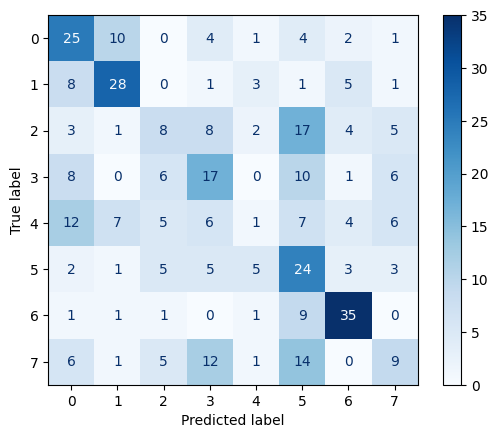

Time elapsed for epoch 17: 0:00:18.489183
Epoch 18/200, Batch 10/42, Loss: 1.6062
Epoch 18/200, Batch 20/42, Loss: 1.6628
Epoch 18/200, Batch 30/42, Loss: 1.6215
Epoch 18/200, Batch 40/42, Loss: 1.5896
Accuracy on images: 40.05%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.46        47
           1       0.55      0.66      0.60        47
           2       0.27      0.15      0.19        48
           3       0.28      0.33      0.30        48
           4       0.27      0.06      0.10        48
           5       0.29      0.54      0.38        48
           6       0.68      0.83      0.75        48
           7       0.23      0.17      0.19        48

    accuracy                           0.40       382
   macro avg       0.38      0.40      0.37       382
weighted avg       0.38      0.40      0.37       382


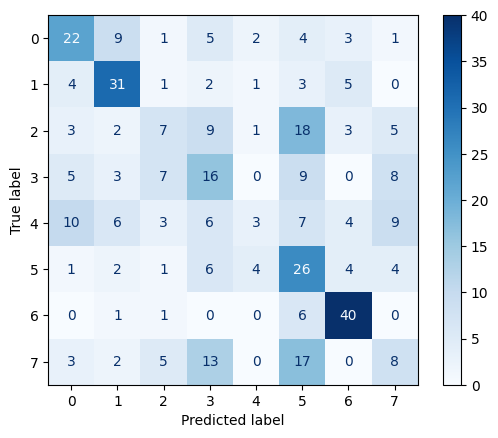

Time elapsed for epoch 18: 0:00:18.153108
Epoch 19/200, Batch 10/42, Loss: 1.6468
Epoch 19/200, Batch 20/42, Loss: 1.6357
Epoch 19/200, Batch 30/42, Loss: 1.6550
Epoch 19/200, Batch 40/42, Loss: 1.6532
Accuracy on images: 37.96%
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.53      0.43        47
           1       0.43      0.70      0.54        47
           2       0.25      0.06      0.10        48
           3       0.32      0.40      0.36        48
           4       0.18      0.06      0.09        48
           5       0.37      0.40      0.38        48
           6       0.82      0.65      0.72        48
           7       0.21      0.25      0.23        48

    accuracy                           0.38       382
   macro avg       0.37      0.38      0.35       382
weighted avg       0.37      0.38      0.35       382


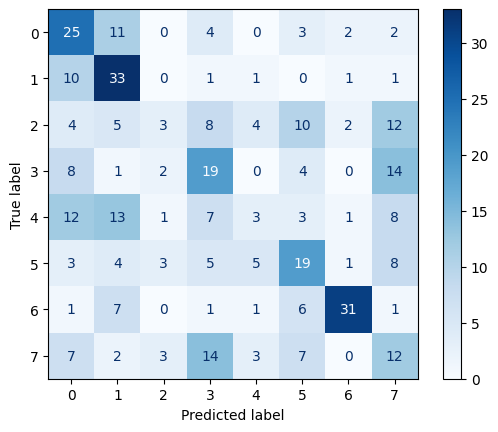

Time elapsed for epoch 19: 0:00:18.713233
Epoch 20/200, Batch 10/42, Loss: 1.5690
Epoch 20/200, Batch 20/42, Loss: 1.6330
Epoch 20/200, Batch 30/42, Loss: 1.6278
Epoch 20/200, Batch 40/42, Loss: 1.6036
Accuracy on images: 38.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.47      0.44        47
           1       0.53      0.70      0.61        47
           2       0.12      0.06      0.08        48
           3       0.26      0.21      0.23        48
           4       0.15      0.04      0.07        48
           5       0.28      0.52      0.36        48
           6       0.65      0.83      0.73        48
           7       0.28      0.23      0.25        48

    accuracy                           0.38       382
   macro avg       0.34      0.38      0.35       382
weighted avg       0.34      0.38      0.34       382


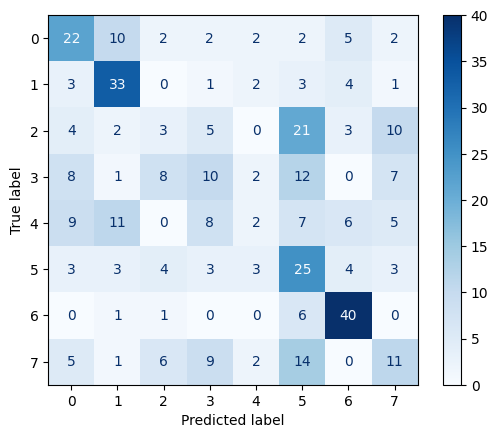

Time elapsed for epoch 20: 0:00:18.694229
Epoch 21/200, Batch 10/42, Loss: 1.5863
Epoch 21/200, Batch 20/42, Loss: 1.5981
Epoch 21/200, Batch 30/42, Loss: 1.6171
Epoch 21/200, Batch 40/42, Loss: 1.5896
Accuracy on images: 36.39%
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.53      0.42        47
           1       0.44      0.72      0.55        47
           2       0.17      0.06      0.09        48
           3       0.29      0.33      0.31        48
           4       0.18      0.04      0.07        48
           5       0.25      0.38      0.30        48
           6       0.80      0.67      0.73        48
           7       0.24      0.19      0.21        48

    accuracy                           0.36       382
   macro avg       0.34      0.37      0.33       382
weighted avg       0.34      0.36      0.33       382


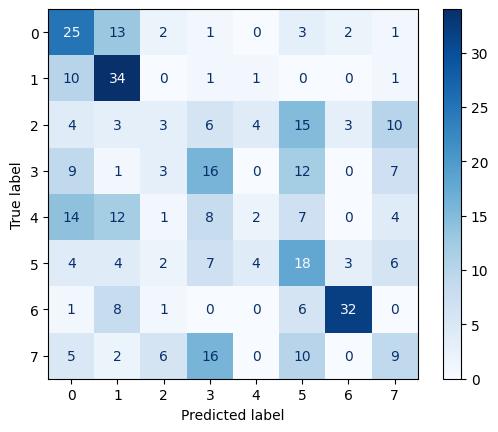

Time elapsed for epoch 21: 0:00:18.169111
Epoch 22/200, Batch 10/42, Loss: 1.5248
Epoch 22/200, Batch 20/42, Loss: 1.5647
Epoch 22/200, Batch 30/42, Loss: 1.6203
Epoch 22/200, Batch 40/42, Loss: 1.6130
Accuracy on images: 41.62%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        47
           1       0.48      0.85      0.61        47
           2       0.29      0.50      0.37        48
           3       0.27      0.35      0.31        48
           4       0.20      0.04      0.07        48
           5       0.48      0.27      0.35        48
           6       0.73      0.79      0.76        48
           7       0.28      0.10      0.15        48

    accuracy                           0.42       382
   macro avg       0.40      0.42      0.38       382
weighted avg       0.40      0.42      0.38       382


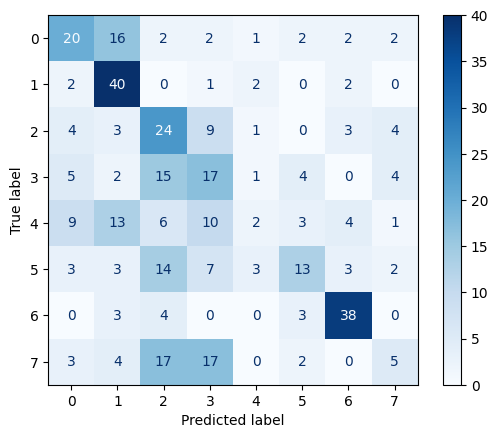

Time elapsed for epoch 22: 0:00:18.141104
Epoch 23/200, Batch 10/42, Loss: 1.6446
Epoch 23/200, Batch 20/42, Loss: 1.5345
Epoch 23/200, Batch 30/42, Loss: 1.5906
Epoch 23/200, Batch 40/42, Loss: 1.5835
Accuracy on images: 42.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        47
           1       0.51      0.77      0.61        47
           2       0.35      0.33      0.34        48
           3       0.37      0.40      0.38        48
           4       0.07      0.02      0.03        48
           5       0.38      0.25      0.30        48
           6       0.67      0.94      0.78        48
           7       0.28      0.27      0.27        48

    accuracy                           0.43       382
   macro avg       0.38      0.43      0.39       382
weighted avg       0.38      0.43      0.39       382


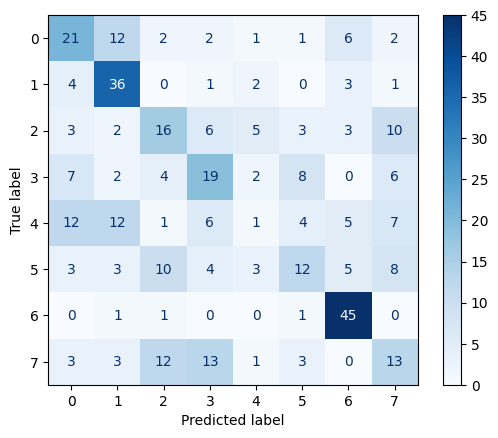

Time elapsed for epoch 23: 0:00:18.613211
Epoch 24/200, Batch 10/42, Loss: 1.5163
Epoch 24/200, Batch 20/42, Loss: 1.6201
Epoch 24/200, Batch 30/42, Loss: 1.5277
Epoch 24/200, Batch 40/42, Loss: 1.6522
Accuracy on images: 37.43%
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.53      0.45        47
           1       0.47      0.74      0.57        47
           2       0.26      0.25      0.25        48
           3       0.20      0.19      0.19        48
           4       0.18      0.04      0.07        48
           5       0.28      0.40      0.33        48
           6       0.79      0.71      0.75        48
           7       0.25      0.15      0.18        48

    accuracy                           0.37       382
   macro avg       0.35      0.38      0.35       382
weighted avg       0.35      0.37      0.35       382


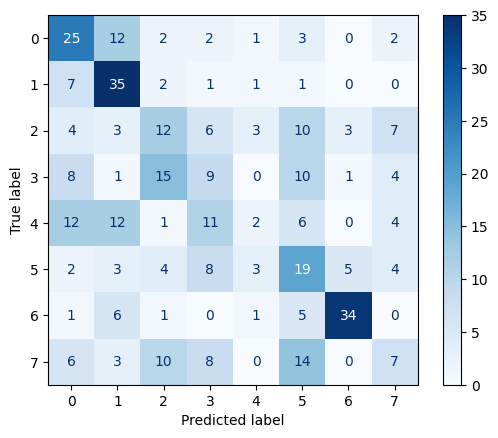

Time elapsed for epoch 24: 0:00:18.537194
Epoch 25/200, Batch 10/42, Loss: 1.6196
Epoch 25/200, Batch 20/42, Loss: 1.6163
Epoch 25/200, Batch 30/42, Loss: 1.5402
Epoch 25/200, Batch 40/42, Loss: 1.5078
Accuracy on images: 38.74%
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47        47
           1       0.44      0.72      0.54        47
           2       0.30      0.29      0.29        48
           3       0.37      0.31      0.34        48
           4       0.17      0.06      0.09        48
           5       0.34      0.27      0.30        48
           6       0.83      0.62      0.71        48
           7       0.21      0.23      0.22        48

    accuracy                           0.39       382
   macro avg       0.38      0.39      0.37       382
weighted avg       0.38      0.39      0.37       382


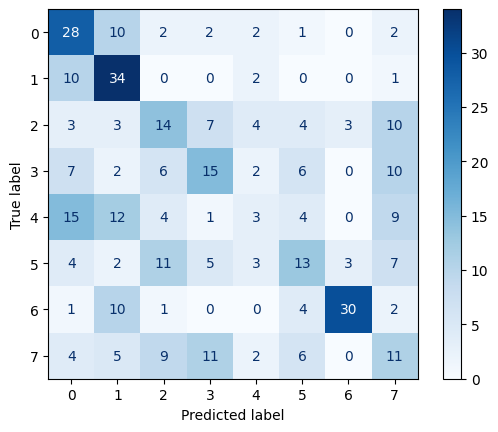

Time elapsed for epoch 25: 0:00:18.179113
Epoch 26/200, Batch 10/42, Loss: 1.5126
Epoch 26/200, Batch 20/42, Loss: 1.5639
Epoch 26/200, Batch 30/42, Loss: 1.6065
Epoch 26/200, Batch 40/42, Loss: 1.5551
Accuracy on images: 42.15%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.57      0.51        47
           1       0.48      0.66      0.55        47
           2       0.33      0.38      0.35        48
           3       0.33      0.46      0.38        48
           4       0.28      0.10      0.15        48
           5       0.34      0.33      0.34        48
           6       0.78      0.73      0.75        48
           7       0.25      0.15      0.18        48

    accuracy                           0.42       382
   macro avg       0.41      0.42      0.40       382
weighted avg       0.41      0.42      0.40       382


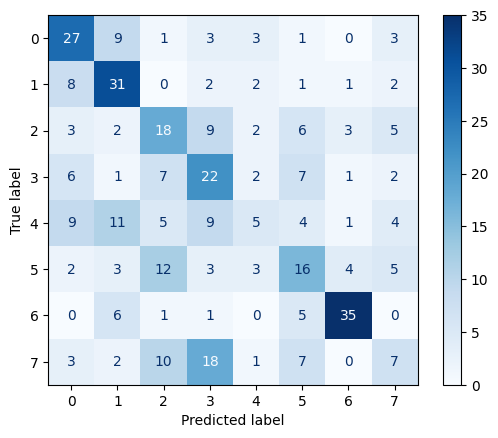

Time elapsed for epoch 26: 0:00:17.903051
Epoch 27/200, Batch 10/42, Loss: 1.4641
Epoch 27/200, Batch 20/42, Loss: 1.4974
Epoch 27/200, Batch 30/42, Loss: 1.5235
Epoch 27/200, Batch 40/42, Loss: 1.5671
Accuracy on images: 40.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.51      0.48        47
           1       0.48      0.68      0.56        47
           2       0.36      0.42      0.39        48
           3       0.23      0.29      0.26        48
           4       0.33      0.17      0.22        48
           5       0.38      0.31      0.34        48
           6       0.86      0.75      0.80        48
           7       0.12      0.10      0.11        48

    accuracy                           0.40       382
   macro avg       0.40      0.40      0.40       382
weighted avg       0.40      0.40      0.40       382


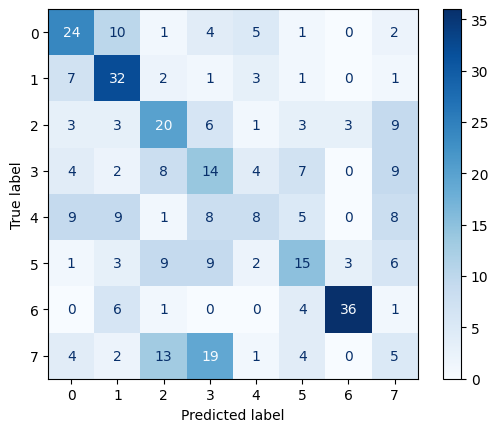

Time elapsed for epoch 27: 0:00:18.020078
Epoch 28/200, Batch 10/42, Loss: 1.4898
Epoch 28/200, Batch 20/42, Loss: 1.5688
Epoch 28/200, Batch 30/42, Loss: 1.5473
Epoch 28/200, Batch 40/42, Loss: 1.5249
Accuracy on images: 35.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.51      0.41        47
           1       0.45      0.57      0.50        47
           2       0.41      0.33      0.37        48
           3       0.25      0.31      0.28        48
           4       0.15      0.04      0.07        48
           5       0.33      0.35      0.34        48
           6       0.70      0.54      0.61        48
           7       0.20      0.21      0.20        48

    accuracy                           0.36       382
   macro avg       0.35      0.36      0.35       382
weighted avg       0.35      0.36      0.35       382


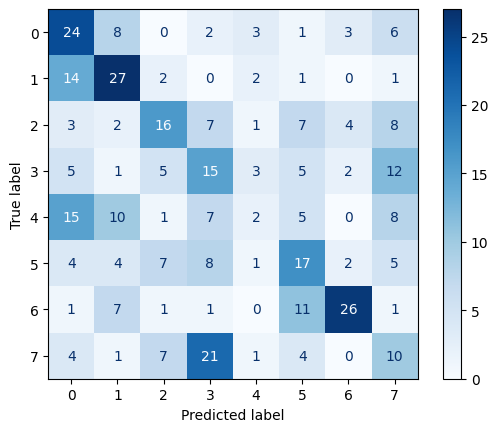

Time elapsed for epoch 28: 0:00:18.227122
Epoch 29/200, Batch 10/42, Loss: 1.5419
Epoch 29/200, Batch 20/42, Loss: 1.5509
Epoch 29/200, Batch 30/42, Loss: 1.6042
Epoch 29/200, Batch 40/42, Loss: 1.4958
Accuracy on images: 39.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.53      0.47        47
           1       0.56      0.64      0.59        47
           2       0.27      0.17      0.21        48
           3       0.26      0.19      0.22        48
           4       0.20      0.12      0.15        48
           5       0.31      0.40      0.35        48
           6       0.81      0.71      0.76        48
           7       0.28      0.42      0.34        48

    accuracy                           0.40       382
   macro avg       0.39      0.40      0.39       382
weighted avg       0.39      0.40      0.38       382


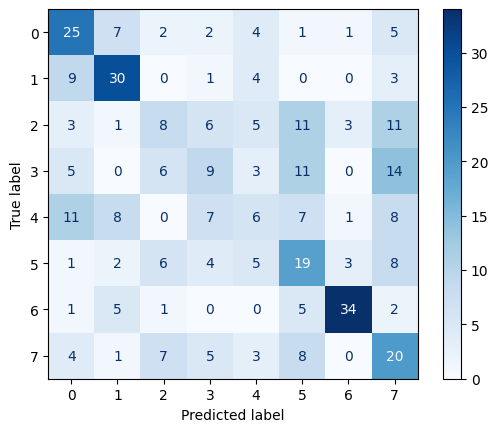

Time elapsed for epoch 29: 0:00:18.106097
Epoch 30/200, Batch 10/42, Loss: 1.4825
Epoch 30/200, Batch 20/42, Loss: 1.5071
Epoch 30/200, Batch 30/42, Loss: 1.5429
Epoch 30/200, Batch 40/42, Loss: 1.4607
Accuracy on images: 40.58%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.47      0.49        47
           1       0.50      0.64      0.56        47
           2       0.38      0.38      0.38        48
           3       0.31      0.17      0.22        48
           4       0.33      0.08      0.13        48
           5       0.28      0.42      0.34        48
           6       0.61      0.77      0.68        48
           7       0.26      0.33      0.29        48

    accuracy                           0.41       382
   macro avg       0.40      0.41      0.39       382
weighted avg       0.40      0.41      0.38       382


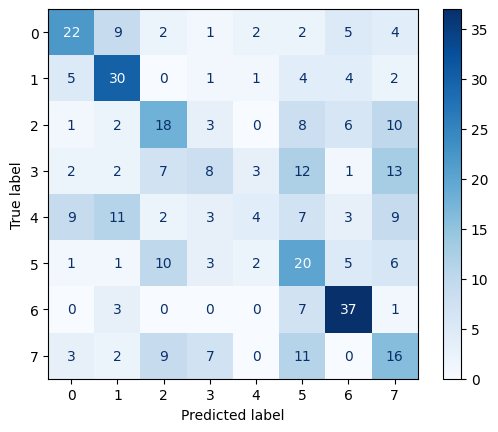

Time elapsed for epoch 30: 0:00:18.131102
Epoch 31/200, Batch 10/42, Loss: 1.4638
Epoch 31/200, Batch 20/42, Loss: 1.5917
Epoch 31/200, Batch 30/42, Loss: 1.5066
Epoch 31/200, Batch 40/42, Loss: 1.5514
Accuracy on images: 43.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.62      0.52        47
           1       0.52      0.51      0.52        47
           2       0.40      0.40      0.40        48
           3       0.29      0.48      0.36        48
           4       0.22      0.08      0.12        48
           5       0.44      0.25      0.32        48
           6       0.74      0.81      0.77        48
           7       0.32      0.31      0.32        48

    accuracy                           0.43       382
   macro avg       0.42      0.43      0.42       382
weighted avg       0.42      0.43      0.42       382


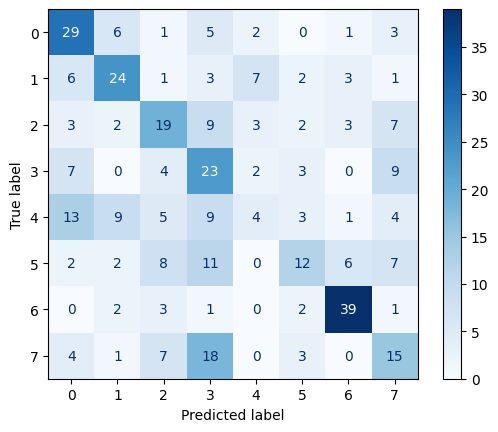

Time elapsed for epoch 31: 0:00:18.370156
Epoch 32/200, Batch 10/42, Loss: 1.5493
Epoch 32/200, Batch 20/42, Loss: 1.4633
Epoch 32/200, Batch 30/42, Loss: 1.4931
Epoch 32/200, Batch 40/42, Loss: 1.4911
Accuracy on images: 40.58%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.49      0.47        47
           1       0.47      0.62      0.53        47
           2       0.42      0.42      0.42        48
           3       0.30      0.40      0.34        48
           4       0.24      0.08      0.12        48
           5       0.27      0.35      0.31        48
           6       0.63      0.77      0.69        48
           7       0.29      0.12      0.17        48

    accuracy                           0.41       382
   macro avg       0.38      0.41      0.38       382
weighted avg       0.38      0.41      0.38       382


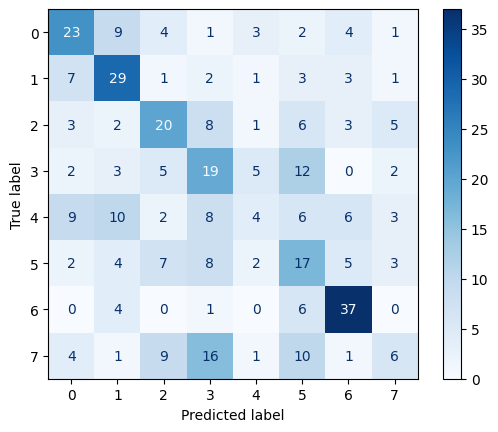

Time elapsed for epoch 32: 0:00:18.395162
Epoch 33/200, Batch 10/42, Loss: 1.5132
Epoch 33/200, Batch 20/42, Loss: 1.4972
Epoch 33/200, Batch 30/42, Loss: 1.4073
Epoch 33/200, Batch 40/42, Loss: 1.4444
Accuracy on images: 39.79%
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49        47
           1       0.47      0.77      0.59        47
           2       0.47      0.17      0.25        48
           3       0.27      0.44      0.33        48
           4       0.17      0.06      0.09        48
           5       0.32      0.48      0.38        48
           6       0.63      0.67      0.65        48
           7       0.27      0.12      0.17        48

    accuracy                           0.40       382
   macro avg       0.39      0.40      0.37       382
weighted avg       0.39      0.40      0.37       382


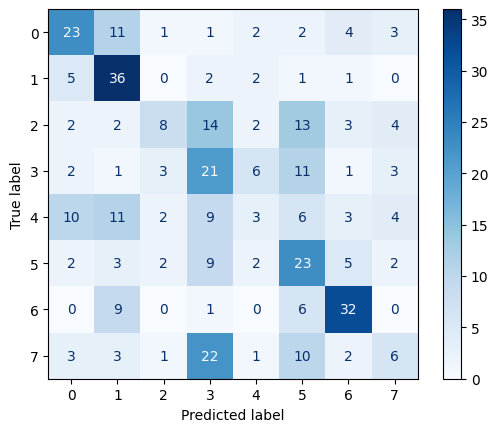

Time elapsed for epoch 33: 0:00:18.568201
Epoch 34/200, Batch 10/42, Loss: 1.5295
Epoch 34/200, Batch 20/42, Loss: 1.4055
Epoch 34/200, Batch 30/42, Loss: 1.4806
Epoch 34/200, Batch 40/42, Loss: 1.4643
Accuracy on images: 37.17%
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.49      0.43        47
           1       0.45      0.53      0.49        47
           2       0.38      0.31      0.34        48
           3       0.27      0.29      0.28        48
           4       0.22      0.10      0.14        48
           5       0.32      0.52      0.40        48
           6       0.75      0.56      0.64        48
           7       0.20      0.17      0.18        48

    accuracy                           0.37       382
   macro avg       0.37      0.37      0.36       382
weighted avg       0.37      0.37      0.36       382


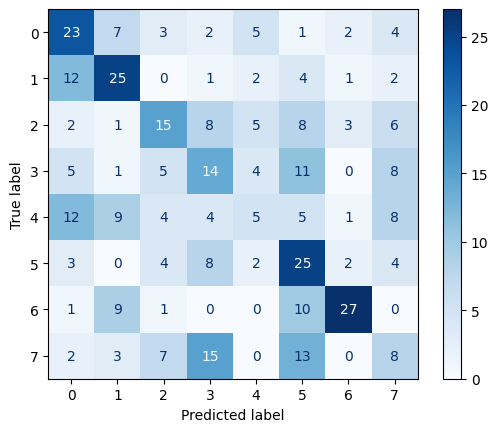

Time elapsed for epoch 34: 0:00:18.509187
Epoch 35/200, Batch 10/42, Loss: 1.3900
Epoch 35/200, Batch 20/42, Loss: 1.4408
Epoch 35/200, Batch 30/42, Loss: 1.4221
Epoch 35/200, Batch 40/42, Loss: 1.4723
Accuracy on images: 43.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.51      0.49        47
           1       0.53      0.62      0.57        47
           2       0.34      0.21      0.26        48
           3       0.31      0.48      0.38        48
           4       0.35      0.12      0.18        48
           5       0.32      0.52      0.40        48
           6       0.69      0.79      0.74        48
           7       0.42      0.21      0.28        48

    accuracy                           0.43       382
   macro avg       0.43      0.43      0.41       382
weighted avg       0.43      0.43      0.41       382


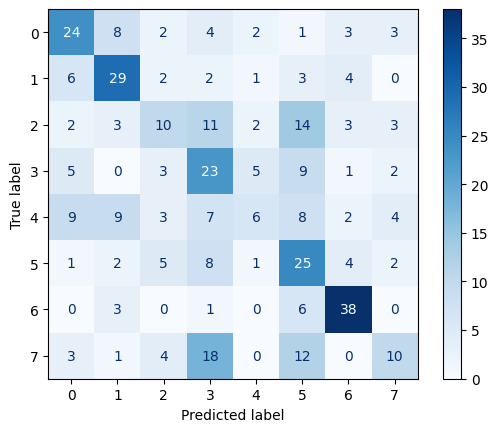

Time elapsed for epoch 35: 0:00:18.784250
Epoch 36/200, Batch 10/42, Loss: 1.3931
Epoch 36/200, Batch 20/42, Loss: 1.3852
Epoch 36/200, Batch 30/42, Loss: 1.4793
Epoch 36/200, Batch 40/42, Loss: 1.5273
Accuracy on images: 41.36%
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.28      0.36        47
           1       0.49      0.68      0.57        47
           2       0.39      0.33      0.36        48
           3       0.35      0.40      0.37        48
           4       0.32      0.23      0.27        48
           5       0.32      0.50      0.39        48
           6       0.71      0.62      0.67        48
           7       0.30      0.27      0.28        48

    accuracy                           0.41       382
   macro avg       0.42      0.41      0.41       382
weighted avg       0.42      0.41      0.41       382


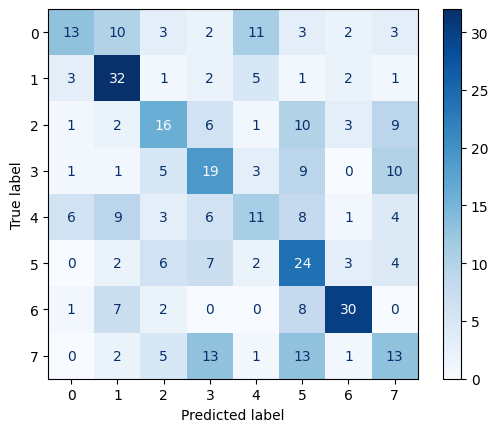

Time elapsed for epoch 36: 0:00:18.145106
Epoch 37/200, Batch 10/42, Loss: 1.4580
Epoch 37/200, Batch 20/42, Loss: 1.4088
Epoch 37/200, Batch 30/42, Loss: 1.3978
Epoch 37/200, Batch 40/42, Loss: 1.4623
Accuracy on images: 43.46%
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.47      0.51        47
           1       0.57      0.64      0.60        47
           2       0.30      0.35      0.33        48
           3       0.38      0.40      0.39        48
           4       0.29      0.12      0.17        48
           5       0.35      0.40      0.37        48
           6       0.67      0.73      0.70        48
           7       0.33      0.38      0.35        48

    accuracy                           0.43       382
   macro avg       0.43      0.44      0.43       382
weighted avg       0.43      0.43      0.43       382


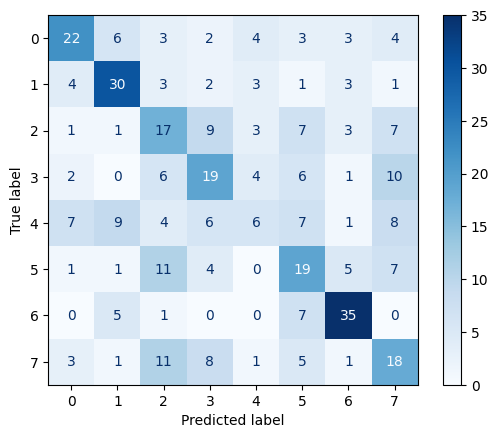

Time elapsed for epoch 37: 0:00:18.287137
Epoch 38/200, Batch 10/42, Loss: 1.3396
Epoch 38/200, Batch 20/42, Loss: 1.4243
Epoch 38/200, Batch 30/42, Loss: 1.4589
Epoch 38/200, Batch 40/42, Loss: 1.3895
Accuracy on images: 43.46%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.51      0.48        47
           1       0.54      0.79      0.64        47
           2       0.44      0.29      0.35        48
           3       0.35      0.48      0.41        48
           4       0.33      0.12      0.18        48
           5       0.32      0.38      0.35        48
           6       0.67      0.71      0.69        48
           7       0.25      0.21      0.23        48

    accuracy                           0.43       382
   macro avg       0.42      0.44      0.42       382
weighted avg       0.42      0.43      0.42       382


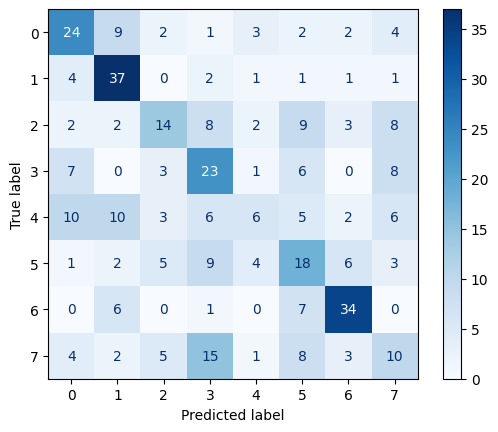

Time elapsed for epoch 38: 0:00:18.105097
Epoch 39/200, Batch 10/42, Loss: 1.4901
Epoch 39/200, Batch 20/42, Loss: 1.4622
Epoch 39/200, Batch 30/42, Loss: 1.4583
Epoch 39/200, Batch 40/42, Loss: 1.4172
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.47      0.45        47
           1       0.50      0.79      0.61        47
           2       0.60      0.25      0.35        48
           3       0.35      0.33      0.34        48
           4       0.23      0.06      0.10        48
           5       0.35      0.60      0.44        48
           6       0.72      0.75      0.73        48
           7       0.36      0.33      0.34        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.42       382
weighted avg       0.44      0.45      0.42       382


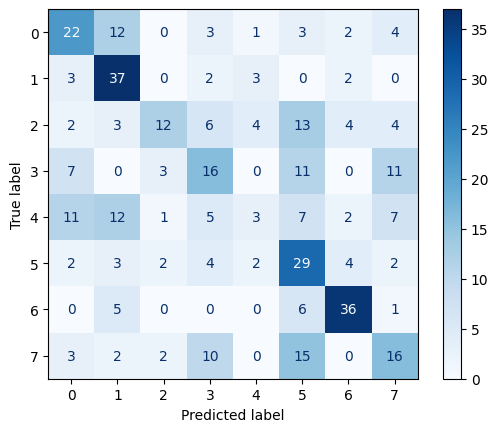

Time elapsed for epoch 39: 0:00:18.045082
Epoch 40/200, Batch 10/42, Loss: 1.4289
Epoch 40/200, Batch 20/42, Loss: 1.4553
Epoch 40/200, Batch 30/42, Loss: 1.3778
Epoch 40/200, Batch 40/42, Loss: 1.4734
Accuracy on images: 42.15%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        47
           1       0.52      0.74      0.61        47
           2       0.31      0.35      0.33        48
           3       0.37      0.35      0.36        48
           4       0.56      0.10      0.18        48
           5       0.32      0.40      0.35        48
           6       0.66      0.69      0.67        48
           7       0.22      0.21      0.22        48

    accuracy                           0.42       382
   macro avg       0.43      0.42      0.40       382
weighted avg       0.43      0.42      0.40       382


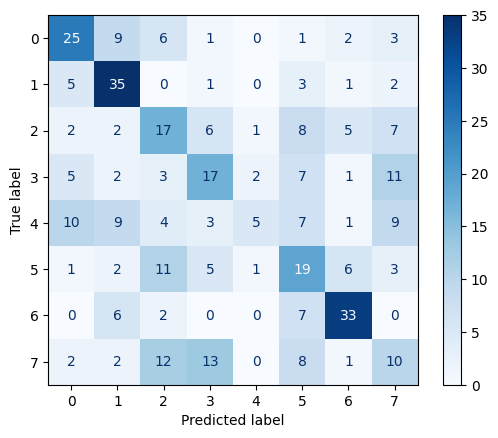

Time elapsed for epoch 40: 0:00:18.223123
Epoch 41/200, Batch 10/42, Loss: 1.3883
Epoch 41/200, Batch 20/42, Loss: 1.2938
Epoch 41/200, Batch 30/42, Loss: 1.4451
Epoch 41/200, Batch 40/42, Loss: 1.4210
Accuracy on images: 40.58%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.55      0.48        47
           1       0.54      0.47      0.50        47
           2       0.37      0.46      0.41        48
           3       0.37      0.48      0.41        48
           4       0.17      0.02      0.04        48
           5       0.31      0.35      0.33        48
           6       0.56      0.73      0.64        48
           7       0.27      0.19      0.22        48

    accuracy                           0.41       382
   macro avg       0.38      0.41      0.38       382
weighted avg       0.37      0.41      0.38       382


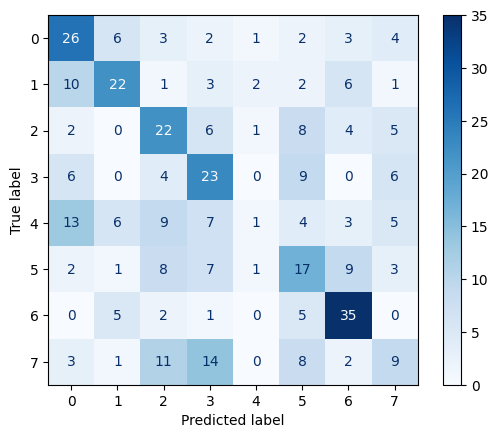

Time elapsed for epoch 41: 0:00:18.293138
Epoch 42/200, Batch 10/42, Loss: 1.3522
Epoch 42/200, Batch 20/42, Loss: 1.3821
Epoch 42/200, Batch 30/42, Loss: 1.4483
Epoch 42/200, Batch 40/42, Loss: 1.3958
Accuracy on images: 43.46%
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.36      0.44        47
           1       0.54      0.64      0.58        47
           2       0.40      0.35      0.38        48
           3       0.31      0.42      0.36        48
           4       0.40      0.25      0.31        48
           5       0.34      0.48      0.40        48
           6       0.71      0.75      0.73        48
           7       0.28      0.23      0.25        48

    accuracy                           0.43       382
   macro avg       0.44      0.43      0.43       382
weighted avg       0.44      0.43      0.43       382


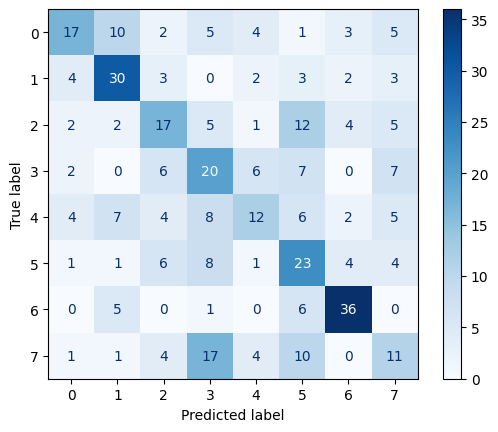

Time elapsed for epoch 42: 0:00:18.185114
Epoch 43/200, Batch 10/42, Loss: 1.3652
Epoch 43/200, Batch 20/42, Loss: 1.2867
Epoch 43/200, Batch 30/42, Loss: 1.4265
Epoch 43/200, Batch 40/42, Loss: 1.5697
Accuracy on images: 39.01%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49        47
           1       0.46      0.72      0.56        47
           2       0.33      0.15      0.20        48
           3       0.32      0.38      0.35        48
           4       0.28      0.10      0.15        48
           5       0.31      0.67      0.42        48
           6       0.77      0.50      0.61        48
           7       0.18      0.12      0.15        48

    accuracy                           0.39       382
   macro avg       0.39      0.39      0.37       382
weighted avg       0.39      0.39      0.37       382


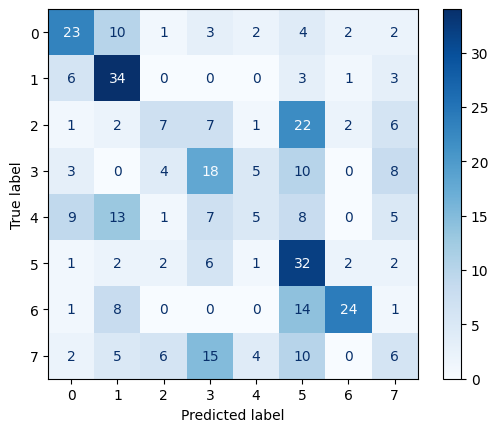

Time elapsed for epoch 43: 0:00:18.004073
Epoch 44/200, Batch 10/42, Loss: 1.4175
Epoch 44/200, Batch 20/42, Loss: 1.2965
Epoch 44/200, Batch 30/42, Loss: 1.4901
Epoch 44/200, Batch 40/42, Loss: 1.3802
Accuracy on images: 44.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.46        47
           1       0.54      0.45      0.49        47
           2       0.35      0.46      0.40        48
           3       0.35      0.52      0.42        48
           4       0.35      0.12      0.18        48
           5       0.36      0.42      0.38        48
           6       0.67      0.92      0.77        48
           7       0.41      0.19      0.26        48

    accuracy                           0.44       382
   macro avg       0.44      0.44      0.42       382
weighted avg       0.44      0.44      0.42       382


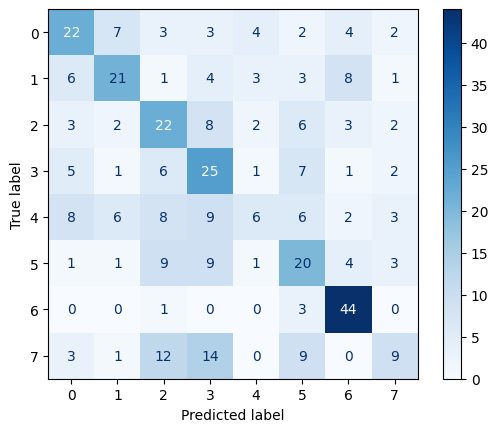

Time elapsed for epoch 44: 0:00:18.524192
Epoch 45/200, Batch 10/42, Loss: 1.3144
Epoch 45/200, Batch 20/42, Loss: 1.4561
Epoch 45/200, Batch 30/42, Loss: 1.4441
Epoch 45/200, Batch 40/42, Loss: 1.4402
Accuracy on images: 42.15%
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.47      0.43        47
           1       0.49      0.74      0.59        47
           2       0.44      0.23      0.30        48
           3       0.33      0.27      0.30        48
           4       0.33      0.12      0.18        48
           5       0.35      0.60      0.44        48
           6       0.70      0.73      0.71        48
           7       0.25      0.21      0.23        48

    accuracy                           0.42       382
   macro avg       0.41      0.42      0.40       382
weighted avg       0.41      0.42      0.40       382


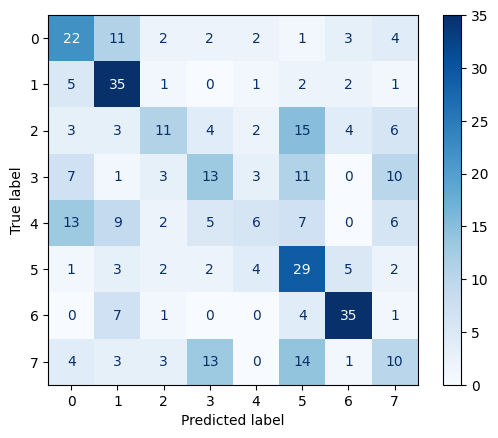

Time elapsed for epoch 45: 0:00:18.030079
Epoch 46/200, Batch 10/42, Loss: 1.3908
Epoch 46/200, Batch 20/42, Loss: 1.3456
Epoch 46/200, Batch 30/42, Loss: 1.2896
Epoch 46/200, Batch 40/42, Loss: 1.4109
Accuracy on images: 44.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48        47
           1       0.57      0.74      0.65        47
           2       0.38      0.44      0.40        48
           3       0.33      0.31      0.32        48
           4       0.33      0.17      0.22        48
           5       0.31      0.44      0.37        48
           6       0.64      0.81      0.72        48
           7       0.33      0.19      0.24        48

    accuracy                           0.44       382
   macro avg       0.43      0.44      0.42       382
weighted avg       0.43      0.44      0.42       382


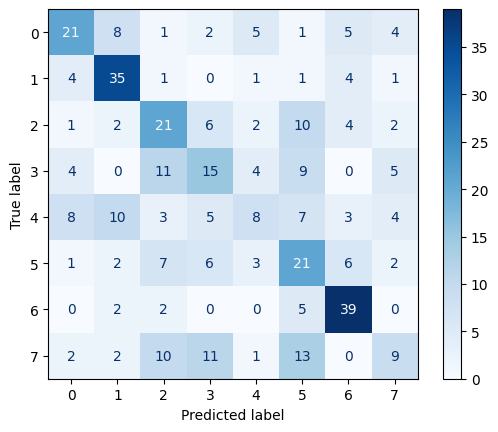

Time elapsed for epoch 46: 0:00:17.848038
Epoch 47/200, Batch 10/42, Loss: 1.3130
Epoch 47/200, Batch 20/42, Loss: 1.3457
Epoch 47/200, Batch 30/42, Loss: 1.3057
Epoch 47/200, Batch 40/42, Loss: 1.3100
Accuracy on images: 45.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.64      0.55        47
           1       0.57      0.64      0.60        47
           2       0.38      0.27      0.32        48
           3       0.34      0.35      0.35        48
           4       0.30      0.19      0.23        48
           5       0.42      0.46      0.44        48
           6       0.72      0.75      0.73        48
           7       0.34      0.35      0.35        48

    accuracy                           0.46       382
   macro avg       0.44      0.46      0.45       382
weighted avg       0.44      0.46      0.44       382


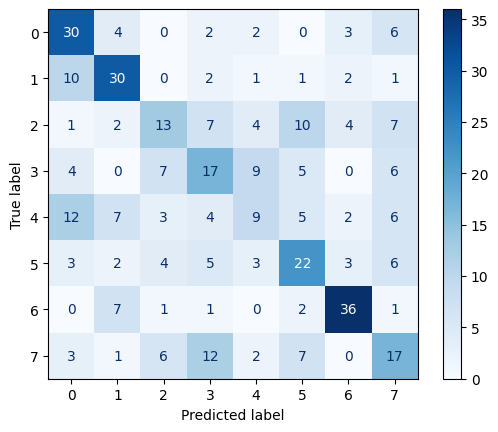

Time elapsed for epoch 47: 0:00:18.437171
Epoch 48/200, Batch 10/42, Loss: 1.4250
Epoch 48/200, Batch 20/42, Loss: 1.3330
Epoch 48/200, Batch 30/42, Loss: 1.3535
Epoch 48/200, Batch 40/42, Loss: 1.4273
Accuracy on images: 43.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.60      0.51        47
           1       0.55      0.62      0.58        47
           2       0.38      0.25      0.30        48
           3       0.29      0.33      0.31        48
           4       0.37      0.23      0.28        48
           5       0.32      0.46      0.38        48
           6       0.73      0.77      0.75        48
           7       0.32      0.21      0.25        48

    accuracy                           0.43       382
   macro avg       0.43      0.43      0.42       382
weighted avg       0.42      0.43      0.42       382


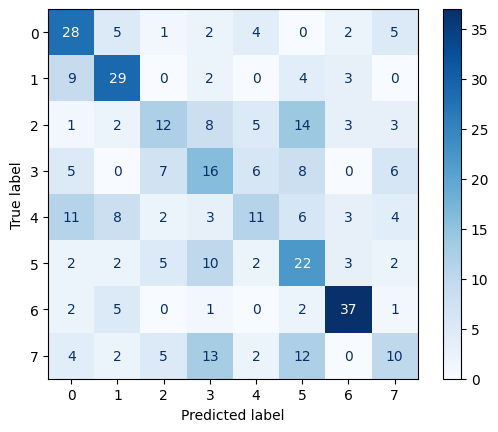

Time elapsed for epoch 48: 0:00:18.184115
Epoch 49/200, Batch 10/42, Loss: 1.3413
Epoch 49/200, Batch 20/42, Loss: 1.3905
Epoch 49/200, Batch 30/42, Loss: 1.3214
Epoch 49/200, Batch 40/42, Loss: 1.4074
Accuracy on images: 45.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.55      0.51        47
           1       0.55      0.72      0.62        47
           2       0.44      0.29      0.35        48
           3       0.37      0.46      0.41        48
           4       0.29      0.21      0.24        48
           5       0.39      0.50      0.44        48
           6       0.72      0.71      0.72        48
           7       0.32      0.21      0.25        48

    accuracy                           0.46       382
   macro avg       0.44      0.46      0.44       382
weighted avg       0.44      0.46      0.44       382


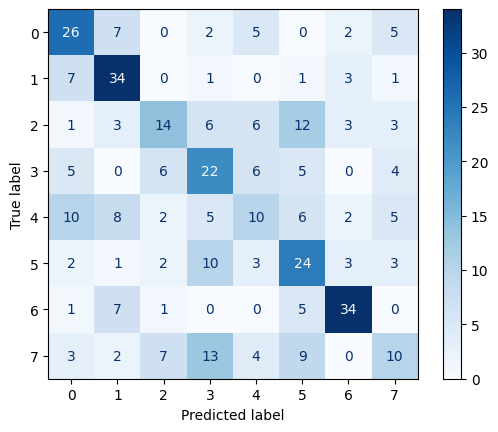

Time elapsed for epoch 49: 0:00:18.492184
Epoch 50/200, Batch 10/42, Loss: 1.4276
Epoch 50/200, Batch 20/42, Loss: 1.3212
Epoch 50/200, Batch 30/42, Loss: 1.2610
Epoch 50/200, Batch 40/42, Loss: 1.3080
Accuracy on images: 42.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50        47
           1       0.52      0.72      0.60        47
           2       0.36      0.31      0.33        48
           3       0.32      0.27      0.29        48
           4       0.38      0.17      0.23        48
           5       0.32      0.50      0.39        48
           6       0.74      0.65      0.69        48
           7       0.30      0.31      0.31        48

    accuracy                           0.43       382
   macro avg       0.43      0.43      0.42       382
weighted avg       0.43      0.43      0.42       382


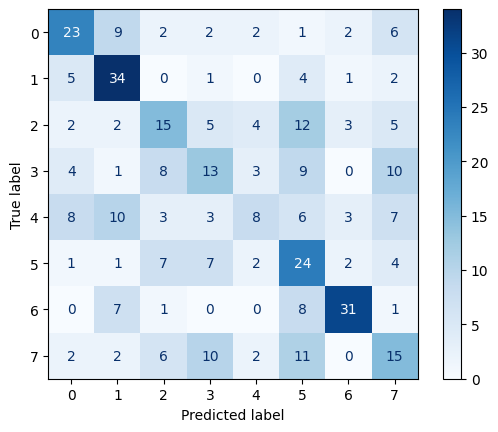

Time elapsed for epoch 50: 0:00:17.871042
Epoch 51/200, Batch 10/42, Loss: 1.4098
Epoch 51/200, Batch 20/42, Loss: 1.2533
Epoch 51/200, Batch 30/42, Loss: 1.2893
Epoch 51/200, Batch 40/42, Loss: 1.4311
Accuracy on images: 42.15%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49        47
           1       0.53      0.68      0.60        47
           2       0.32      0.25      0.28        48
           3       0.28      0.35      0.31        48
           4       0.33      0.21      0.26        48
           5       0.36      0.54      0.43        48
           6       0.73      0.62      0.67        48
           7       0.32      0.23      0.27        48

    accuracy                           0.42       382
   macro avg       0.42      0.42      0.41       382
weighted avg       0.42      0.42      0.41       382


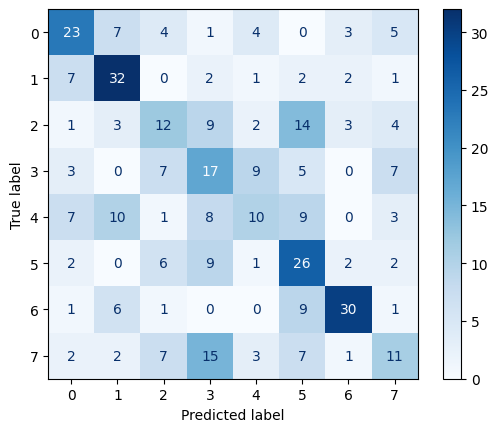

Time elapsed for epoch 51: 0:00:18.577203
Epoch 52/200, Batch 10/42, Loss: 1.3102
Epoch 52/200, Batch 20/42, Loss: 1.3768
Epoch 52/200, Batch 30/42, Loss: 1.2952
Epoch 52/200, Batch 40/42, Loss: 1.2983
Accuracy on images: 44.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57        47
           1       0.55      0.72      0.62        47
           2       0.36      0.17      0.23        48
           3       0.37      0.38      0.37        48
           4       0.36      0.17      0.23        48
           5       0.38      0.35      0.37        48
           6       0.73      0.77      0.75        48
           7       0.25      0.42      0.31        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.43       382
weighted avg       0.44      0.45      0.43       382


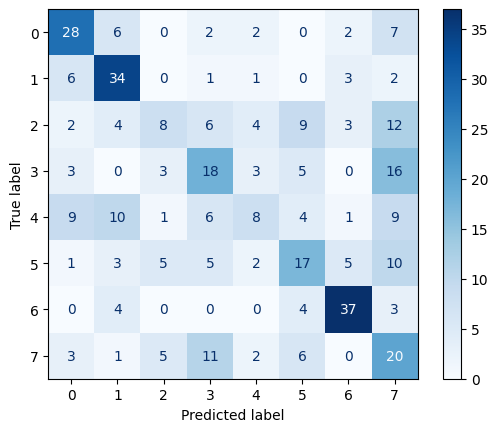

Time elapsed for epoch 52: 0:00:18.352153
Epoch 53/200, Batch 10/42, Loss: 1.2661
Epoch 53/200, Batch 20/42, Loss: 1.3174
Epoch 53/200, Batch 30/42, Loss: 1.4278
Epoch 53/200, Batch 40/42, Loss: 1.3189
Accuracy on images: 46.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49        47
           1       0.55      0.60      0.57        47
           2       0.47      0.44      0.45        48
           3       0.34      0.42      0.38        48
           4       0.33      0.29      0.31        48
           5       0.42      0.46      0.44        48
           6       0.65      0.75      0.70        48
           7       0.40      0.25      0.31        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.45       382
weighted avg       0.46      0.46      0.45       382


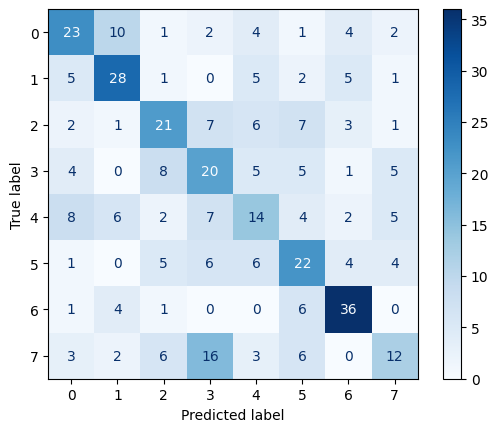

Time elapsed for epoch 53: 0:00:18.080091
Epoch 54/200, Batch 10/42, Loss: 1.3247
Epoch 54/200, Batch 20/42, Loss: 1.3623
Epoch 54/200, Batch 30/42, Loss: 1.2945
Epoch 54/200, Batch 40/42, Loss: 1.3856
Accuracy on images: 47.91%
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        47
           1       0.58      0.66      0.62        47
           2       0.46      0.44      0.45        48
           3       0.38      0.38      0.38        48
           4       0.32      0.23      0.27        48
           5       0.42      0.60      0.50        48
           6       0.73      0.69      0.71        48
           7       0.36      0.33      0.35        48

    accuracy                           0.48       382
   macro avg       0.48      0.48      0.47       382
weighted avg       0.48      0.48      0.47       382


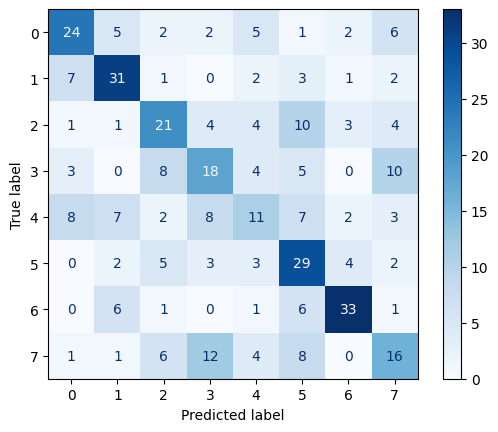

Time elapsed for epoch 54: 0:00:18.341150
Epoch 55/200, Batch 10/42, Loss: 1.3026
Epoch 55/200, Batch 20/42, Loss: 1.2638
Epoch 55/200, Batch 30/42, Loss: 1.3008
Epoch 55/200, Batch 40/42, Loss: 1.2912
Accuracy on images: 44.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.40      0.44        47
           1       0.54      0.68      0.60        47
           2       0.44      0.42      0.43        48
           3       0.26      0.29      0.28        48
           4       0.36      0.21      0.26        48
           5       0.43      0.50      0.46        48
           6       0.68      0.71      0.69        48
           7       0.31      0.33      0.32        48

    accuracy                           0.44       382
   macro avg       0.44      0.44      0.44       382
weighted avg       0.44      0.44      0.44       382


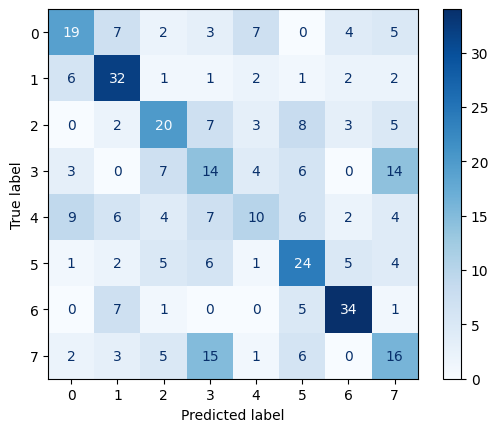

Time elapsed for epoch 55: 0:00:17.923056
Epoch 56/200, Batch 10/42, Loss: 1.2504
Epoch 56/200, Batch 20/42, Loss: 1.3659
Epoch 56/200, Batch 30/42, Loss: 1.2569
Epoch 56/200, Batch 40/42, Loss: 1.3566
Accuracy on images: 42.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47        47
           1       0.56      0.79      0.65        47
           2       0.34      0.35      0.35        48
           3       0.29      0.25      0.27        48
           4       0.32      0.19      0.24        48
           5       0.35      0.46      0.40        48
           6       0.75      0.56      0.64        48
           7       0.31      0.35      0.33        48

    accuracy                           0.42       382
   macro avg       0.43      0.43      0.42       382
weighted avg       0.43      0.42      0.42       382


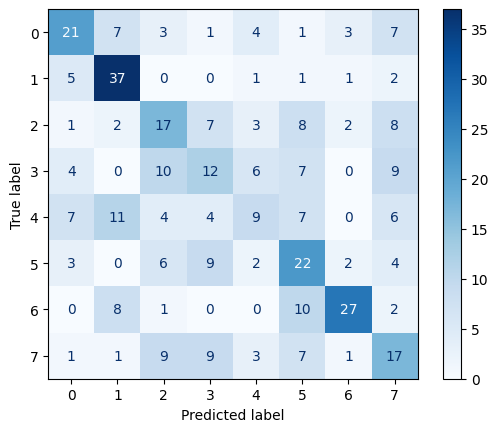

Time elapsed for epoch 56: 0:00:18.020075
Epoch 57/200, Batch 10/42, Loss: 1.2677
Epoch 57/200, Batch 20/42, Loss: 1.2587
Epoch 57/200, Batch 30/42, Loss: 1.3425
Epoch 57/200, Batch 40/42, Loss: 1.3635
Accuracy on images: 42.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.45      0.48        47
           1       0.58      0.62      0.60        47
           2       0.34      0.25      0.29        48
           3       0.33      0.35      0.34        48
           4       0.32      0.21      0.25        48
           5       0.31      0.60      0.41        48
           6       0.81      0.62      0.71        48
           7       0.32      0.29      0.30        48

    accuracy                           0.42       382
   macro avg       0.44      0.42      0.42       382
weighted avg       0.44      0.42      0.42       382


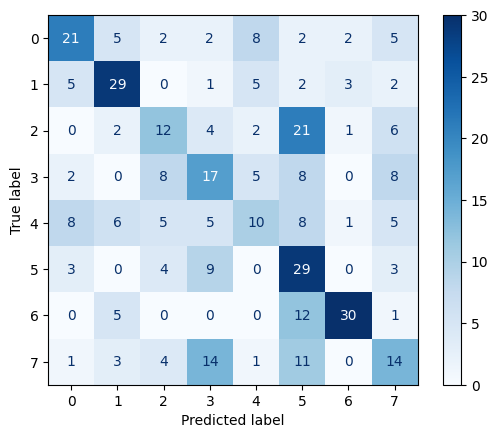

Time elapsed for epoch 57: 0:00:18.095094
Epoch 58/200, Batch 10/42, Loss: 1.2539
Epoch 58/200, Batch 20/42, Loss: 1.2839
Epoch 58/200, Batch 30/42, Loss: 1.3145
Epoch 58/200, Batch 40/42, Loss: 1.3521
Accuracy on images: 43.72%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.60      0.52        47
           1       0.54      0.68      0.60        47
           2       0.37      0.27      0.31        48
           3       0.29      0.35      0.32        48
           4       0.26      0.12      0.17        48
           5       0.39      0.50      0.44        48
           6       0.78      0.73      0.75        48
           7       0.30      0.25      0.27        48

    accuracy                           0.44       382
   macro avg       0.42      0.44      0.42       382
weighted avg       0.42      0.44      0.42       382


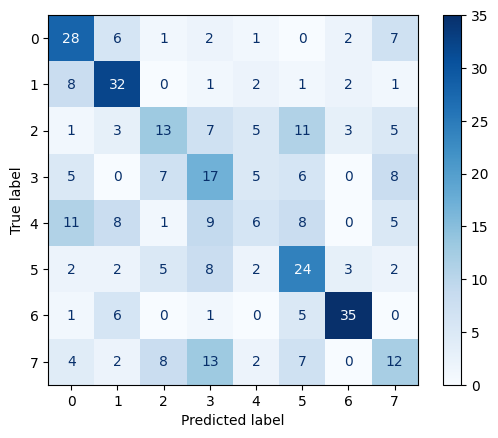

Time elapsed for epoch 58: 0:00:18.222124
Epoch 59/200, Batch 10/42, Loss: 1.2291
Epoch 59/200, Batch 20/42, Loss: 1.3165
Epoch 59/200, Batch 30/42, Loss: 1.3677
Epoch 59/200, Batch 40/42, Loss: 1.2321
Accuracy on images: 42.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.51      0.48        47
           1       0.63      0.62      0.62        47
           2       0.39      0.44      0.41        48
           3       0.28      0.29      0.29        48
           4       0.32      0.27      0.29        48
           5       0.28      0.29      0.29        48
           6       0.78      0.73      0.75        48
           7       0.28      0.25      0.26        48

    accuracy                           0.42       382
   macro avg       0.43      0.42      0.42       382
weighted avg       0.43      0.42      0.42       382


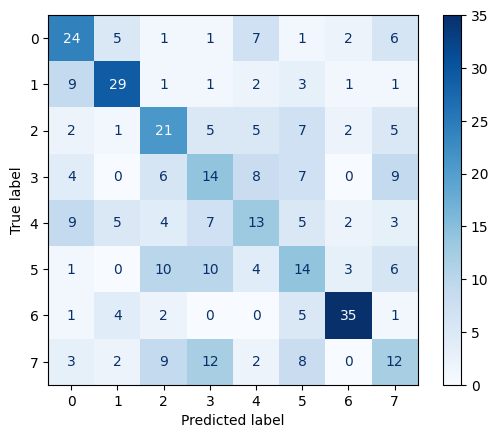

Time elapsed for epoch 59: 0:00:18.209120
Epoch 60/200, Batch 10/42, Loss: 1.2098
Epoch 60/200, Batch 20/42, Loss: 1.2925
Epoch 60/200, Batch 30/42, Loss: 1.3612
Epoch 60/200, Batch 40/42, Loss: 1.2104
Accuracy on images: 43.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        47
           1       0.57      0.66      0.61        47
           2       0.42      0.33      0.37        48
           3       0.30      0.42      0.35        48
           4       0.21      0.15      0.17        48
           5       0.38      0.40      0.39        48
           6       0.73      0.77      0.75        48
           7       0.39      0.35      0.37        48

    accuracy                           0.44       382
   macro avg       0.43      0.44      0.43       382
weighted avg       0.43      0.44      0.43       382


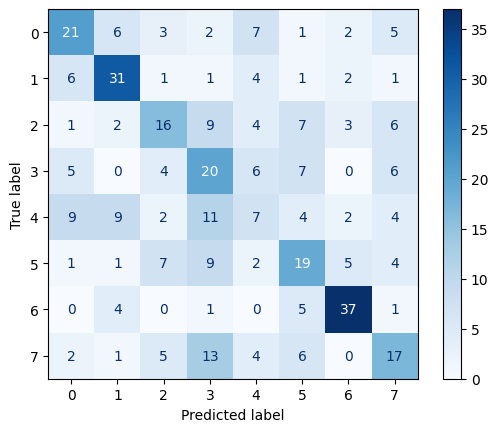

Time elapsed for epoch 60: 0:00:18.112097
Epoch 61/200, Batch 10/42, Loss: 1.2520
Epoch 61/200, Batch 20/42, Loss: 1.2676
Epoch 61/200, Batch 30/42, Loss: 1.3601
Epoch 61/200, Batch 40/42, Loss: 1.2456
Accuracy on images: 44.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        47
           1       0.58      0.74      0.65        47
           2       0.42      0.27      0.33        48
           3       0.31      0.31      0.31        48
           4       0.22      0.19      0.20        48
           5       0.37      0.44      0.40        48
           6       0.74      0.73      0.74        48
           7       0.38      0.42      0.40        48

    accuracy                           0.44       382
   macro avg       0.44      0.44      0.44       382
weighted avg       0.44      0.44      0.44       382


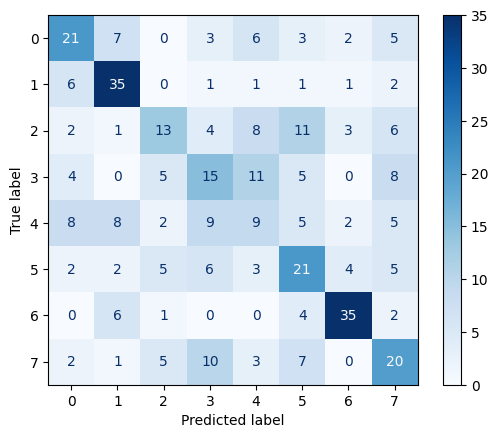

Time elapsed for epoch 61: 0:00:18.418167
Epoch 62/200, Batch 10/42, Loss: 1.2959
Epoch 62/200, Batch 20/42, Loss: 1.2041
Epoch 62/200, Batch 30/42, Loss: 1.2159
Epoch 62/200, Batch 40/42, Loss: 1.2311
Accuracy on images: 41.62%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.45      0.45        47
           1       0.57      0.51      0.54        47
           2       0.42      0.40      0.41        48
           3       0.29      0.31      0.30        48
           4       0.26      0.19      0.22        48
           5       0.40      0.48      0.44        48
           6       0.67      0.65      0.66        48
           7       0.28      0.35      0.31        48

    accuracy                           0.42       382
   macro avg       0.42      0.42      0.42       382
weighted avg       0.42      0.42      0.42       382


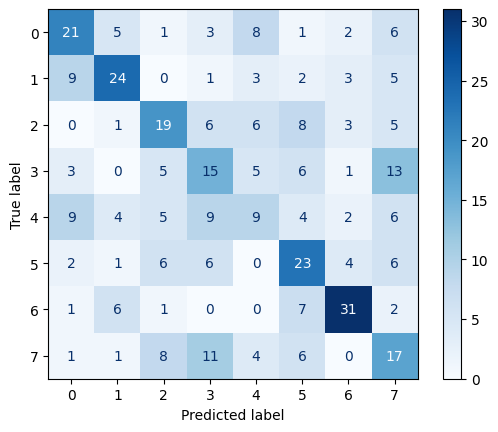

Time elapsed for epoch 62: 0:00:18.239126
Epoch 63/200, Batch 10/42, Loss: 1.2177
Epoch 63/200, Batch 20/42, Loss: 1.1903
Epoch 63/200, Batch 30/42, Loss: 1.2969
Epoch 63/200, Batch 40/42, Loss: 1.2547
Accuracy on images: 44.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.43      0.42        47
           1       0.56      0.68      0.62        47
           2       0.36      0.33      0.35        48
           3       0.30      0.35      0.33        48
           4       0.35      0.19      0.24        48
           5       0.45      0.52      0.49        48
           6       0.79      0.71      0.75        48
           7       0.32      0.35      0.34        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


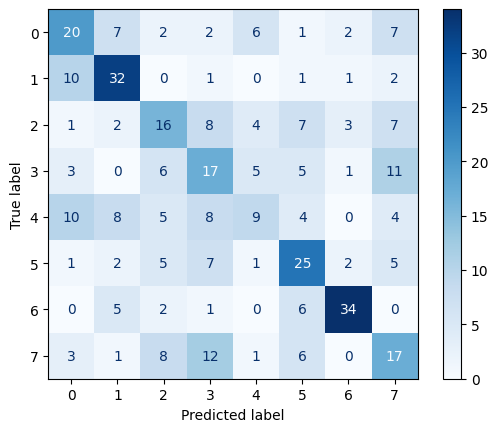

Time elapsed for epoch 63: 0:00:18.415167
Epoch 64/200, Batch 10/42, Loss: 1.3234
Epoch 64/200, Batch 20/42, Loss: 1.2642
Epoch 64/200, Batch 30/42, Loss: 1.2507
Epoch 64/200, Batch 40/42, Loss: 1.2281
Accuracy on images: 41.62%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.46        47
           1       0.52      0.60      0.55        47
           2       0.30      0.23      0.26        48
           3       0.30      0.44      0.36        48
           4       0.33      0.12      0.18        48
           5       0.32      0.42      0.36        48
           6       0.71      0.77      0.74        48
           7       0.34      0.29      0.31        48

    accuracy                           0.42       382
   macro avg       0.41      0.42      0.40       382
weighted avg       0.41      0.42      0.40       382


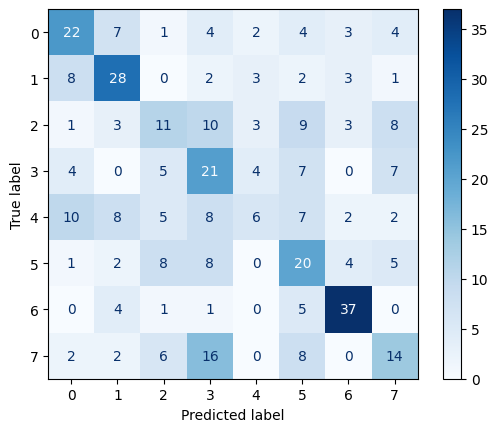

Time elapsed for epoch 64: 0:00:18.363154
Epoch 65/200, Batch 10/42, Loss: 1.2141
Epoch 65/200, Batch 20/42, Loss: 1.2882
Epoch 65/200, Batch 30/42, Loss: 1.2137
Epoch 65/200, Batch 40/42, Loss: 1.2233
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.45      0.48        47
           1       0.55      0.64      0.59        47
           2       0.42      0.33      0.37        48
           3       0.31      0.44      0.37        48
           4       0.29      0.19      0.23        48
           5       0.37      0.42      0.39        48
           6       0.68      0.79      0.73        48
           7       0.39      0.33      0.36        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


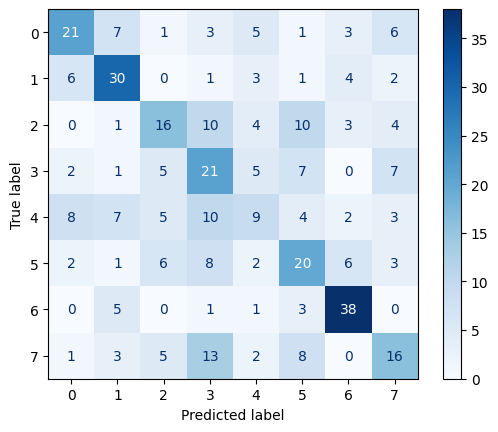

Time elapsed for epoch 65: 0:00:18.133103
Epoch 66/200, Batch 10/42, Loss: 1.2292
Epoch 66/200, Batch 20/42, Loss: 1.1035
Epoch 66/200, Batch 30/42, Loss: 1.2403
Epoch 66/200, Batch 40/42, Loss: 1.2711
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.50        47
           1       0.55      0.60      0.57        47
           2       0.40      0.40      0.40        48
           3       0.32      0.27      0.29        48
           4       0.36      0.19      0.25        48
           5       0.41      0.44      0.42        48
           6       0.68      0.79      0.73        48
           7       0.32      0.38      0.35        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


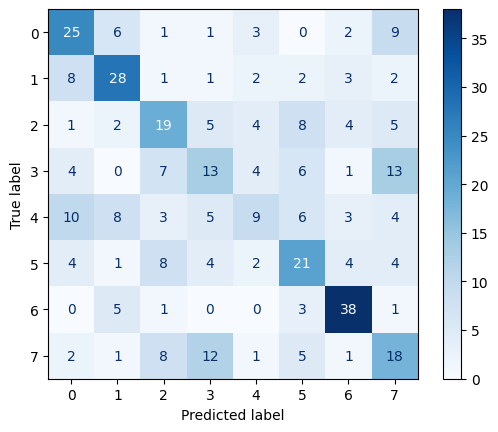

Time elapsed for epoch 66: 0:00:18.179113
Epoch 67/200, Batch 10/42, Loss: 1.2635
Epoch 67/200, Batch 20/42, Loss: 1.2190
Epoch 67/200, Batch 30/42, Loss: 1.2623
Epoch 67/200, Batch 40/42, Loss: 1.2639
Accuracy on images: 41.36%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.55      0.50        47
           1       0.50      0.57      0.53        47
           2       0.36      0.19      0.25        48
           3       0.30      0.29      0.29        48
           4       0.21      0.08      0.12        48
           5       0.35      0.58      0.44        48
           6       0.65      0.75      0.70        48
           7       0.32      0.29      0.30        48

    accuracy                           0.41       382
   macro avg       0.39      0.41      0.39       382
weighted avg       0.39      0.41      0.39       382


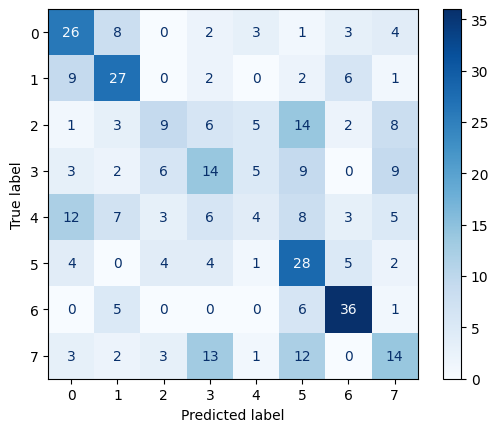

Time elapsed for epoch 67: 0:00:17.919054
Epoch 68/200, Batch 10/42, Loss: 1.1832
Epoch 68/200, Batch 20/42, Loss: 1.2737
Epoch 68/200, Batch 30/42, Loss: 1.2852
Epoch 68/200, Batch 40/42, Loss: 1.2323
Accuracy on images: 42.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.32      0.38        47
           1       0.47      0.64      0.54        47
           2       0.30      0.21      0.25        48
           3       0.35      0.27      0.31        48
           4       0.36      0.17      0.23        48
           5       0.39      0.67      0.49        48
           6       0.72      0.75      0.73        48
           7       0.29      0.38      0.33        48

    accuracy                           0.42       382
   macro avg       0.42      0.42      0.41       382
weighted avg       0.42      0.42      0.41       382


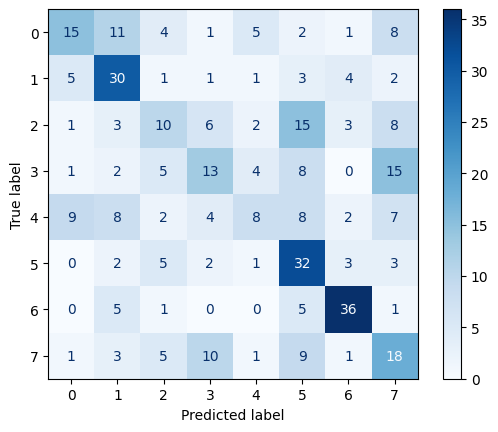

Time elapsed for epoch 68: 0:00:18.173112
Epoch 69/200, Batch 10/42, Loss: 1.2284
Epoch 69/200, Batch 20/42, Loss: 1.2576
Epoch 69/200, Batch 30/42, Loss: 1.2493
Epoch 69/200, Batch 40/42, Loss: 1.1772
Accuracy on images: 42.15%
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.38      0.45        47
           1       0.46      0.53      0.50        47
           2       0.38      0.25      0.30        48
           3       0.31      0.35      0.33        48
           4       0.30      0.21      0.25        48
           5       0.36      0.65      0.47        48
           6       0.73      0.69      0.71        48
           7       0.33      0.31      0.32        48

    accuracy                           0.42       382
   macro avg       0.43      0.42      0.42       382
weighted avg       0.43      0.42      0.41       382


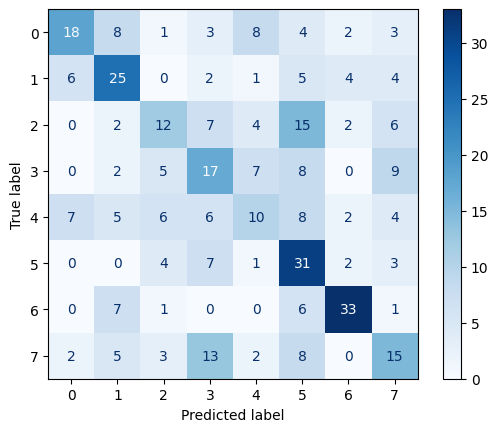

Time elapsed for epoch 69: 0:00:18.159108
Epoch 70/200, Batch 10/42, Loss: 1.1309
Epoch 70/200, Batch 20/42, Loss: 1.1241
Epoch 70/200, Batch 30/42, Loss: 1.1656
Epoch 70/200, Batch 40/42, Loss: 1.2524
Accuracy on images: 46.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.60      0.53        47
           1       0.59      0.64      0.61        47
           2       0.35      0.46      0.40        48
           3       0.36      0.33      0.34        48
           4       0.55      0.12      0.20        48
           5       0.42      0.52      0.46        48
           6       0.69      0.71      0.70        48
           7       0.37      0.35      0.36        48

    accuracy                           0.47       382
   macro avg       0.48      0.47      0.45       382
weighted avg       0.48      0.47      0.45       382


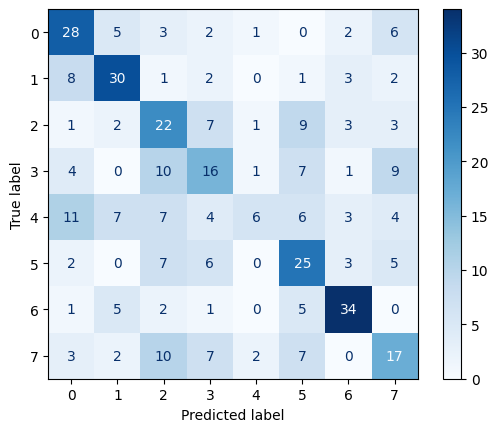

Time elapsed for epoch 70: 0:00:18.020077
Epoch 71/200, Batch 10/42, Loss: 1.1904
Epoch 71/200, Batch 20/42, Loss: 1.1965
Epoch 71/200, Batch 30/42, Loss: 1.2467
Epoch 71/200, Batch 40/42, Loss: 1.1815
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        47
           1       0.53      0.60      0.56        47
           2       0.37      0.35      0.36        48
           3       0.33      0.31      0.32        48
           4       0.35      0.19      0.24        48
           5       0.41      0.62      0.50        48
           6       0.72      0.79      0.75        48
           7       0.37      0.29      0.33        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


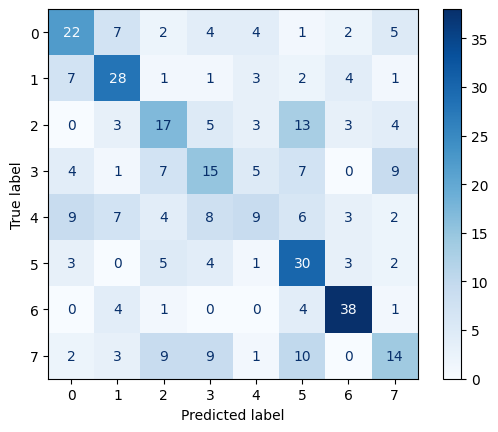

Time elapsed for epoch 71: 0:00:18.104096
Epoch 72/200, Batch 10/42, Loss: 1.2322
Epoch 72/200, Batch 20/42, Loss: 1.3594
Epoch 72/200, Batch 30/42, Loss: 1.1835
Epoch 72/200, Batch 40/42, Loss: 1.2236
Accuracy on images: 47.38%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.55      0.49        47
           1       0.57      0.57      0.57        47
           2       0.45      0.31      0.37        48
           3       0.41      0.35      0.38        48
           4       0.37      0.27      0.31        48
           5       0.43      0.54      0.48        48
           6       0.68      0.81      0.74        48
           7       0.37      0.38      0.37        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.47       382
weighted avg       0.47      0.47      0.46       382


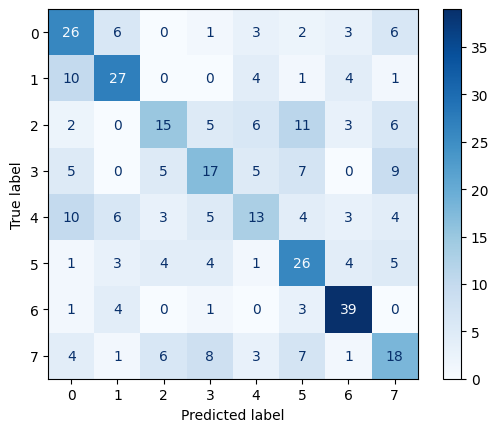

Time elapsed for epoch 72: 0:00:18.053084
Epoch 73/200, Batch 10/42, Loss: 1.1470
Epoch 73/200, Batch 20/42, Loss: 1.1776
Epoch 73/200, Batch 30/42, Loss: 1.2262
Epoch 73/200, Batch 40/42, Loss: 1.2150
Accuracy on images: 46.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.66      0.52        47
           1       0.60      0.55      0.58        47
           2       0.38      0.44      0.41        48
           3       0.33      0.29      0.31        48
           4       0.45      0.19      0.26        48
           5       0.44      0.56      0.49        48
           6       0.80      0.69      0.74        48
           7       0.38      0.38      0.38        48

    accuracy                           0.47       382
   macro avg       0.48      0.47      0.46       382
weighted avg       0.48      0.47      0.46       382


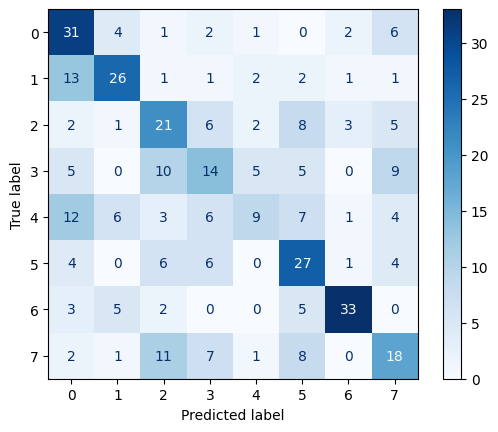

Time elapsed for epoch 73: 0:00:18.041082
Epoch 74/200, Batch 10/42, Loss: 1.1887
Epoch 74/200, Batch 20/42, Loss: 1.1822
Epoch 74/200, Batch 30/42, Loss: 1.1982
Epoch 74/200, Batch 40/42, Loss: 1.2542
Accuracy on images: 41.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        47
           1       0.54      0.64      0.58        47
           2       0.26      0.19      0.22        48
           3       0.32      0.25      0.28        48
           4       0.37      0.15      0.21        48
           5       0.36      0.79      0.49        48
           6       0.78      0.60      0.68        48
           7       0.32      0.31      0.32        48

    accuracy                           0.42       382
   macro avg       0.42      0.42      0.40       382
weighted avg       0.42      0.42      0.40       382


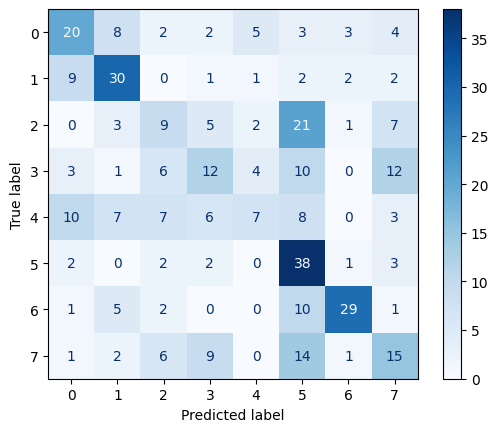

Time elapsed for epoch 74: 0:00:18.511188
Epoch 75/200, Batch 10/42, Loss: 1.0864
Epoch 75/200, Batch 20/42, Loss: 1.1079
Epoch 75/200, Batch 30/42, Loss: 1.2129
Epoch 75/200, Batch 40/42, Loss: 1.3013
Accuracy on images: 44.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.53      0.53        47
           1       0.52      0.68      0.59        47
           2       0.33      0.31      0.32        48
           3       0.33      0.35      0.34        48
           4       0.60      0.19      0.29        48
           5       0.37      0.46      0.41        48
           6       0.72      0.71      0.72        48
           7       0.30      0.33      0.32        48

    accuracy                           0.45       382
   macro avg       0.46      0.45      0.44       382
weighted avg       0.46      0.45      0.44       382


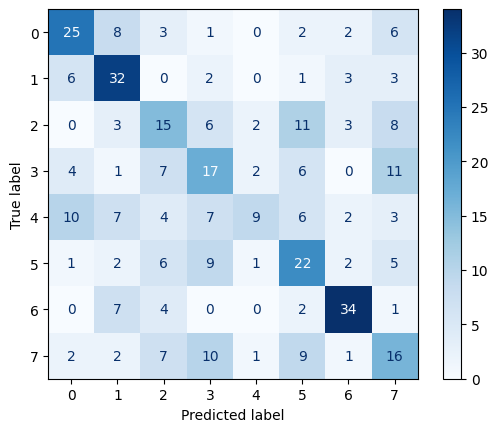

Time elapsed for epoch 75: 0:00:18.340149
Epoch 76/200, Batch 10/42, Loss: 1.1616
Epoch 76/200, Batch 20/42, Loss: 1.1767
Epoch 76/200, Batch 30/42, Loss: 1.1700
Epoch 76/200, Batch 40/42, Loss: 1.2250
Accuracy on images: 43.72%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.43      0.47        47
           1       0.51      0.68      0.58        47
           2       0.33      0.35      0.34        48
           3       0.33      0.31      0.32        48
           4       0.33      0.23      0.27        48
           5       0.39      0.50      0.44        48
           6       0.76      0.73      0.74        48
           7       0.30      0.27      0.28        48

    accuracy                           0.44       382
   macro avg       0.43      0.44      0.43       382
weighted avg       0.43      0.44      0.43       382


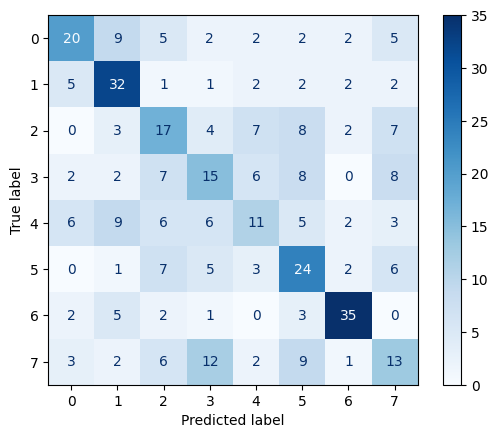

Time elapsed for epoch 76: 0:00:18.223124
Epoch 77/200, Batch 10/42, Loss: 1.0737
Epoch 77/200, Batch 20/42, Loss: 1.1436
Epoch 77/200, Batch 30/42, Loss: 1.1781
Epoch 77/200, Batch 40/42, Loss: 1.2145
Accuracy on images: 42.93%
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.36      0.38        47
           1       0.57      0.51      0.54        47
           2       0.38      0.31      0.34        48
           3       0.33      0.35      0.34        48
           4       0.25      0.23      0.24        48
           5       0.40      0.67      0.50        48
           6       0.72      0.71      0.72        48
           7       0.39      0.29      0.33        48

    accuracy                           0.43       382
   macro avg       0.43      0.43      0.42       382
weighted avg       0.43      0.43      0.42       382


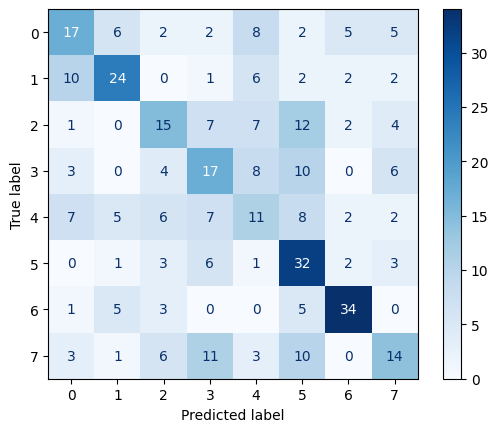

Time elapsed for epoch 77: 0:00:17.999072
Epoch 78/200, Batch 10/42, Loss: 1.1921
Epoch 78/200, Batch 20/42, Loss: 1.1441
Epoch 78/200, Batch 30/42, Loss: 1.2717
Epoch 78/200, Batch 40/42, Loss: 1.1642
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.38      0.42        47
           1       0.57      0.62      0.59        47
           2       0.39      0.27      0.32        48
           3       0.33      0.40      0.36        48
           4       0.30      0.29      0.30        48
           5       0.43      0.62      0.51        48
           6       0.73      0.75      0.74        48
           7       0.37      0.29      0.33        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.45       382
weighted avg       0.45      0.45      0.45       382


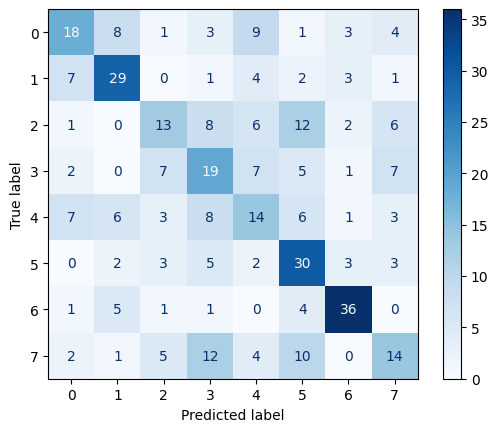

Time elapsed for epoch 78: 0:00:18.260131
Epoch 79/200, Batch 10/42, Loss: 1.1152
Epoch 79/200, Batch 20/42, Loss: 1.1322
Epoch 79/200, Batch 30/42, Loss: 1.3074
Epoch 79/200, Batch 40/42, Loss: 1.1788
Accuracy on images: 42.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.49      0.55        47
           1       0.53      0.55      0.54        47
           2       0.35      0.27      0.31        48
           3       0.34      0.35      0.35        48
           4       0.27      0.19      0.22        48
           5       0.31      0.58      0.41        48
           6       0.64      0.81      0.72        48
           7       0.27      0.15      0.19        48

    accuracy                           0.42       382
   macro avg       0.42      0.42      0.41       382
weighted avg       0.42      0.42      0.41       382


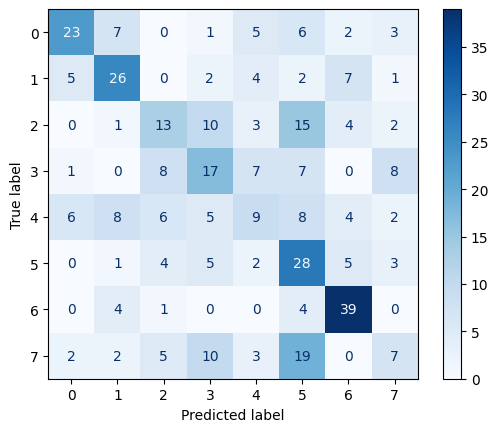

Time elapsed for epoch 79: 0:00:18.140104
Epoch 80/200, Batch 10/42, Loss: 1.2191
Epoch 80/200, Batch 20/42, Loss: 1.2873
Epoch 80/200, Batch 30/42, Loss: 1.0791
Epoch 80/200, Batch 40/42, Loss: 1.0884
Accuracy on images: 44.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.51      0.48        47
           1       0.61      0.47      0.53        47
           2       0.39      0.35      0.37        48
           3       0.35      0.40      0.37        48
           4       0.27      0.25      0.26        48
           5       0.41      0.50      0.45        48
           6       0.78      0.75      0.77        48
           7       0.36      0.33      0.34        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.45       382
weighted avg       0.45      0.45      0.45       382


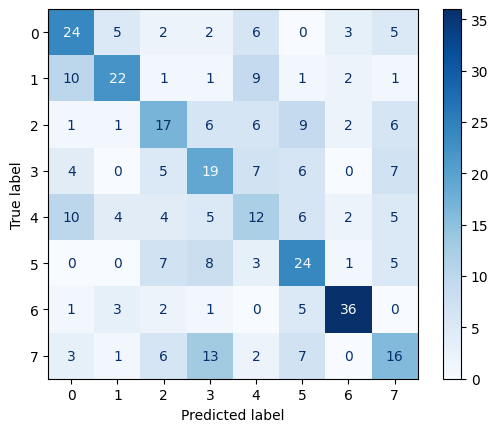

Time elapsed for epoch 80: 0:00:18.151106
Epoch 81/200, Batch 10/42, Loss: 1.0961
Epoch 81/200, Batch 20/42, Loss: 1.1692
Epoch 81/200, Batch 30/42, Loss: 1.0812
Epoch 81/200, Batch 40/42, Loss: 1.1865
Accuracy on images: 43.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45        47
           1       0.60      0.55      0.58        47
           2       0.34      0.44      0.39        48
           3       0.26      0.23      0.24        48
           4       0.26      0.23      0.24        48
           5       0.42      0.44      0.43        48
           6       0.69      0.88      0.77        48
           7       0.32      0.29      0.30        48

    accuracy                           0.43       382
   macro avg       0.42      0.43      0.42       382
weighted avg       0.42      0.43      0.42       382


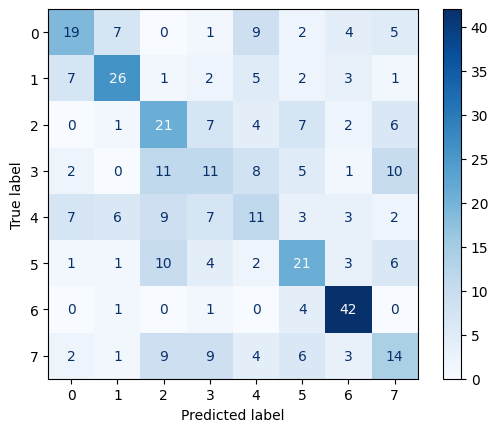

Time elapsed for epoch 81: 0:00:18.328147
Epoch 82/200, Batch 10/42, Loss: 1.1878
Epoch 82/200, Batch 20/42, Loss: 1.0687
Epoch 82/200, Batch 30/42, Loss: 1.1971
Epoch 82/200, Batch 40/42, Loss: 1.2022
Accuracy on images: 46.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46        47
           1       0.61      0.60      0.60        47
           2       0.40      0.40      0.40        48
           3       0.35      0.35      0.35        48
           4       0.42      0.21      0.28        48
           5       0.39      0.58      0.47        48
           6       0.76      0.77      0.76        48
           7       0.40      0.35      0.37        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.46       382
weighted avg       0.47      0.47      0.46       382


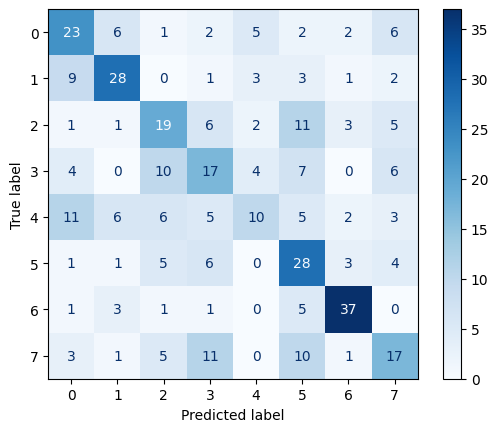

Time elapsed for epoch 82: 0:00:18.044082
Epoch 83/200, Batch 10/42, Loss: 1.2493
Epoch 83/200, Batch 20/42, Loss: 1.1195
Epoch 83/200, Batch 30/42, Loss: 1.1973
Epoch 83/200, Batch 40/42, Loss: 1.1183
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        47
           1       0.60      0.51      0.55        47
           2       0.41      0.33      0.37        48
           3       0.37      0.29      0.33        48
           4       0.40      0.21      0.27        48
           5       0.41      0.62      0.50        48
           6       0.66      0.83      0.73        48
           7       0.28      0.35      0.31        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.44       382
weighted avg       0.45      0.45      0.44       382


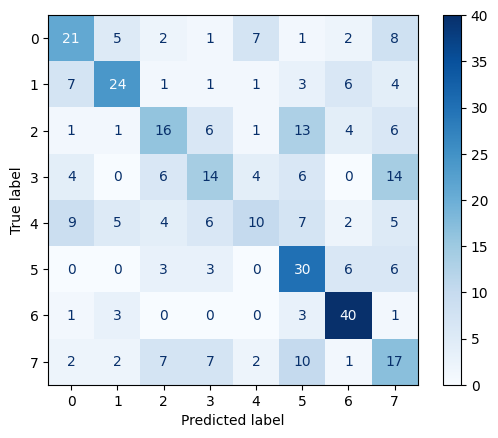

Time elapsed for epoch 83: 0:00:17.967066
Epoch 84/200, Batch 10/42, Loss: 1.1649
Epoch 84/200, Batch 20/42, Loss: 1.1474
Epoch 84/200, Batch 30/42, Loss: 1.1603
Epoch 84/200, Batch 40/42, Loss: 1.2344
Accuracy on images: 46.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.53      0.53        47
           1       0.55      0.74      0.63        47
           2       0.39      0.31      0.35        48
           3       0.35      0.35      0.35        48
           4       0.38      0.12      0.19        48
           5       0.40      0.65      0.50        48
           6       0.73      0.75      0.74        48
           7       0.33      0.29      0.31        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.45       382
weighted avg       0.46      0.47      0.45       382


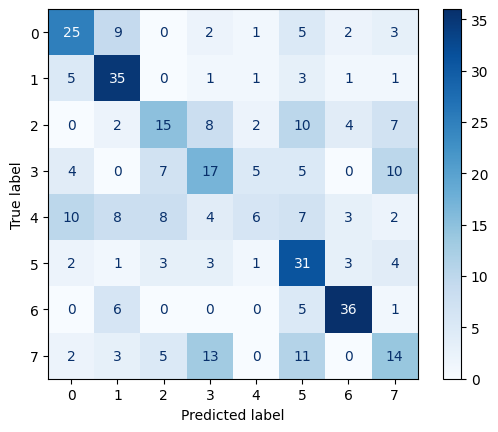

Time elapsed for epoch 84: 0:00:18.903276
Epoch 85/200, Batch 10/42, Loss: 1.1218
Epoch 85/200, Batch 20/42, Loss: 1.1111
Epoch 85/200, Batch 30/42, Loss: 1.1569
Epoch 85/200, Batch 40/42, Loss: 1.1847
Accuracy on images: 46.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.38      0.46        47
           1       0.58      0.68      0.63        47
           2       0.43      0.31      0.36        48
           3       0.37      0.38      0.37        48
           4       0.30      0.27      0.29        48
           5       0.43      0.56      0.49        48
           6       0.74      0.73      0.74        48
           7       0.36      0.44      0.40        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.47       382
weighted avg       0.47      0.47      0.46       382


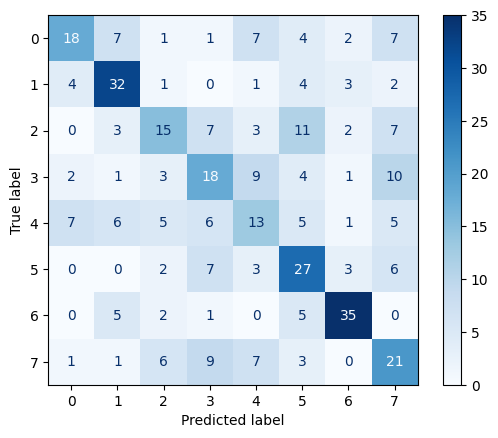

Time elapsed for epoch 85: 0:00:18.367156
Epoch 86/200, Batch 10/42, Loss: 1.1325
Epoch 86/200, Batch 20/42, Loss: 1.1551
Epoch 86/200, Batch 30/42, Loss: 1.1448
Epoch 86/200, Batch 40/42, Loss: 1.2519
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.40      0.44        47
           1       0.54      0.72      0.62        47
           2       0.35      0.33      0.34        48
           3       0.35      0.33      0.34        48
           4       0.53      0.19      0.28        48
           5       0.34      0.62      0.44        48
           6       0.71      0.67      0.69        48
           7       0.39      0.31      0.35        48

    accuracy                           0.45       382
   macro avg       0.46      0.45      0.44       382
weighted avg       0.46      0.45      0.44       382


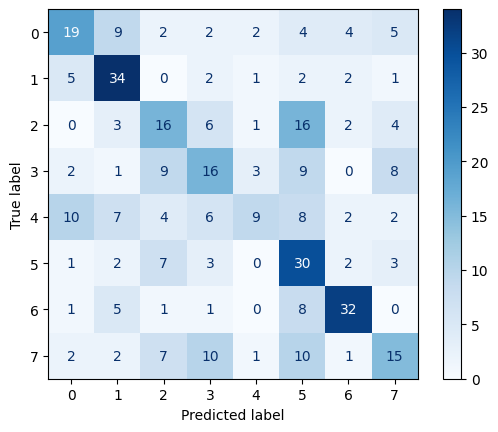

Time elapsed for epoch 86: 0:00:18.498185
Epoch 87/200, Batch 10/42, Loss: 1.2392
Epoch 87/200, Batch 20/42, Loss: 1.0539
Epoch 87/200, Batch 30/42, Loss: 1.1192
Epoch 87/200, Batch 40/42, Loss: 1.1307
Accuracy on images: 46.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.50        47
           1       0.60      0.66      0.63        47
           2       0.38      0.27      0.32        48
           3       0.44      0.40      0.42        48
           4       0.31      0.21      0.25        48
           5       0.41      0.48      0.44        48
           6       0.70      0.77      0.73        48
           7       0.34      0.42      0.38        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.46       382
weighted avg       0.46      0.47      0.46       382


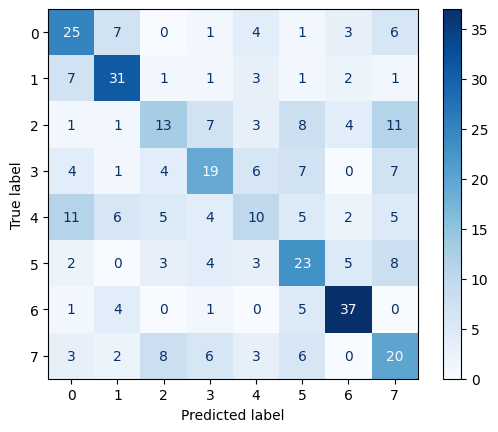

Time elapsed for epoch 87: 0:00:18.618213
Epoch 88/200, Batch 10/42, Loss: 1.0639
Epoch 88/200, Batch 20/42, Loss: 1.0128
Epoch 88/200, Batch 30/42, Loss: 1.1458
Epoch 88/200, Batch 40/42, Loss: 1.2099
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.53      0.51        47
           1       0.56      0.60      0.58        47
           2       0.35      0.40      0.37        48
           3       0.45      0.35      0.40        48
           4       0.27      0.21      0.24        48
           5       0.40      0.42      0.41        48
           6       0.69      0.77      0.73        48
           7       0.37      0.35      0.36        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.45       382
weighted avg       0.44      0.45      0.45       382


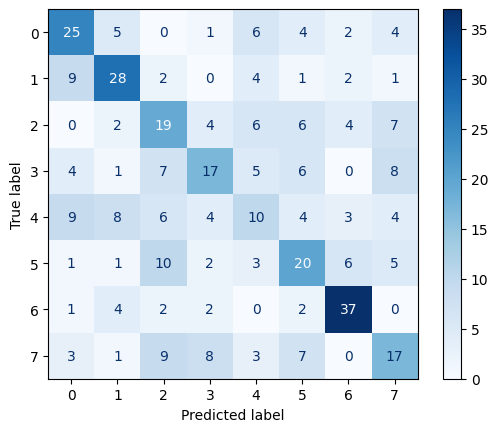

Time elapsed for epoch 88: 0:00:18.089092
Epoch 89/200, Batch 10/42, Loss: 1.1162
Epoch 89/200, Batch 20/42, Loss: 1.1485
Epoch 89/200, Batch 30/42, Loss: 1.1211
Epoch 89/200, Batch 40/42, Loss: 1.1170
Accuracy on images: 45.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.57      0.52        47
           1       0.57      0.62      0.59        47
           2       0.35      0.31      0.33        48
           3       0.34      0.29      0.31        48
           4       0.27      0.15      0.19        48
           5       0.45      0.52      0.49        48
           6       0.72      0.81      0.76        48
           7       0.33      0.38      0.35        48

    accuracy                           0.46       382
   macro avg       0.44      0.46      0.44       382
weighted avg       0.44      0.46      0.44       382


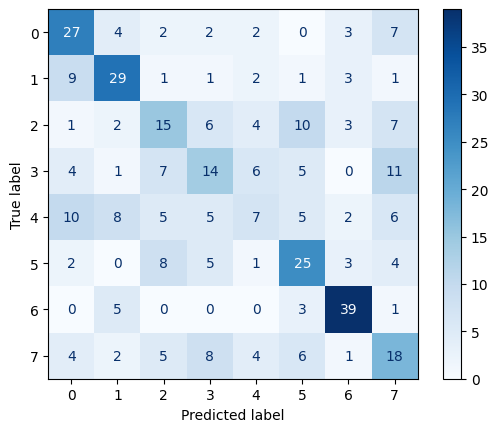

Time elapsed for epoch 89: 0:00:18.454175
Epoch 90/200, Batch 10/42, Loss: 1.1352
Epoch 90/200, Batch 20/42, Loss: 1.1221
Epoch 90/200, Batch 30/42, Loss: 1.0776
Epoch 90/200, Batch 40/42, Loss: 1.0900
Accuracy on images: 44.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.36      0.41        47
           1       0.55      0.72      0.62        47
           2       0.28      0.27      0.27        48
           3       0.39      0.27      0.32        48
           4       0.30      0.19      0.23        48
           5       0.40      0.62      0.49        48
           6       0.77      0.75      0.76        48
           7       0.32      0.35      0.34        48

    accuracy                           0.44       382
   macro avg       0.44      0.44      0.43       382
weighted avg       0.44      0.44      0.43       382


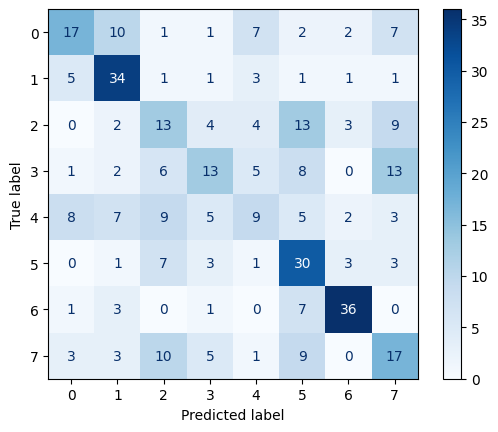

Time elapsed for epoch 90: 0:00:18.660222
Epoch 91/200, Batch 10/42, Loss: 1.0316
Epoch 91/200, Batch 20/42, Loss: 1.1453
Epoch 91/200, Batch 30/42, Loss: 1.1119
Epoch 91/200, Batch 40/42, Loss: 1.1423
Accuracy on images: 45.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46        47
           1       0.49      0.77      0.60        47
           2       0.39      0.29      0.33        48
           3       0.37      0.40      0.38        48
           4       0.39      0.19      0.25        48
           5       0.47      0.58      0.52        48
           6       0.73      0.69      0.71        48
           7       0.32      0.29      0.30        48

    accuracy                           0.46       382
   macro avg       0.45      0.46      0.44       382
weighted avg       0.45      0.46      0.44       382


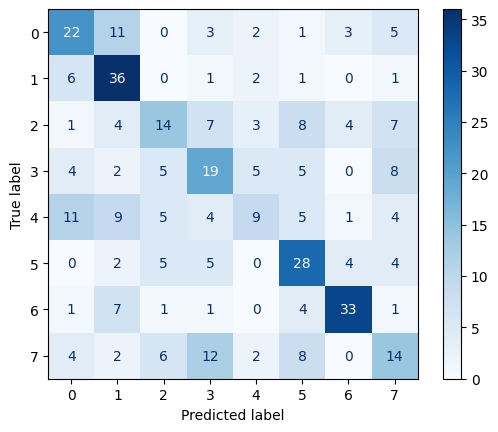

Time elapsed for epoch 91: 0:00:18.170111
Epoch 92/200, Batch 10/42, Loss: 1.0458
Epoch 92/200, Batch 20/42, Loss: 1.0991
Epoch 92/200, Batch 30/42, Loss: 1.1218
Epoch 92/200, Batch 40/42, Loss: 1.1049
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.40      0.44        47
           1       0.52      0.68      0.59        47
           2       0.38      0.29      0.33        48
           3       0.40      0.44      0.42        48
           4       0.31      0.25      0.28        48
           5       0.37      0.52      0.43        48
           6       0.81      0.71      0.76        48
           7       0.36      0.31      0.33        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.45       382
weighted avg       0.45      0.45      0.45       382


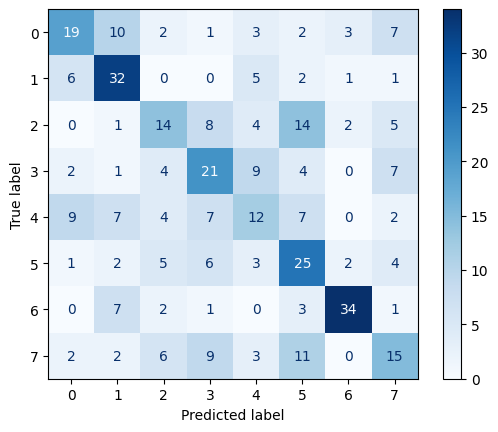

Time elapsed for epoch 92: 0:00:18.206119
Epoch 93/200, Batch 10/42, Loss: 1.2694
Epoch 93/200, Batch 20/42, Loss: 1.0550
Epoch 93/200, Batch 30/42, Loss: 1.1011
Epoch 93/200, Batch 40/42, Loss: 1.1394
Accuracy on images: 46.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.49      0.51        47
           1       0.56      0.66      0.61        47
           2       0.38      0.31      0.34        48
           3       0.36      0.31      0.33        48
           4       0.36      0.17      0.23        48
           5       0.44      0.60      0.51        48
           6       0.67      0.85      0.75        48
           7       0.33      0.35      0.34        48

    accuracy                           0.47       382
   macro avg       0.45      0.47      0.45       382
weighted avg       0.45      0.47      0.45       382


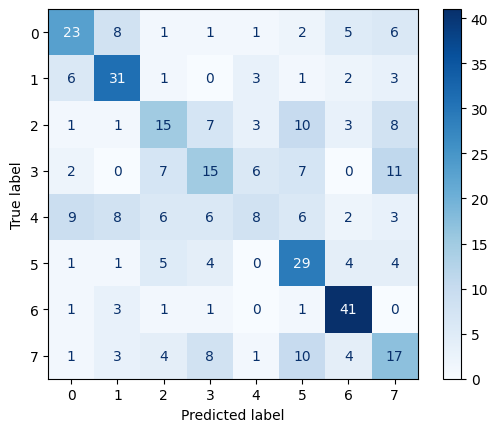

Time elapsed for epoch 93: 0:00:17.955061
Epoch 94/200, Batch 10/42, Loss: 1.0958
Epoch 94/200, Batch 20/42, Loss: 1.1594
Epoch 94/200, Batch 30/42, Loss: 1.1055
Epoch 94/200, Batch 40/42, Loss: 1.1985
Accuracy on images: 48.43%
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.45      0.49        47
           1       0.66      0.57      0.61        47
           2       0.33      0.38      0.35        48
           3       0.37      0.40      0.38        48
           4       0.41      0.31      0.35        48
           5       0.48      0.52      0.50        48
           6       0.80      0.83      0.82        48
           7       0.34      0.42      0.38        48

    accuracy                           0.48       382
   macro avg       0.49      0.48      0.49       382
weighted avg       0.49      0.48      0.49       382


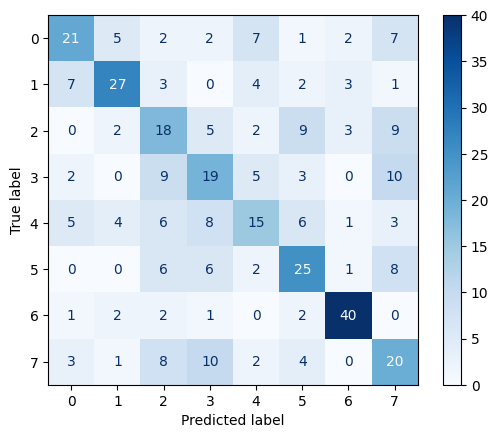

Time elapsed for epoch 94: 0:00:18.199118
Epoch 95/200, Batch 10/42, Loss: 1.0643
Epoch 95/200, Batch 20/42, Loss: 1.1102
Epoch 95/200, Batch 30/42, Loss: 1.1434
Epoch 95/200, Batch 40/42, Loss: 1.1001
Accuracy on images: 46.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.47      0.52        47
           1       0.55      0.55      0.55        47
           2       0.35      0.35      0.35        48
           3       0.38      0.42      0.40        48
           4       0.50      0.10      0.17        48
           5       0.44      0.56      0.50        48
           6       0.64      0.77      0.70        48
           7       0.33      0.46      0.38        48

    accuracy                           0.46       382
   macro avg       0.47      0.46      0.45       382
weighted avg       0.47      0.46      0.45       382


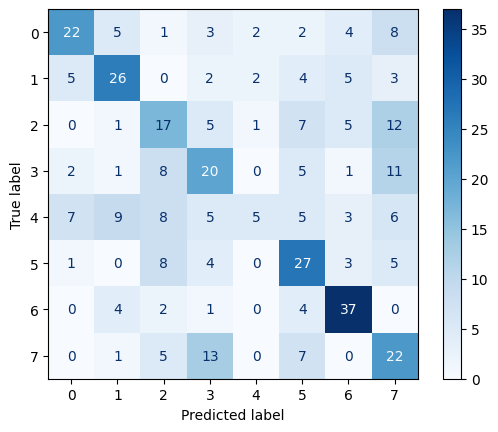

Time elapsed for epoch 95: 0:00:18.298140
Epoch 96/200, Batch 10/42, Loss: 1.0978
Epoch 96/200, Batch 20/42, Loss: 1.1206
Epoch 96/200, Batch 30/42, Loss: 1.1138
Epoch 96/200, Batch 40/42, Loss: 1.0878
Accuracy on images: 45.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        47
           1       0.56      0.64      0.59        47
           2       0.37      0.40      0.38        48
           3       0.35      0.38      0.36        48
           4       0.38      0.21      0.27        48
           5       0.42      0.50      0.46        48
           6       0.79      0.71      0.75        48
           7       0.33      0.38      0.35        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.45       382
weighted avg       0.46      0.46      0.45       382


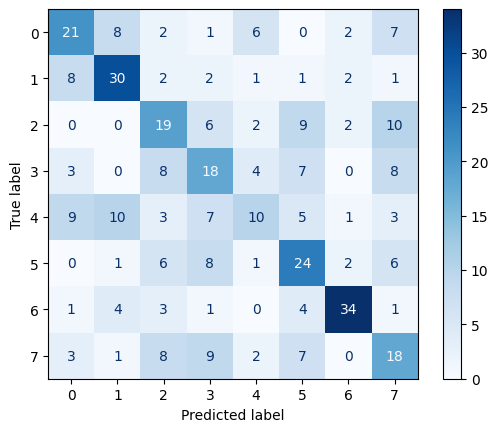

Time elapsed for epoch 96: 0:00:18.662223
Epoch 97/200, Batch 10/42, Loss: 1.0638
Epoch 97/200, Batch 20/42, Loss: 1.0356
Epoch 97/200, Batch 30/42, Loss: 1.1022
Epoch 97/200, Batch 40/42, Loss: 1.0868
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        47
           1       0.55      0.72      0.62        47
           2       0.41      0.31      0.35        48
           3       0.27      0.21      0.24        48
           4       0.37      0.21      0.27        48
           5       0.40      0.62      0.49        48
           6       0.76      0.73      0.74        48
           7       0.28      0.27      0.27        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


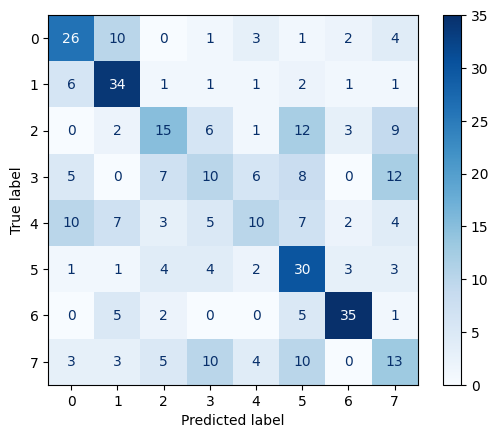

Time elapsed for epoch 97: 0:00:18.496184
Epoch 98/200, Batch 10/42, Loss: 1.0558
Epoch 98/200, Batch 20/42, Loss: 1.0640
Epoch 98/200, Batch 30/42, Loss: 1.0969
Epoch 98/200, Batch 40/42, Loss: 1.1715
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48        47
           1       0.60      0.53      0.56        47
           2       0.37      0.33      0.35        48
           3       0.33      0.31      0.32        48
           4       0.33      0.25      0.29        48
           5       0.42      0.60      0.50        48
           6       0.76      0.81      0.79        48
           7       0.28      0.31      0.29        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.45       382
weighted avg       0.45      0.45      0.45       382


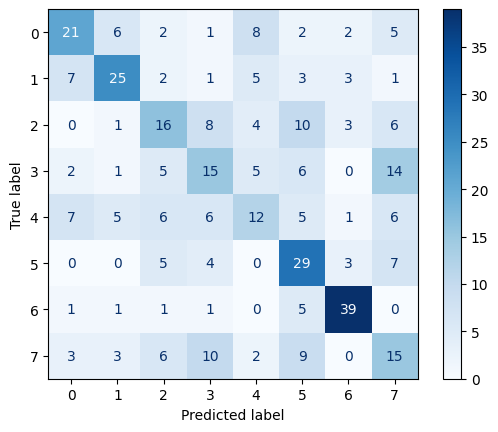

Time elapsed for epoch 98: 0:00:18.477181
Epoch 99/200, Batch 10/42, Loss: 1.0943
Epoch 99/200, Batch 20/42, Loss: 0.9986
Epoch 99/200, Batch 30/42, Loss: 1.2022
Epoch 99/200, Batch 40/42, Loss: 1.0267
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43        47
           1       0.51      0.66      0.57        47
           2       0.36      0.38      0.37        48
           3       0.37      0.38      0.37        48
           4       0.32      0.15      0.20        48
           5       0.40      0.52      0.45        48
           6       0.67      0.79      0.72        48
           7       0.36      0.33      0.35        48

    accuracy                           0.45       382
   macro avg       0.43      0.45      0.43       382
weighted avg       0.43      0.45      0.43       382


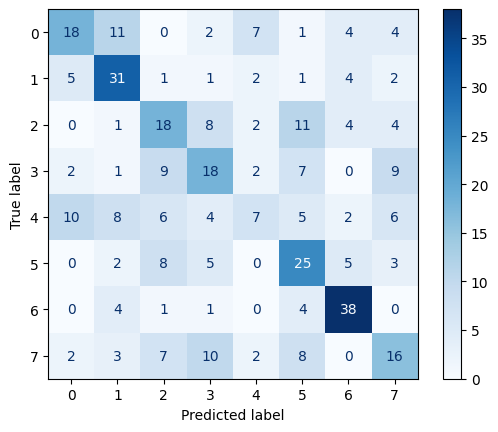

Time elapsed for epoch 99: 0:00:18.706232
Epoch 100/200, Batch 10/42, Loss: 1.0290
Epoch 100/200, Batch 20/42, Loss: 1.0348
Epoch 100/200, Batch 30/42, Loss: 1.0327
Epoch 100/200, Batch 40/42, Loss: 1.0689
Accuracy on images: 46.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.51      0.48        47
           1       0.60      0.64      0.62        47
           2       0.41      0.40      0.40        48
           3       0.34      0.38      0.36        48
           4       0.33      0.23      0.27        48
           5       0.44      0.48      0.46        48
           6       0.77      0.75      0.76        48
           7       0.34      0.33      0.34        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.46       382
weighted avg       0.46      0.46      0.46       382


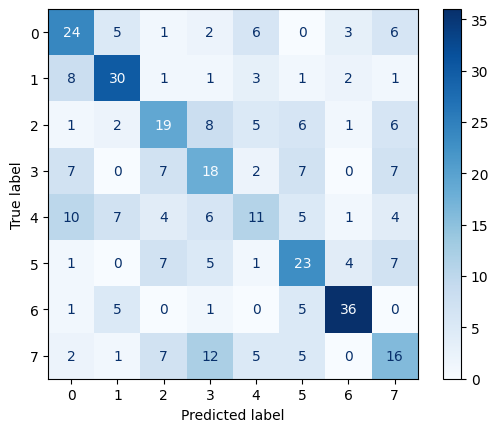

Time elapsed for epoch 100: 0:00:19.006300
Epoch 101/200, Batch 10/42, Loss: 1.0589
Epoch 101/200, Batch 20/42, Loss: 0.9703
Epoch 101/200, Batch 30/42, Loss: 1.0896
Epoch 101/200, Batch 40/42, Loss: 1.2242
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40        47
           1       0.53      0.72      0.61        47
           2       0.33      0.27      0.30        48
           3       0.39      0.40      0.39        48
           4       0.43      0.19      0.26        48
           5       0.42      0.52      0.46        48
           6       0.65      0.75      0.70        48
           7       0.38      0.38      0.38        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


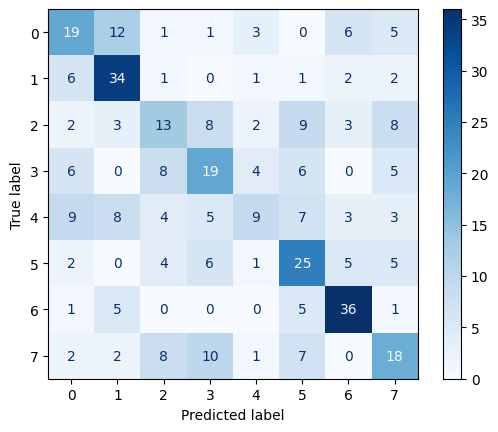

Time elapsed for epoch 101: 0:00:18.773248
Epoch 102/200, Batch 10/42, Loss: 1.1291
Epoch 102/200, Batch 20/42, Loss: 1.1821
Epoch 102/200, Batch 30/42, Loss: 1.0727
Epoch 102/200, Batch 40/42, Loss: 1.1286
Accuracy on images: 43.72%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.55      0.49        47
           1       0.58      0.53      0.56        47
           2       0.33      0.33      0.33        48
           3       0.34      0.35      0.35        48
           4       0.36      0.19      0.25        48
           5       0.40      0.52      0.45        48
           6       0.77      0.75      0.76        48
           7       0.28      0.27      0.28        48

    accuracy                           0.44       382
   macro avg       0.44      0.44      0.43       382
weighted avg       0.44      0.44      0.43       382


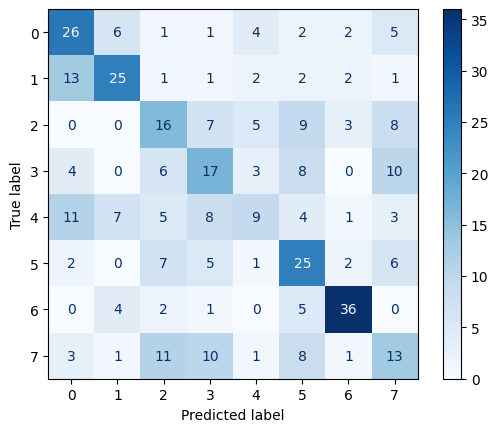

Time elapsed for epoch 102: 0:00:18.833362
Epoch 103/200, Batch 10/42, Loss: 1.0038
Epoch 103/200, Batch 20/42, Loss: 1.0540
Epoch 103/200, Batch 30/42, Loss: 1.0713
Epoch 103/200, Batch 40/42, Loss: 1.0419
Accuracy on images: 45.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.43      0.45        47
           1       0.59      0.70      0.64        47
           2       0.35      0.29      0.32        48
           3       0.39      0.42      0.40        48
           4       0.29      0.19      0.23        48
           5       0.39      0.60      0.47        48
           6       0.73      0.73      0.73        48
           7       0.38      0.31      0.34        48

    accuracy                           0.46       382
   macro avg       0.45      0.46      0.45       382
weighted avg       0.45      0.46      0.45       382


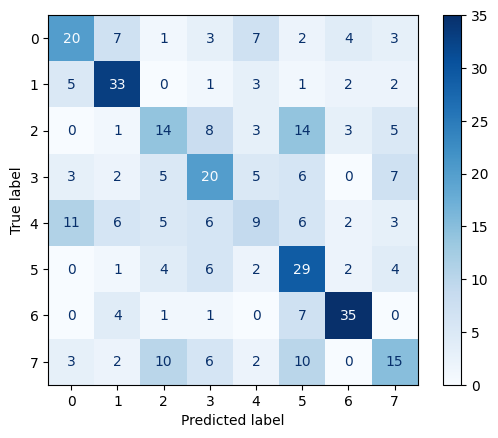

Time elapsed for epoch 103: 0:00:18.636217
Epoch 104/200, Batch 10/42, Loss: 1.1070
Epoch 104/200, Batch 20/42, Loss: 1.0788
Epoch 104/200, Batch 30/42, Loss: 0.9867
Epoch 104/200, Batch 40/42, Loss: 1.0897
Accuracy on images: 39.79%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.30      0.36        47
           1       0.57      0.53      0.55        47
           2       0.28      0.35      0.31        48
           3       0.33      0.29      0.31        48
           4       0.26      0.21      0.23        48
           5       0.33      0.52      0.41        48
           6       0.67      0.77      0.72        48
           7       0.28      0.21      0.24        48

    accuracy                           0.40       382
   macro avg       0.40      0.40      0.39       382
weighted avg       0.40      0.40      0.39       382


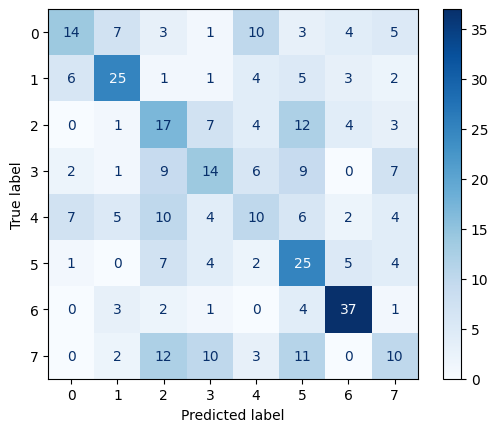

Time elapsed for epoch 104: 0:00:18.235126
Epoch 105/200, Batch 10/42, Loss: 0.9865
Epoch 105/200, Batch 20/42, Loss: 1.0582
Epoch 105/200, Batch 30/42, Loss: 1.1524
Epoch 105/200, Batch 40/42, Loss: 1.0934
Accuracy on images: 43.72%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46        47
           1       0.60      0.72      0.65        47
           2       0.33      0.29      0.31        48
           3       0.34      0.35      0.35        48
           4       0.32      0.23      0.27        48
           5       0.33      0.38      0.35        48
           6       0.72      0.71      0.72        48
           7       0.36      0.33      0.35        48

    accuracy                           0.44       382
   macro avg       0.43      0.44      0.43       382
weighted avg       0.43      0.44      0.43       382


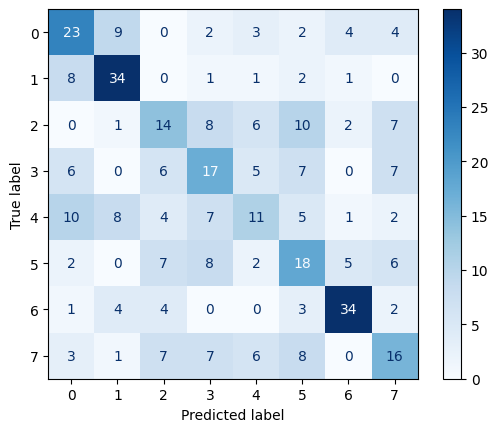

Time elapsed for epoch 105: 0:00:18.534193
Epoch 106/200, Batch 10/42, Loss: 1.1060
Epoch 106/200, Batch 20/42, Loss: 1.1093
Epoch 106/200, Batch 30/42, Loss: 1.1087
Epoch 106/200, Batch 40/42, Loss: 1.0576
Accuracy on images: 46.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.45      0.44        47
           1       0.55      0.57      0.56        47
           2       0.36      0.40      0.38        48
           3       0.41      0.35      0.38        48
           4       0.41      0.25      0.31        48
           5       0.38      0.58      0.46        48
           6       0.74      0.77      0.76        48
           7       0.42      0.33      0.37        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.46       382
weighted avg       0.46      0.46      0.46       382


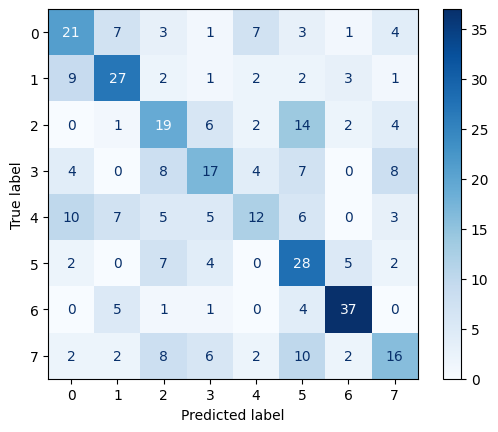

Time elapsed for epoch 106: 0:00:17.913053
Epoch 107/200, Batch 10/42, Loss: 0.9911
Epoch 107/200, Batch 20/42, Loss: 1.0128
Epoch 107/200, Batch 30/42, Loss: 1.0497
Epoch 107/200, Batch 40/42, Loss: 1.0514
Accuracy on images: 40.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        47
           1       0.57      0.57      0.57        47
           2       0.28      0.27      0.28        48
           3       0.33      0.29      0.31        48
           4       0.23      0.23      0.23        48
           5       0.36      0.44      0.40        48
           6       0.70      0.73      0.71        48
           7       0.30      0.27      0.28        48

    accuracy                           0.40       382
   macro avg       0.40      0.40      0.40       382
weighted avg       0.40      0.40      0.40       382


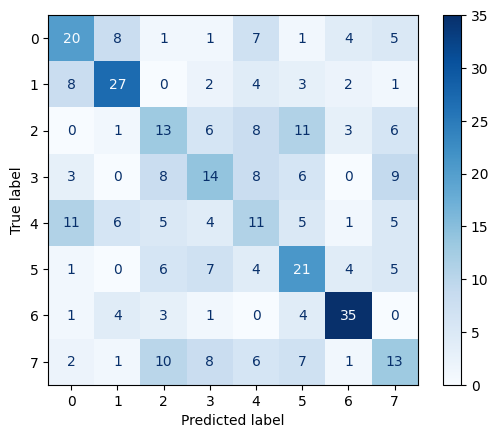

Time elapsed for epoch 107: 0:00:18.205118
Epoch 108/200, Batch 10/42, Loss: 1.1577
Epoch 108/200, Batch 20/42, Loss: 1.0717
Epoch 108/200, Batch 30/42, Loss: 0.9780
Epoch 108/200, Batch 40/42, Loss: 0.9852
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.51        47
           1       0.60      0.64      0.62        47
           2       0.33      0.33      0.33        48
           3       0.39      0.38      0.38        48
           4       0.29      0.17      0.21        48
           5       0.39      0.48      0.43        48
           6       0.73      0.77      0.75        48
           7       0.33      0.35      0.34        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.45       382
weighted avg       0.44      0.45      0.45       382


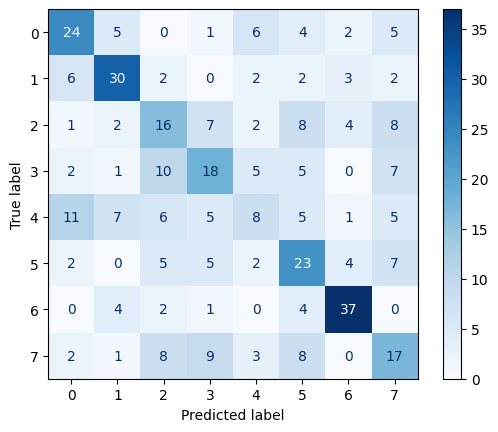

Time elapsed for epoch 108: 0:00:18.181114
Epoch 109/200, Batch 10/42, Loss: 0.9728
Epoch 109/200, Batch 20/42, Loss: 1.1422
Epoch 109/200, Batch 30/42, Loss: 1.0807
Epoch 109/200, Batch 40/42, Loss: 1.1237
Accuracy on images: 45.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46        47
           1       0.54      0.62      0.57        47
           2       0.37      0.33      0.35        48
           3       0.38      0.38      0.38        48
           4       0.33      0.17      0.22        48
           5       0.44      0.54      0.49        48
           6       0.74      0.73      0.74        48
           7       0.36      0.44      0.40        48

    accuracy                           0.46       382
   macro avg       0.45      0.46      0.45       382
weighted avg       0.45      0.46      0.45       382


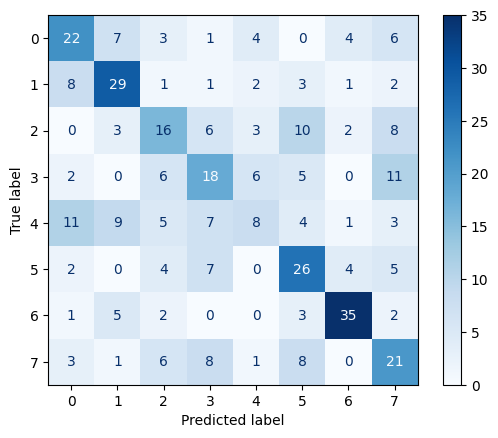

Time elapsed for epoch 109: 0:00:18.805254
Epoch 110/200, Batch 10/42, Loss: 1.0050
Epoch 110/200, Batch 20/42, Loss: 1.0220
Epoch 110/200, Batch 30/42, Loss: 1.1270
Epoch 110/200, Batch 40/42, Loss: 1.1723
Accuracy on images: 48.17%
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.57      0.57        47
           1       0.59      0.72      0.65        47
           2       0.37      0.31      0.34        48
           3       0.36      0.42      0.39        48
           4       0.58      0.15      0.23        48
           5       0.39      0.65      0.48        48
           6       0.73      0.73      0.73        48
           7       0.38      0.31      0.34        48

    accuracy                           0.48       382
   macro avg       0.49      0.48      0.47       382
weighted avg       0.49      0.48      0.47       382


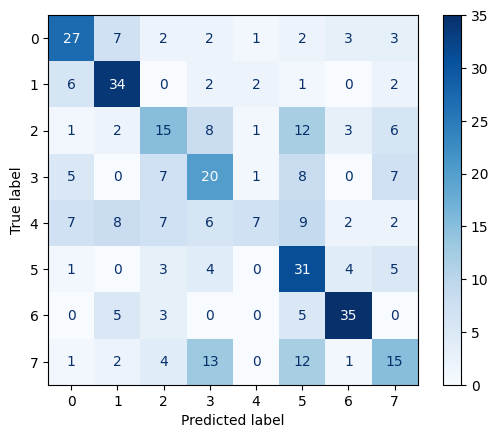

Time elapsed for epoch 110: 0:00:18.071089
Epoch 111/200, Batch 10/42, Loss: 1.0649
Epoch 111/200, Batch 20/42, Loss: 1.0729
Epoch 111/200, Batch 30/42, Loss: 1.0477
Epoch 111/200, Batch 40/42, Loss: 1.0090
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.30      0.34        47
           1       0.55      0.70      0.62        47
           2       0.35      0.31      0.33        48
           3       0.37      0.33      0.35        48
           4       0.36      0.29      0.32        48
           5       0.44      0.56      0.49        48
           6       0.77      0.75      0.76        48
           7       0.33      0.35      0.34        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


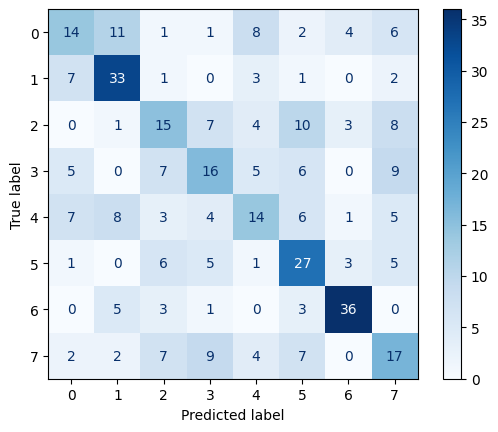

Time elapsed for epoch 111: 0:00:18.257131
Epoch 112/200, Batch 10/42, Loss: 0.9187
Epoch 112/200, Batch 20/42, Loss: 0.9867
Epoch 112/200, Batch 30/42, Loss: 1.0303
Epoch 112/200, Batch 40/42, Loss: 1.0972
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45        47
           1       0.56      0.68      0.62        47
           2       0.32      0.25      0.28        48
           3       0.36      0.42      0.38        48
           4       0.36      0.21      0.26        48
           5       0.41      0.60      0.49        48
           6       0.72      0.81      0.76        48
           7       0.27      0.23      0.25        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


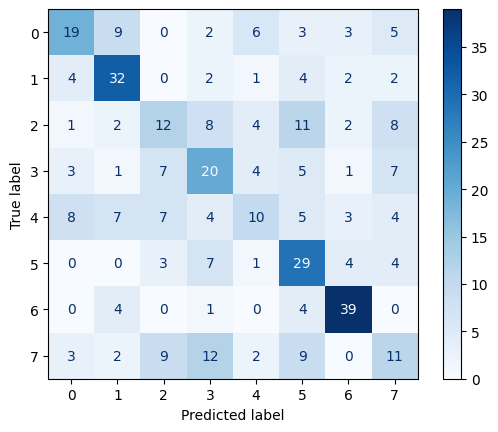

Time elapsed for epoch 112: 0:00:18.561199
Epoch 113/200, Batch 10/42, Loss: 0.9818
Epoch 113/200, Batch 20/42, Loss: 1.0524
Epoch 113/200, Batch 30/42, Loss: 1.0772
Epoch 113/200, Batch 40/42, Loss: 0.9792
Accuracy on images: 45.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.49      0.47        47
           1       0.57      0.62      0.59        47
           2       0.34      0.27      0.30        48
           3       0.38      0.31      0.34        48
           4       0.39      0.23      0.29        48
           5       0.44      0.67      0.53        48
           6       0.76      0.73      0.74        48
           7       0.30      0.35      0.32        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.45       382
weighted avg       0.45      0.46      0.45       382


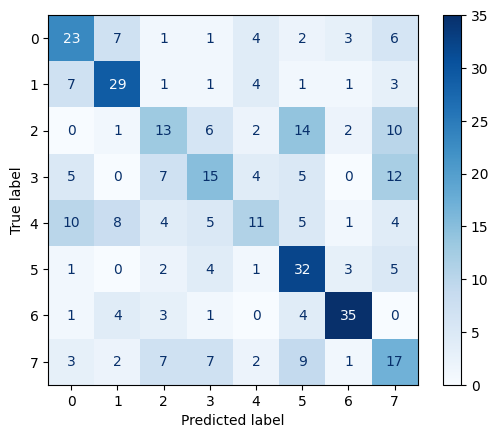

Time elapsed for epoch 113: 0:00:18.430171
Epoch 114/200, Batch 10/42, Loss: 0.9695
Epoch 114/200, Batch 20/42, Loss: 0.9595
Epoch 114/200, Batch 30/42, Loss: 1.0094
Epoch 114/200, Batch 40/42, Loss: 1.0093
Accuracy on images: 42.15%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.34      0.38        47
           1       0.54      0.62      0.57        47
           2       0.28      0.33      0.30        48
           3       0.33      0.29      0.31        48
           4       0.30      0.23      0.26        48
           5       0.43      0.56      0.49        48
           6       0.79      0.71      0.75        48
           7       0.29      0.29      0.29        48

    accuracy                           0.42       382
   macro avg       0.42      0.42      0.42       382
weighted avg       0.42      0.42      0.42       382


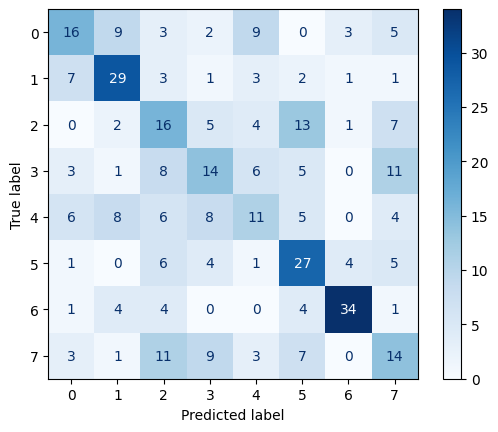

Time elapsed for epoch 114: 0:00:18.841262
Epoch 115/200, Batch 10/42, Loss: 0.9974
Epoch 115/200, Batch 20/42, Loss: 1.0098
Epoch 115/200, Batch 30/42, Loss: 1.1714
Epoch 115/200, Batch 40/42, Loss: 1.0968
Accuracy on images: 46.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.51      0.48        47
           1       0.54      0.68      0.60        47
           2       0.33      0.33      0.33        48
           3       0.37      0.44      0.40        48
           4       0.48      0.21      0.29        48
           5       0.43      0.52      0.47        48
           6       0.71      0.83      0.77        48
           7       0.35      0.23      0.28        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.45       382
weighted avg       0.46      0.47      0.45       382


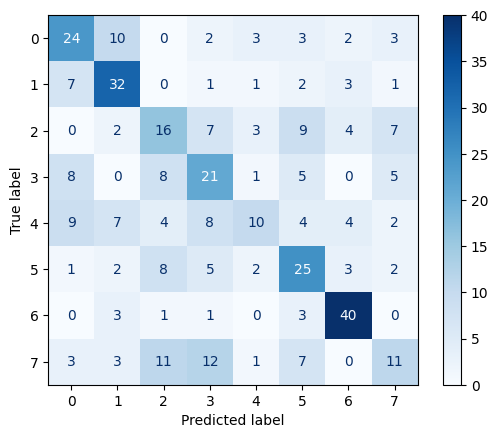

Time elapsed for epoch 115: 0:00:18.183113
Epoch 116/200, Batch 10/42, Loss: 1.0104
Epoch 116/200, Batch 20/42, Loss: 1.0432
Epoch 116/200, Batch 30/42, Loss: 1.0150
Epoch 116/200, Batch 40/42, Loss: 1.1275
Accuracy on images: 46.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42        47
           1       0.54      0.74      0.62        47
           2       0.36      0.42      0.38        48
           3       0.41      0.35      0.38        48
           4       0.41      0.19      0.26        48
           5       0.44      0.48      0.46        48
           6       0.65      0.85      0.74        48
           7       0.34      0.31      0.33        48

    accuracy                           0.47       382
   macro avg       0.45      0.47      0.45       382
weighted avg       0.45      0.47      0.45       382


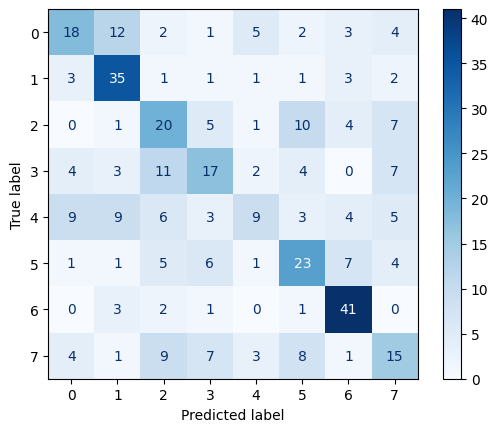

Time elapsed for epoch 116: 0:00:18.185114
Epoch 117/200, Batch 10/42, Loss: 0.9982
Epoch 117/200, Batch 20/42, Loss: 1.0713
Epoch 117/200, Batch 30/42, Loss: 1.0471
Epoch 117/200, Batch 40/42, Loss: 1.1521
Accuracy on images: 46.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50        47
           1       0.59      0.72      0.65        47
           2       0.31      0.33      0.32        48
           3       0.42      0.38      0.40        48
           4       0.48      0.25      0.33        48
           5       0.46      0.46      0.46        48
           6       0.69      0.73      0.71        48
           7       0.30      0.38      0.33        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.46       382
weighted avg       0.47      0.47      0.46       382


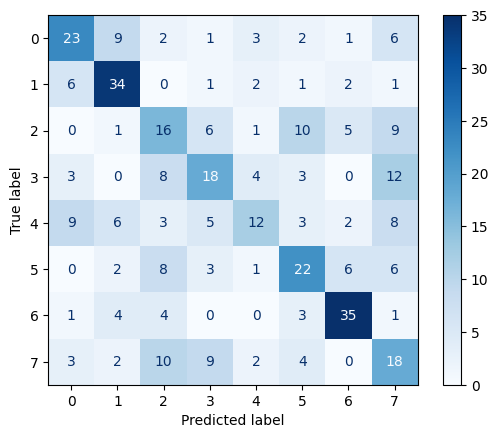

Time elapsed for epoch 117: 0:00:18.170111
Epoch 118/200, Batch 10/42, Loss: 1.0807
Epoch 118/200, Batch 20/42, Loss: 1.0131
Epoch 118/200, Batch 30/42, Loss: 0.9836
Epoch 118/200, Batch 40/42, Loss: 1.0092
Accuracy on images: 44.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.45      0.49        47
           1       0.58      0.64      0.61        47
           2       0.32      0.35      0.34        48
           3       0.34      0.35      0.35        48
           4       0.36      0.19      0.25        48
           5       0.39      0.60      0.48        48
           6       0.74      0.73      0.74        48
           7       0.26      0.23      0.24        48

    accuracy                           0.44       382
   macro avg       0.44      0.44      0.44       382
weighted avg       0.44      0.44      0.43       382


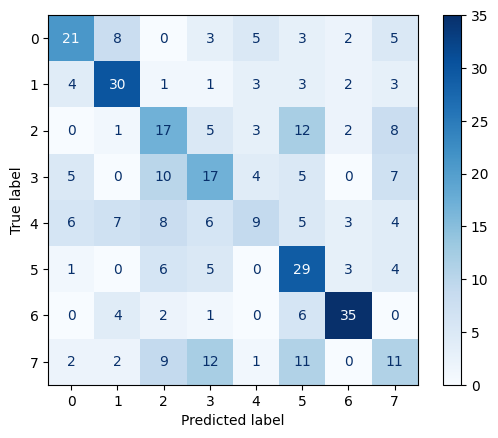

Time elapsed for epoch 118: 0:00:18.650220
Epoch 119/200, Batch 10/42, Loss: 1.0924
Epoch 119/200, Batch 20/42, Loss: 1.0353
Epoch 119/200, Batch 30/42, Loss: 0.9697
Epoch 119/200, Batch 40/42, Loss: 1.0336
Accuracy on images: 47.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        47
           1       0.62      0.66      0.64        47
           2       0.39      0.40      0.39        48
           3       0.33      0.35      0.34        48
           4       0.39      0.27      0.32        48
           5       0.43      0.42      0.43        48
           6       0.70      0.77      0.73        48
           7       0.35      0.38      0.36        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.47       382
weighted avg       0.47      0.47      0.47       382


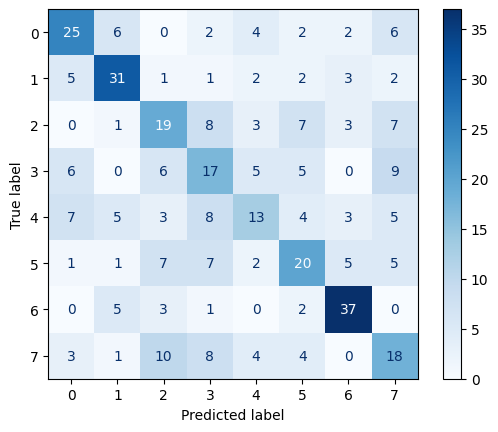

Time elapsed for epoch 119: 0:00:18.369156
Epoch 120/200, Batch 10/42, Loss: 0.9747
Epoch 120/200, Batch 20/42, Loss: 0.9547
Epoch 120/200, Batch 30/42, Loss: 0.9453
Epoch 120/200, Batch 40/42, Loss: 1.0030
Accuracy on images: 46.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.30      0.35        47
           1       0.51      0.79      0.62        47
           2       0.41      0.40      0.40        48
           3       0.34      0.33      0.34        48
           4       0.36      0.31      0.33        48
           5       0.47      0.50      0.48        48
           6       0.80      0.75      0.77        48
           7       0.35      0.33      0.34        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.46       382
weighted avg       0.46      0.46      0.46       382


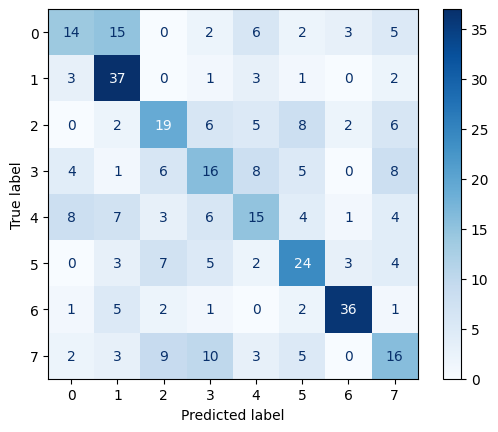

Time elapsed for epoch 120: 0:00:17.963064
Epoch 121/200, Batch 10/42, Loss: 1.0029
Epoch 121/200, Batch 20/42, Loss: 1.0690
Epoch 121/200, Batch 30/42, Loss: 0.9577
Epoch 121/200, Batch 40/42, Loss: 0.9997
Accuracy on images: 47.38%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        47
           1       0.56      0.74      0.64        47
           2       0.36      0.33      0.35        48
           3       0.38      0.46      0.42        48
           4       0.44      0.17      0.24        48
           5       0.47      0.52      0.50        48
           6       0.78      0.73      0.75        48
           7       0.33      0.40      0.36        48

    accuracy                           0.47       382
   macro avg       0.48      0.47      0.46       382
weighted avg       0.47      0.47      0.46       382


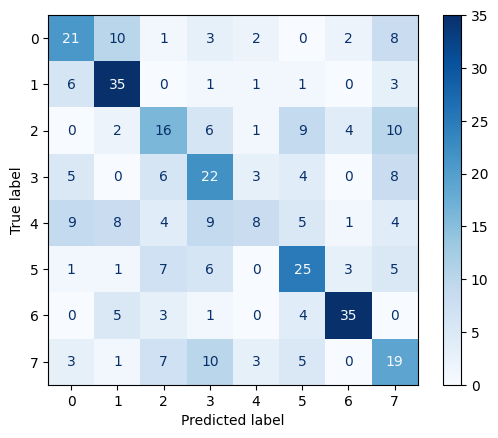

Time elapsed for epoch 121: 0:00:18.074089
Epoch 122/200, Batch 10/42, Loss: 0.9974
Epoch 122/200, Batch 20/42, Loss: 1.0659
Epoch 122/200, Batch 30/42, Loss: 0.9911
Epoch 122/200, Batch 40/42, Loss: 1.0499
Accuracy on images: 44.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.51      0.46        47
           1       0.57      0.70      0.63        47
           2       0.33      0.27      0.30        48
           3       0.38      0.38      0.38        48
           4       0.32      0.21      0.25        48
           5       0.36      0.56      0.44        48
           6       0.78      0.73      0.75        48
           7       0.32      0.21      0.25        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.43       382
weighted avg       0.44      0.45      0.43       382


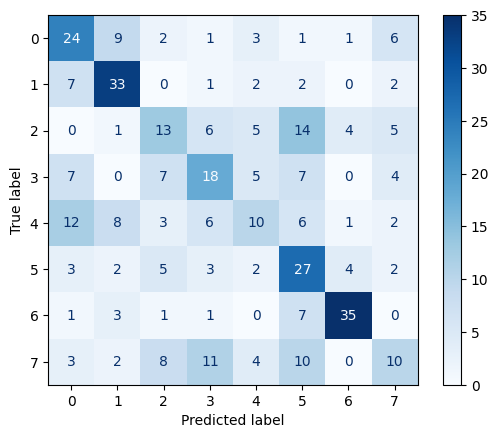

Time elapsed for epoch 122: 0:00:18.750243
Epoch 123/200, Batch 10/42, Loss: 0.9598
Epoch 123/200, Batch 20/42, Loss: 1.1092
Epoch 123/200, Batch 30/42, Loss: 1.0885
Epoch 123/200, Batch 40/42, Loss: 1.0164
Accuracy on images: 46.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        47
           1       0.59      0.64      0.61        47
           2       0.36      0.42      0.39        48
           3       0.35      0.31      0.33        48
           4       0.39      0.27      0.32        48
           5       0.48      0.50      0.49        48
           6       0.73      0.75      0.74        48
           7       0.30      0.38      0.33        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.46       382
weighted avg       0.46      0.46      0.46       382


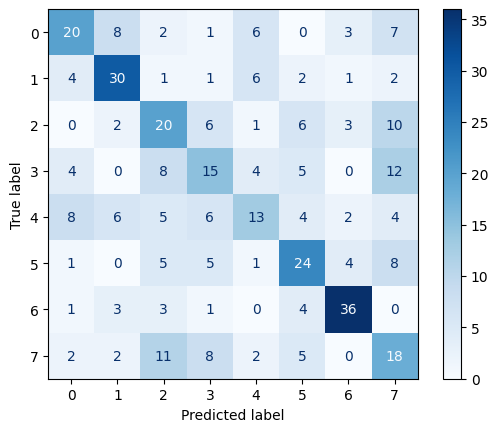

Time elapsed for epoch 123: 0:00:18.061086
Epoch 124/200, Batch 10/42, Loss: 0.9962
Epoch 124/200, Batch 20/42, Loss: 1.0346
Epoch 124/200, Batch 30/42, Loss: 0.9889
Epoch 124/200, Batch 40/42, Loss: 0.9136
Accuracy on images: 43.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49        47
           1       0.60      0.68      0.64        47
           2       0.32      0.27      0.29        48
           3       0.33      0.35      0.34        48
           4       0.31      0.23      0.27        48
           5       0.40      0.56      0.47        48
           6       0.78      0.73      0.75        48
           7       0.23      0.21      0.22        48

    accuracy                           0.44       382
   macro avg       0.43      0.44      0.43       382
weighted avg       0.43      0.44      0.43       382


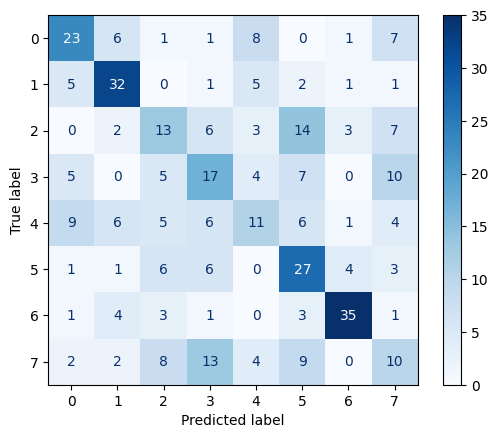

Time elapsed for epoch 124: 0:00:18.251129
Epoch 125/200, Batch 10/42, Loss: 1.0073
Epoch 125/200, Batch 20/42, Loss: 1.0162
Epoch 125/200, Batch 30/42, Loss: 0.9410
Epoch 125/200, Batch 40/42, Loss: 0.9769
Accuracy on images: 42.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46        47
           1       0.52      0.60      0.55        47
           2       0.29      0.25      0.27        48
           3       0.42      0.29      0.35        48
           4       0.22      0.10      0.14        48
           5       0.38      0.69      0.49        48
           6       0.62      0.77      0.69        48
           7       0.32      0.31      0.32        48

    accuracy                           0.43       382
   macro avg       0.41      0.43      0.41       382
weighted avg       0.41      0.43      0.41       382


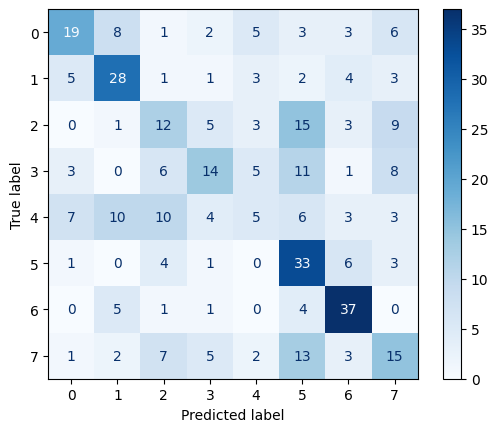

Time elapsed for epoch 125: 0:00:18.217122
Epoch 126/200, Batch 10/42, Loss: 1.0565
Epoch 126/200, Batch 20/42, Loss: 0.9141
Epoch 126/200, Batch 30/42, Loss: 1.1100
Epoch 126/200, Batch 40/42, Loss: 1.0237
Accuracy on images: 43.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41        47
           1       0.50      0.62      0.55        47
           2       0.34      0.25      0.29        48
           3       0.38      0.29      0.33        48
           4       0.39      0.23      0.29        48
           5       0.36      0.67      0.47        48
           6       0.80      0.67      0.73        48
           7       0.31      0.35      0.33        48

    accuracy                           0.43       382
   macro avg       0.44      0.43      0.42       382
weighted avg       0.44      0.43      0.42       382


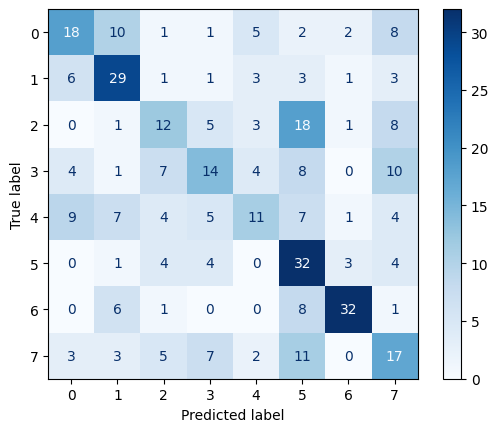

Time elapsed for epoch 126: 0:00:18.171111
Epoch 127/200, Batch 10/42, Loss: 1.0340
Epoch 127/200, Batch 20/42, Loss: 1.0348
Epoch 127/200, Batch 30/42, Loss: 0.9946
Epoch 127/200, Batch 40/42, Loss: 0.9890
Accuracy on images: 46.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.47      0.47        47
           1       0.61      0.64      0.62        47
           2       0.39      0.31      0.35        48
           3       0.34      0.44      0.39        48
           4       0.32      0.27      0.29        48
           5       0.49      0.42      0.45        48
           6       0.68      0.81      0.74        48
           7       0.35      0.35      0.35        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.46       382
weighted avg       0.46      0.46      0.46       382


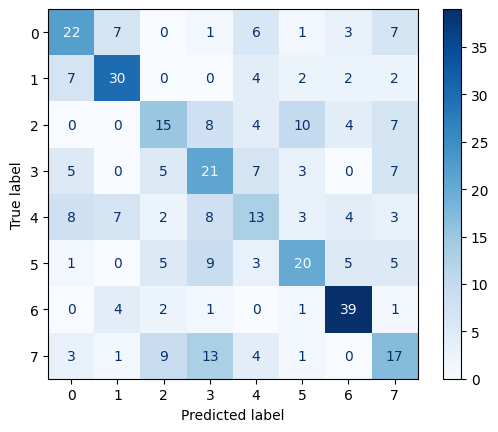

Time elapsed for epoch 127: 0:00:18.256131
Epoch 128/200, Batch 10/42, Loss: 1.0635
Epoch 128/200, Batch 20/42, Loss: 1.0111
Epoch 128/200, Batch 30/42, Loss: 0.9159
Epoch 128/200, Batch 40/42, Loss: 1.0668
Accuracy on images: 42.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.30      0.36        47
           1       0.50      0.70      0.58        47
           2       0.26      0.27      0.27        48
           3       0.36      0.31      0.33        48
           4       0.41      0.29      0.34        48
           5       0.38      0.56      0.45        48
           6       0.78      0.73      0.75        48
           7       0.27      0.25      0.26        48

    accuracy                           0.43       382
   macro avg       0.43      0.43      0.42       382
weighted avg       0.43      0.43      0.42       382


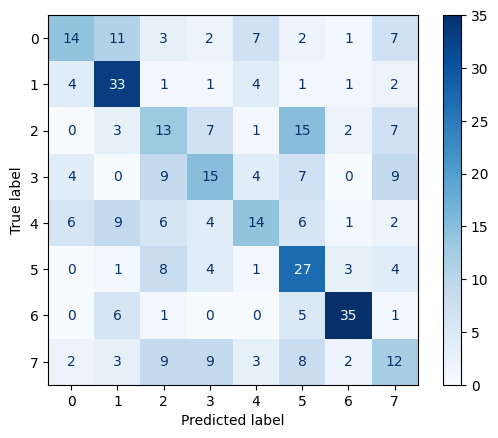

Time elapsed for epoch 128: 0:00:18.287137
Epoch 129/200, Batch 10/42, Loss: 0.9509
Epoch 129/200, Batch 20/42, Loss: 0.9243
Epoch 129/200, Batch 30/42, Loss: 0.9924
Epoch 129/200, Batch 40/42, Loss: 0.9632
Accuracy on images: 43.72%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.47      0.44        47
           1       0.57      0.60      0.58        47
           2       0.31      0.31      0.31        48
           3       0.34      0.33      0.34        48
           4       0.38      0.23      0.29        48
           5       0.38      0.54      0.45        48
           6       0.72      0.75      0.73        48
           7       0.34      0.27      0.30        48

    accuracy                           0.44       382
   macro avg       0.43      0.44      0.43       382
weighted avg       0.43      0.44      0.43       382


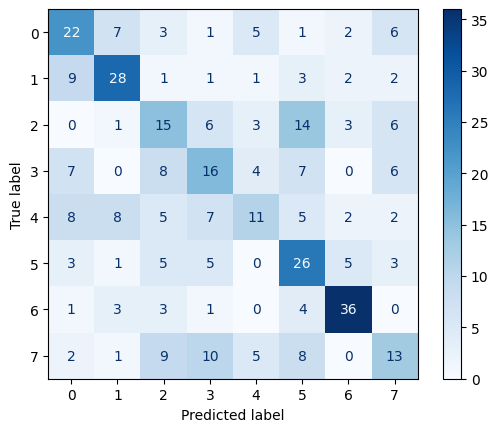

Time elapsed for epoch 129: 0:00:17.997072
Epoch 130/200, Batch 10/42, Loss: 0.8861
Epoch 130/200, Batch 20/42, Loss: 1.0490
Epoch 130/200, Batch 30/42, Loss: 0.9648
Epoch 130/200, Batch 40/42, Loss: 1.0171
Accuracy on images: 46.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.55      0.53        47
           1       0.57      0.68      0.62        47
           2       0.26      0.31      0.29        48
           3       0.41      0.31      0.35        48
           4       0.41      0.25      0.31        48
           5       0.44      0.54      0.49        48
           6       0.75      0.75      0.75        48
           7       0.32      0.29      0.30        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.45       382
weighted avg       0.46      0.46      0.45       382


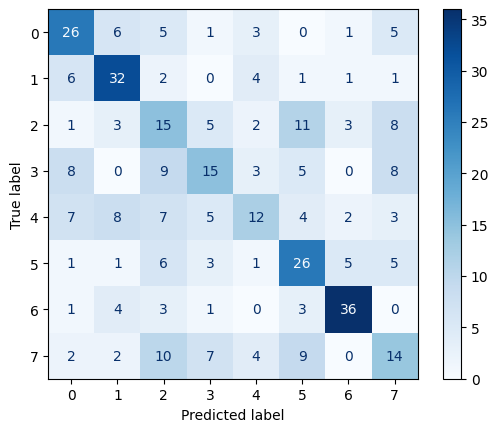

Time elapsed for epoch 130: 0:00:18.136103
Epoch 131/200, Batch 10/42, Loss: 1.0955
Epoch 131/200, Batch 20/42, Loss: 0.9650
Epoch 131/200, Batch 30/42, Loss: 0.9730
Epoch 131/200, Batch 40/42, Loss: 0.9640
Accuracy on images: 45.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.45      0.45        47
           1       0.52      0.68      0.59        47
           2       0.31      0.29      0.30        48
           3       0.39      0.33      0.36        48
           4       0.33      0.23      0.27        48
           5       0.42      0.58      0.49        48
           6       0.80      0.77      0.79        48
           7       0.37      0.31      0.34        48

    accuracy                           0.46       382
   macro avg       0.45      0.46      0.45       382
weighted avg       0.45      0.46      0.45       382


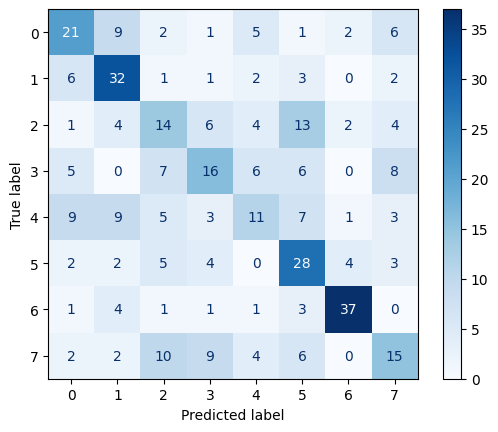

Time elapsed for epoch 131: 0:00:18.085092
Epoch 132/200, Batch 10/42, Loss: 0.9933
Epoch 132/200, Batch 20/42, Loss: 0.9472
Epoch 132/200, Batch 30/42, Loss: 1.1072
Epoch 132/200, Batch 40/42, Loss: 1.0319
Accuracy on images: 42.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.30      0.33        47
           1       0.52      0.60      0.55        47
           2       0.32      0.38      0.34        48
           3       0.36      0.31      0.33        48
           4       0.35      0.19      0.24        48
           5       0.38      0.50      0.43        48
           6       0.77      0.77      0.77        48
           7       0.33      0.35      0.34        48

    accuracy                           0.42       382
   macro avg       0.42      0.42      0.42       382
weighted avg       0.42      0.42      0.42       382


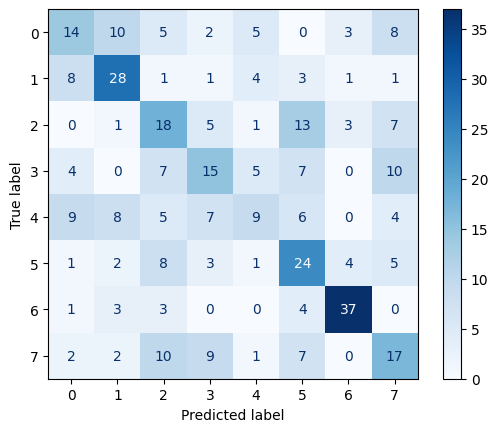

Time elapsed for epoch 132: 0:00:18.079090
Epoch 133/200, Batch 10/42, Loss: 0.9653
Epoch 133/200, Batch 20/42, Loss: 0.9307
Epoch 133/200, Batch 30/42, Loss: 0.9769
Epoch 133/200, Batch 40/42, Loss: 1.0453
Accuracy on images: 43.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        47
           1       0.58      0.66      0.62        47
           2       0.26      0.33      0.29        48
           3       0.41      0.40      0.40        48
           4       0.36      0.17      0.23        48
           5       0.41      0.46      0.43        48
           6       0.77      0.75      0.76        48
           7       0.35      0.38      0.36        48

    accuracy                           0.44       382
   macro avg       0.44      0.44      0.43       382
weighted avg       0.44      0.44      0.43       382


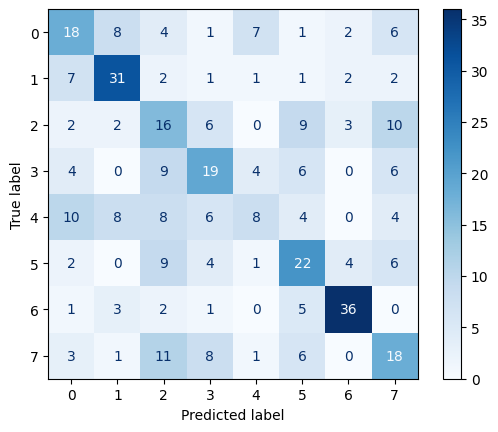

Time elapsed for epoch 133: 0:00:18.105097
Epoch 134/200, Batch 10/42, Loss: 0.9501
Epoch 134/200, Batch 20/42, Loss: 1.0363
Epoch 134/200, Batch 30/42, Loss: 0.9942
Epoch 134/200, Batch 40/42, Loss: 0.9523
Accuracy on images: 46.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42        47
           1       0.60      0.72      0.65        47
           2       0.31      0.35      0.33        48
           3       0.45      0.38      0.41        48
           4       0.32      0.15      0.20        48
           5       0.41      0.58      0.48        48
           6       0.66      0.81      0.73        48
           7       0.38      0.33      0.36        48

    accuracy                           0.46       382
   macro avg       0.45      0.46      0.45       382
weighted avg       0.45      0.46      0.45       382


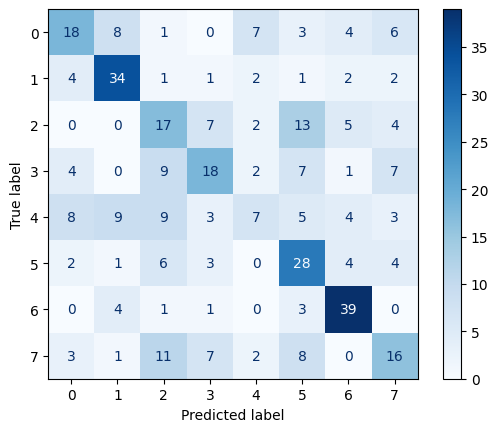

Time elapsed for epoch 134: 0:00:18.162109
Epoch 135/200, Batch 10/42, Loss: 0.9401
Epoch 135/200, Batch 20/42, Loss: 0.9584
Epoch 135/200, Batch 30/42, Loss: 0.9133
Epoch 135/200, Batch 40/42, Loss: 1.0782
Accuracy on images: 46.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.50        47
           1       0.60      0.66      0.63        47
           2       0.41      0.29      0.34        48
           3       0.38      0.42      0.40        48
           4       0.33      0.17      0.22        48
           5       0.39      0.62      0.48        48
           6       0.83      0.73      0.78        48
           7       0.28      0.27      0.27        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.45       382
weighted avg       0.46      0.46      0.45       382


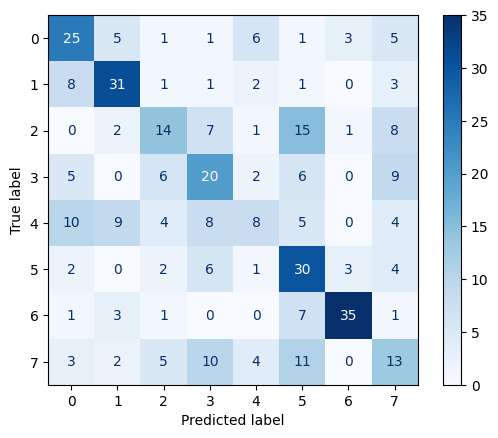

Time elapsed for epoch 135: 0:00:18.282135
Epoch 136/200, Batch 10/42, Loss: 0.9082
Epoch 136/200, Batch 20/42, Loss: 1.0092
Epoch 136/200, Batch 30/42, Loss: 0.9647
Epoch 136/200, Batch 40/42, Loss: 0.9555
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.32      0.34        47
           1       0.53      0.77      0.63        47
           2       0.36      0.46      0.40        48
           3       0.37      0.29      0.33        48
           4       0.33      0.19      0.24        48
           5       0.47      0.52      0.50        48
           6       0.67      0.79      0.72        48
           7       0.39      0.29      0.33        48

    accuracy                           0.45       382
   macro avg       0.43      0.45      0.44       382
weighted avg       0.43      0.45      0.44       382


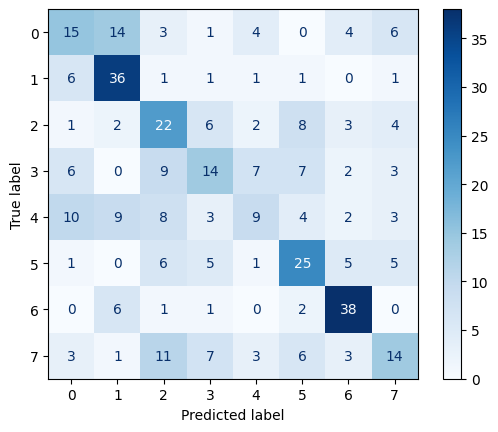

Time elapsed for epoch 136: 0:00:18.041083
Epoch 137/200, Batch 10/42, Loss: 1.0008
Epoch 137/200, Batch 20/42, Loss: 0.9214
Epoch 137/200, Batch 30/42, Loss: 0.9394
Epoch 137/200, Batch 40/42, Loss: 1.0066
Accuracy on images: 47.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.46        47
           1       0.54      0.64      0.58        47
           2       0.31      0.35      0.33        48
           3       0.48      0.46      0.47        48
           4       0.43      0.19      0.26        48
           5       0.42      0.56      0.48        48
           6       0.72      0.79      0.75        48
           7       0.38      0.31      0.34        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.46       382
weighted avg       0.47      0.47      0.46       382


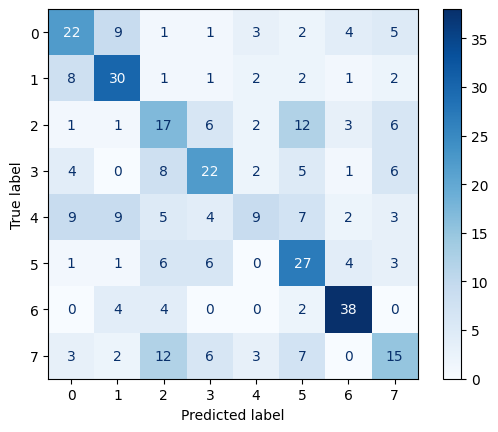

Time elapsed for epoch 137: 0:00:17.958062
Epoch 138/200, Batch 10/42, Loss: 0.9524
Epoch 138/200, Batch 20/42, Loss: 0.9602
Epoch 138/200, Batch 30/42, Loss: 0.9578
Epoch 138/200, Batch 40/42, Loss: 0.9468
Accuracy on images: 47.38%
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.47      0.44        47
           1       0.56      0.66      0.61        47
           2       0.38      0.35      0.37        48
           3       0.41      0.33      0.37        48
           4       0.33      0.21      0.26        48
           5       0.47      0.56      0.51        48
           6       0.72      0.81      0.76        48
           7       0.40      0.40      0.40        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.46       382
weighted avg       0.46      0.47      0.46       382


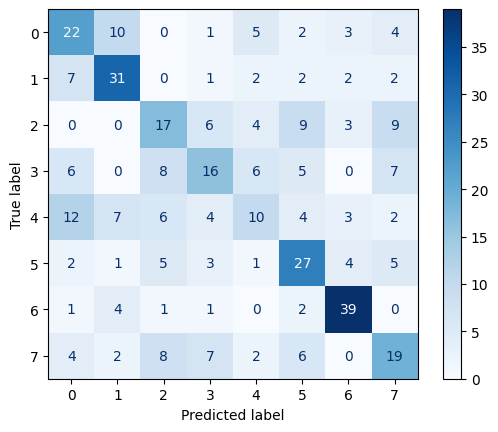

Time elapsed for epoch 138: 0:00:18.385159
Epoch 139/200, Batch 10/42, Loss: 0.9499
Epoch 139/200, Batch 20/42, Loss: 0.9640
Epoch 139/200, Batch 30/42, Loss: 0.8507
Epoch 139/200, Batch 40/42, Loss: 0.9498
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        47
           1       0.49      0.68      0.57        47
           2       0.35      0.27      0.31        48
           3       0.41      0.38      0.39        48
           4       0.31      0.23      0.26        48
           5       0.41      0.62      0.50        48
           6       0.70      0.79      0.75        48
           7       0.31      0.25      0.28        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.43       382
weighted avg       0.43      0.45      0.43       382


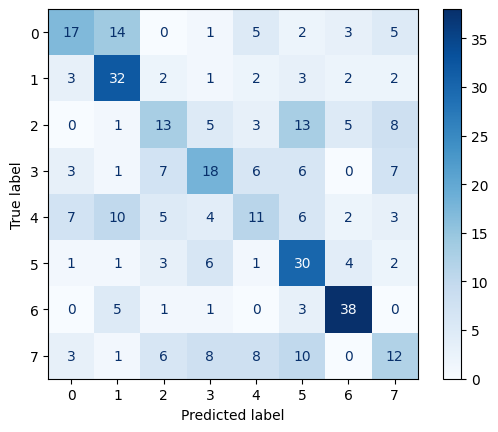

Time elapsed for epoch 139: 0:00:18.544196
Epoch 140/200, Batch 10/42, Loss: 0.9934
Epoch 140/200, Batch 20/42, Loss: 1.0049
Epoch 140/200, Batch 30/42, Loss: 1.0081
Epoch 140/200, Batch 40/42, Loss: 0.9756
Accuracy on images: 43.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.40      0.37        47
           1       0.54      0.57      0.56        47
           2       0.32      0.31      0.32        48
           3       0.38      0.38      0.38        48
           4       0.33      0.15      0.20        48
           5       0.43      0.54      0.48        48
           6       0.68      0.83      0.75        48
           7       0.32      0.27      0.29        48

    accuracy                           0.43       382
   macro avg       0.42      0.43      0.42       382
weighted avg       0.42      0.43      0.42       382


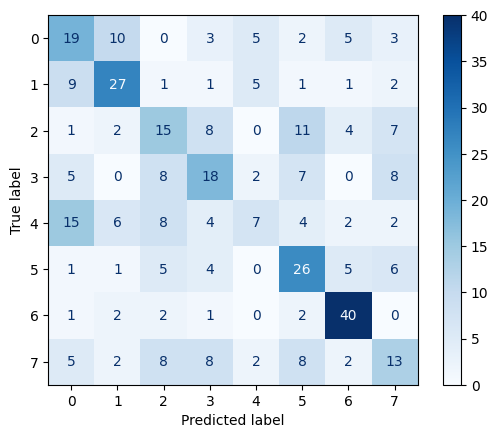

Time elapsed for epoch 140: 0:00:17.895048
Epoch 141/200, Batch 10/42, Loss: 0.9935
Epoch 141/200, Batch 20/42, Loss: 1.0547
Epoch 141/200, Batch 30/42, Loss: 0.9305
Epoch 141/200, Batch 40/42, Loss: 0.9299
Accuracy on images: 46.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.38      0.44        47
           1       0.53      0.68      0.60        47
           2       0.37      0.40      0.38        48
           3       0.36      0.33      0.34        48
           4       0.37      0.29      0.33        48
           5       0.44      0.56      0.49        48
           6       0.78      0.75      0.77        48
           7       0.35      0.33      0.34        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.46       382
weighted avg       0.47      0.47      0.46       382


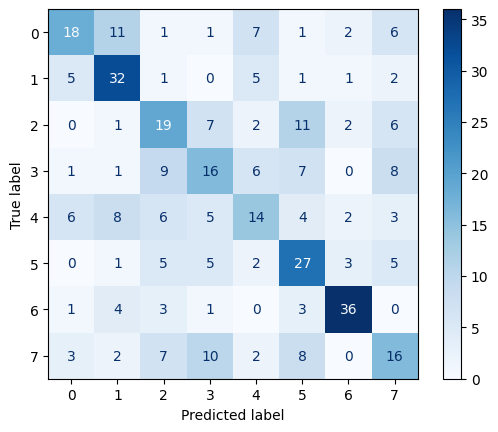

Time elapsed for epoch 141: 0:00:18.321146
Epoch 142/200, Batch 10/42, Loss: 1.0088
Epoch 142/200, Batch 20/42, Loss: 1.0230
Epoch 142/200, Batch 30/42, Loss: 0.9730
Epoch 142/200, Batch 40/42, Loss: 0.9082
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        47
           1       0.56      0.74      0.64        47
           2       0.40      0.25      0.31        48
           3       0.32      0.31      0.32        48
           4       0.32      0.27      0.29        48
           5       0.40      0.62      0.49        48
           6       0.80      0.73      0.76        48
           7       0.34      0.29      0.31        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.44       382
weighted avg       0.45      0.45      0.44       382


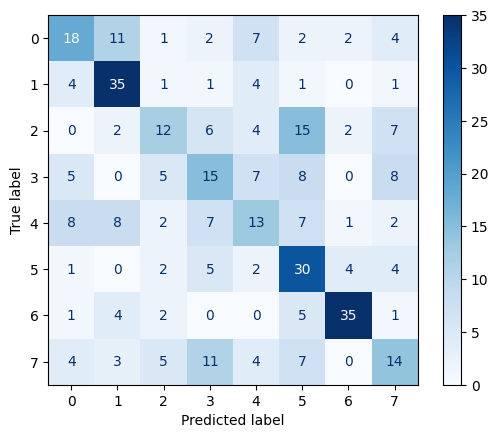

Time elapsed for epoch 142: 0:00:18.156109
Epoch 143/200, Batch 10/42, Loss: 0.9271
Epoch 143/200, Batch 20/42, Loss: 0.9842
Epoch 143/200, Batch 30/42, Loss: 0.8845
Epoch 143/200, Batch 40/42, Loss: 0.9541
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.51      0.47        47
           1       0.53      0.60      0.56        47
           2       0.30      0.27      0.28        48
           3       0.42      0.33      0.37        48
           4       0.41      0.19      0.26        48
           5       0.43      0.62      0.51        48
           6       0.66      0.77      0.71        48
           7       0.36      0.33      0.34        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


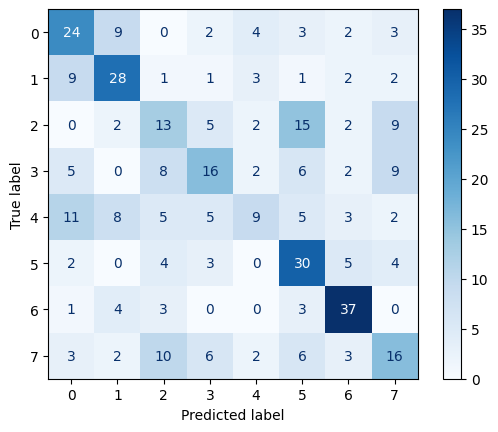

Time elapsed for epoch 143: 0:00:18.339149
Epoch 144/200, Batch 10/42, Loss: 0.9470
Epoch 144/200, Batch 20/42, Loss: 0.8837
Epoch 144/200, Batch 30/42, Loss: 1.0819
Epoch 144/200, Batch 40/42, Loss: 0.9460
Accuracy on images: 46.34%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43        47
           1       0.52      0.72      0.61        47
           2       0.44      0.29      0.35        48
           3       0.36      0.44      0.40        48
           4       0.50      0.23      0.31        48
           5       0.44      0.50      0.47        48
           6       0.76      0.71      0.73        48
           7       0.32      0.42      0.36        48

    accuracy                           0.46       382
   macro avg       0.47      0.46      0.46       382
weighted avg       0.47      0.46      0.46       382


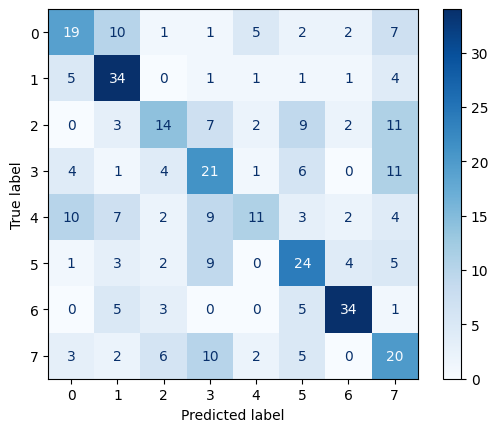

Time elapsed for epoch 144: 0:00:18.256129
Epoch 145/200, Batch 10/42, Loss: 0.8693
Epoch 145/200, Batch 20/42, Loss: 0.9413
Epoch 145/200, Batch 30/42, Loss: 0.9834
Epoch 145/200, Batch 40/42, Loss: 0.9773
Accuracy on images: 47.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.50        47
           1       0.56      0.64      0.59        47
           2       0.32      0.25      0.28        48
           3       0.35      0.33      0.34        48
           4       0.48      0.23      0.31        48
           5       0.48      0.67      0.56        48
           6       0.74      0.77      0.76        48
           7       0.33      0.35      0.34        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.46       382
weighted avg       0.46      0.47      0.46       382


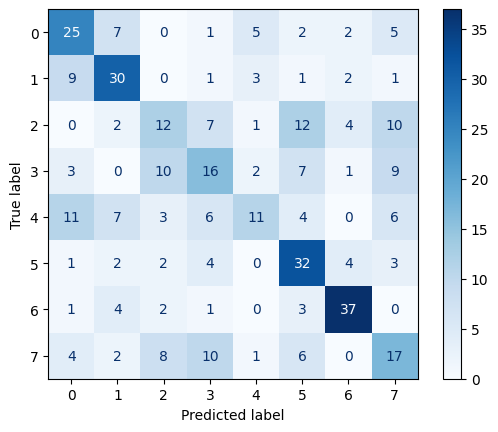

Time elapsed for epoch 145: 0:00:18.382159
Epoch 146/200, Batch 10/42, Loss: 0.8557
Epoch 146/200, Batch 20/42, Loss: 0.9394
Epoch 146/200, Batch 30/42, Loss: 0.9583
Epoch 146/200, Batch 40/42, Loss: 0.9300
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48        47
           1       0.57      0.62      0.59        47
           2       0.29      0.29      0.29        48
           3       0.41      0.35      0.38        48
           4       0.38      0.25      0.30        48
           5       0.41      0.62      0.50        48
           6       0.71      0.75      0.73        48
           7       0.32      0.29      0.30        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.45       382
weighted avg       0.45      0.45      0.45       382


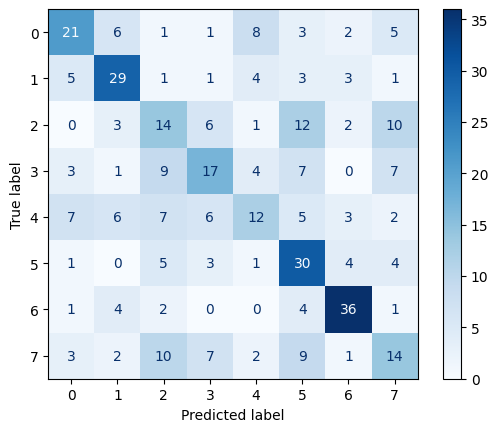

Time elapsed for epoch 146: 0:00:17.875044
Epoch 147/200, Batch 10/42, Loss: 0.9172
Epoch 147/200, Batch 20/42, Loss: 0.8611
Epoch 147/200, Batch 30/42, Loss: 0.9138
Epoch 147/200, Batch 40/42, Loss: 0.8968
Accuracy on images: 44.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43        47
           1       0.53      0.49      0.51        47
           2       0.35      0.29      0.32        48
           3       0.37      0.40      0.38        48
           4       0.38      0.25      0.30        48
           5       0.39      0.60      0.48        48
           6       0.70      0.77      0.73        48
           7       0.37      0.35      0.36        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


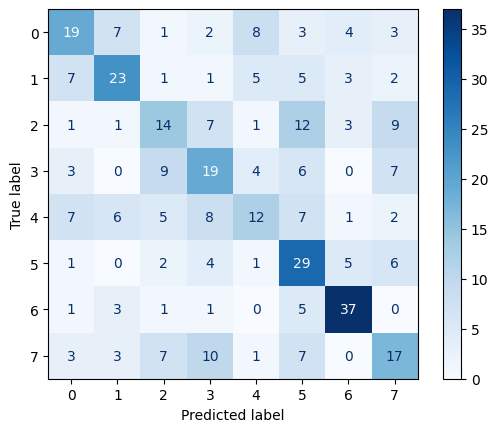

Time elapsed for epoch 147: 0:00:18.067088
Epoch 148/200, Batch 10/42, Loss: 0.8496
Epoch 148/200, Batch 20/42, Loss: 0.8917
Epoch 148/200, Batch 30/42, Loss: 0.9285
Epoch 148/200, Batch 40/42, Loss: 0.9908
Accuracy on images: 47.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.53      0.48        47
           1       0.59      0.62      0.60        47
           2       0.33      0.33      0.33        48
           3       0.39      0.35      0.37        48
           4       0.38      0.19      0.25        48
           5       0.45      0.65      0.53        48
           6       0.70      0.79      0.75        48
           7       0.41      0.31      0.35        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.46       382
weighted avg       0.46      0.47      0.46       382


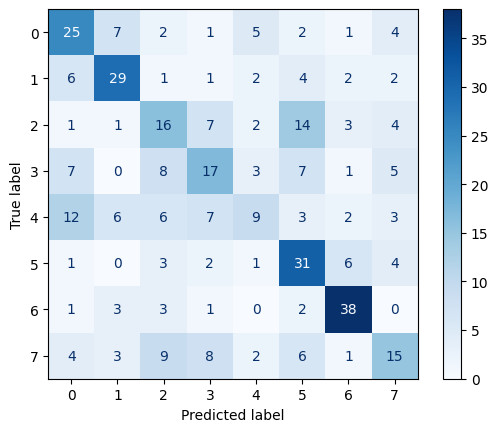

Time elapsed for epoch 148: 0:00:18.361153
Epoch 149/200, Batch 10/42, Loss: 0.9360
Epoch 149/200, Batch 20/42, Loss: 0.9638
Epoch 149/200, Batch 30/42, Loss: 0.9484
Epoch 149/200, Batch 40/42, Loss: 1.0080
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.43      0.44        47
           1       0.55      0.66      0.60        47
           2       0.31      0.35      0.33        48
           3       0.37      0.31      0.34        48
           4       0.27      0.17      0.21        48
           5       0.48      0.62      0.54        48
           6       0.69      0.75      0.72        48
           7       0.37      0.33      0.35        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


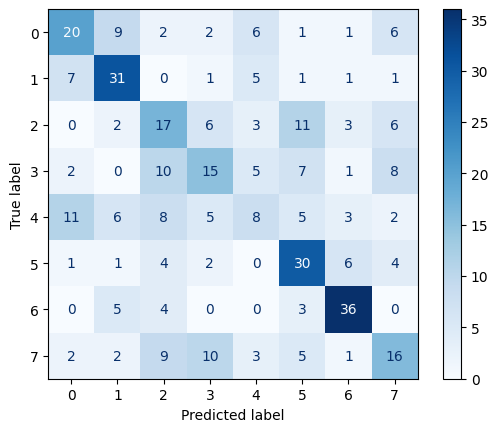

Time elapsed for epoch 149: 0:00:18.234126
Epoch 150/200, Batch 10/42, Loss: 0.8610
Epoch 150/200, Batch 20/42, Loss: 0.9854
Epoch 150/200, Batch 30/42, Loss: 0.8533
Epoch 150/200, Batch 40/42, Loss: 0.9175
Accuracy on images: 46.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42        47
           1       0.55      0.60      0.57        47
           2       0.38      0.46      0.42        48
           3       0.36      0.33      0.35        48
           4       0.38      0.25      0.30        48
           5       0.47      0.56      0.51        48
           6       0.69      0.79      0.74        48
           7       0.33      0.31      0.32        48

    accuracy                           0.46       382
   macro avg       0.45      0.46      0.45       382
weighted avg       0.45      0.46      0.45       382


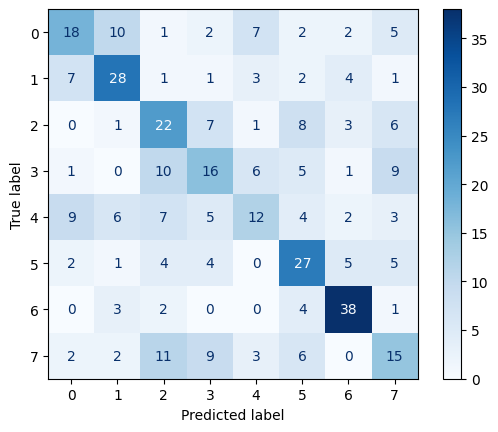

Time elapsed for epoch 150: 0:00:18.155108
Epoch 151/200, Batch 10/42, Loss: 0.9407
Epoch 151/200, Batch 20/42, Loss: 0.8923
Epoch 151/200, Batch 30/42, Loss: 1.0117
Epoch 151/200, Batch 40/42, Loss: 0.9347
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.45      0.45        47
           1       0.60      0.62      0.61        47
           2       0.33      0.35      0.34        48
           3       0.30      0.29      0.30        48
           4       0.32      0.23      0.27        48
           5       0.43      0.54      0.48        48
           6       0.76      0.73      0.74        48
           7       0.35      0.38      0.36        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.45       382
weighted avg       0.45      0.45      0.44       382


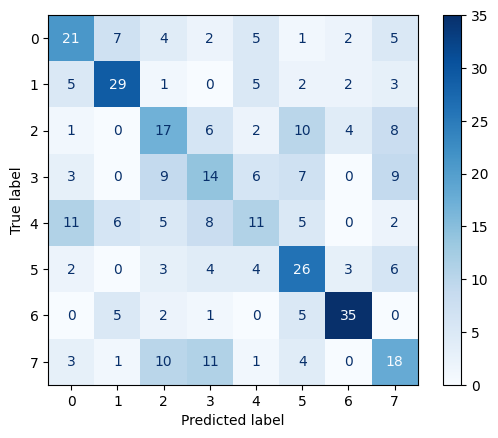

Time elapsed for epoch 151: 0:00:18.605210
Epoch 152/200, Batch 10/42, Loss: 0.9191
Epoch 152/200, Batch 20/42, Loss: 0.9491
Epoch 152/200, Batch 30/42, Loss: 0.9622
Epoch 152/200, Batch 40/42, Loss: 0.9510
Accuracy on images: 42.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.32      0.38        47
           1       0.50      0.66      0.57        47
           2       0.31      0.25      0.28        48
           3       0.33      0.29      0.31        48
           4       0.28      0.15      0.19        48
           5       0.39      0.65      0.48        48
           6       0.74      0.77      0.76        48
           7       0.31      0.33      0.32        48

    accuracy                           0.43       382
   macro avg       0.42      0.43      0.41       382
weighted avg       0.42      0.43      0.41       382


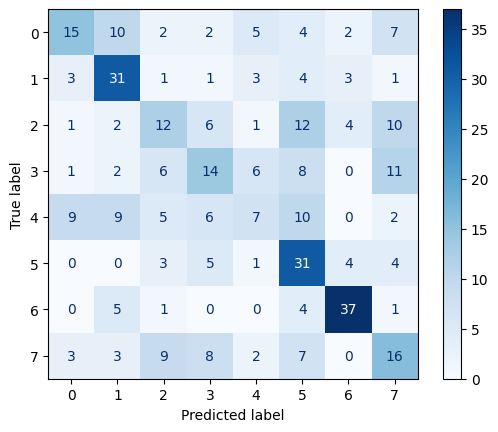

Time elapsed for epoch 152: 0:00:17.869043
Epoch 153/200, Batch 10/42, Loss: 0.8966
Epoch 153/200, Batch 20/42, Loss: 0.8590
Epoch 153/200, Batch 30/42, Loss: 0.8944
Epoch 153/200, Batch 40/42, Loss: 0.9115
Accuracy on images: 45.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.55      0.49        47
           1       0.57      0.68      0.62        47
           2       0.35      0.31      0.33        48
           3       0.35      0.35      0.35        48
           4       0.44      0.23      0.30        48
           5       0.41      0.46      0.43        48
           6       0.80      0.73      0.76        48
           7       0.33      0.35      0.34        48

    accuracy                           0.46       382
   macro avg       0.46      0.46      0.45       382
weighted avg       0.46      0.46      0.45       382


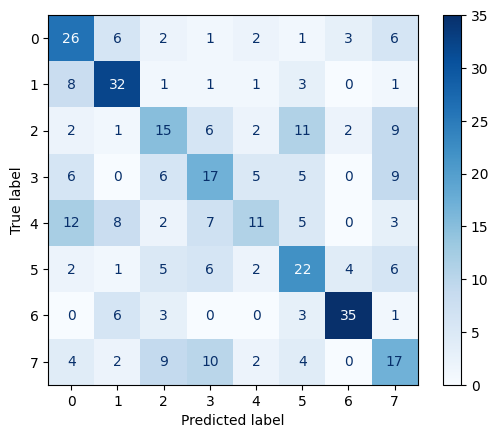

Time elapsed for epoch 153: 0:00:18.211118
Epoch 154/200, Batch 10/42, Loss: 0.9877
Epoch 154/200, Batch 20/42, Loss: 0.9780
Epoch 154/200, Batch 30/42, Loss: 0.9393
Epoch 154/200, Batch 40/42, Loss: 0.9759
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.38      0.42        47
           1       0.53      0.66      0.59        47
           2       0.49      0.38      0.42        48
           3       0.29      0.35      0.32        48
           4       0.33      0.23      0.27        48
           5       0.41      0.62      0.49        48
           6       0.81      0.71      0.76        48
           7       0.32      0.27      0.29        48

    accuracy                           0.45       382
   macro avg       0.46      0.45      0.45       382
weighted avg       0.46      0.45      0.45       382


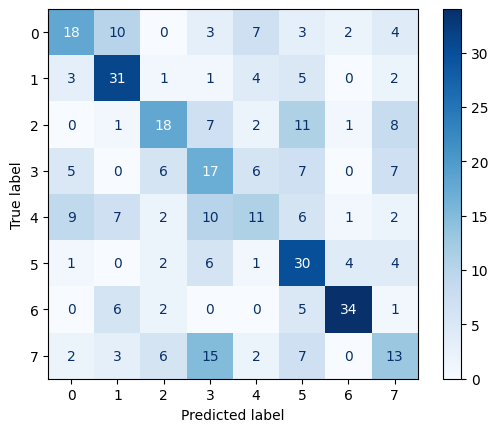

Time elapsed for epoch 154: 0:00:17.948062
Epoch 155/200, Batch 10/42, Loss: 0.8548
Epoch 155/200, Batch 20/42, Loss: 0.8737
Epoch 155/200, Batch 30/42, Loss: 0.9300
Epoch 155/200, Batch 40/42, Loss: 0.9440
Accuracy on images: 44.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        47
           1       0.55      0.57      0.56        47
           2       0.38      0.29      0.33        48
           3       0.34      0.38      0.36        48
           4       0.38      0.25      0.30        48
           5       0.40      0.52      0.45        48
           6       0.72      0.79      0.75        48
           7       0.35      0.40      0.37        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


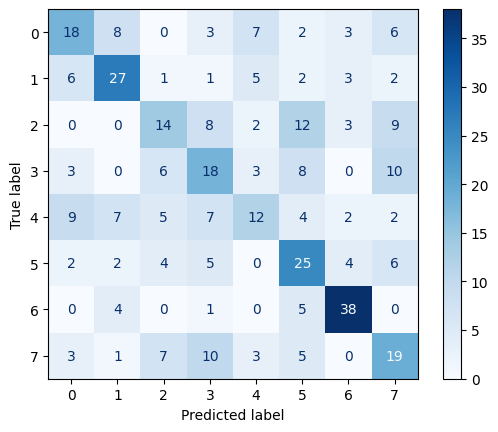

Time elapsed for epoch 155: 0:00:18.285137
Epoch 156/200, Batch 10/42, Loss: 0.9814
Epoch 156/200, Batch 20/42, Loss: 0.9066
Epoch 156/200, Batch 30/42, Loss: 0.7910
Epoch 156/200, Batch 40/42, Loss: 0.9269
Accuracy on images: 47.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.49      0.47        47
           1       0.60      0.72      0.65        47
           2       0.36      0.44      0.40        48
           3       0.38      0.27      0.32        48
           4       0.37      0.23      0.28        48
           5       0.44      0.54      0.49        48
           6       0.82      0.77      0.80        48
           7       0.31      0.31      0.31        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.46       382
weighted avg       0.47      0.47      0.46       382


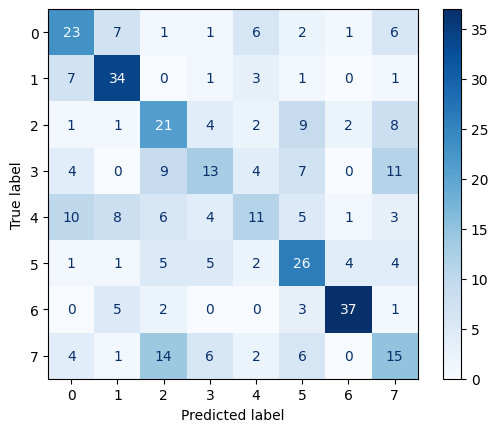

Time elapsed for epoch 156: 0:00:17.995071
Epoch 157/200, Batch 10/42, Loss: 0.8794
Epoch 157/200, Batch 20/42, Loss: 0.8689
Epoch 157/200, Batch 30/42, Loss: 0.8789
Epoch 157/200, Batch 40/42, Loss: 0.9308
Accuracy on images: 45.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.34      0.39        47
           1       0.57      0.68      0.62        47
           2       0.36      0.38      0.37        48
           3       0.38      0.33      0.36        48
           4       0.30      0.17      0.21        48
           5       0.46      0.60      0.52        48
           6       0.68      0.83      0.75        48
           7       0.30      0.31      0.31        48

    accuracy                           0.46       382
   macro avg       0.44      0.46      0.44       382
weighted avg       0.44      0.46      0.44       382


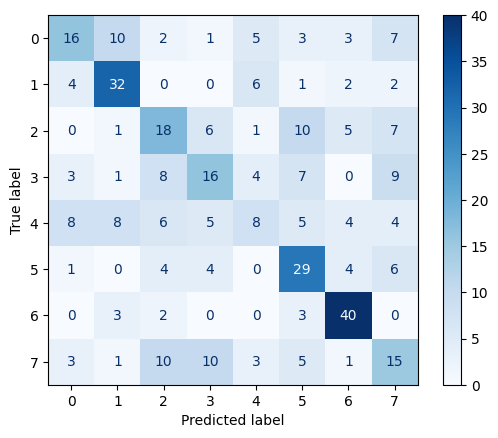

Time elapsed for epoch 157: 0:00:18.567200
Epoch 158/200, Batch 10/42, Loss: 0.8338
Epoch 158/200, Batch 20/42, Loss: 0.8350
Epoch 158/200, Batch 30/42, Loss: 0.8357
Epoch 158/200, Batch 40/42, Loss: 1.0588
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        47
           1       0.52      0.70      0.59        47
           2       0.35      0.35      0.35        48
           3       0.35      0.40      0.37        48
           4       0.42      0.10      0.17        48
           5       0.40      0.65      0.49        48
           6       0.73      0.75      0.74        48
           7       0.36      0.25      0.30        48

    accuracy                           0.45       382
   macro avg       0.45      0.45      0.43       382
weighted avg       0.45      0.45      0.43       382


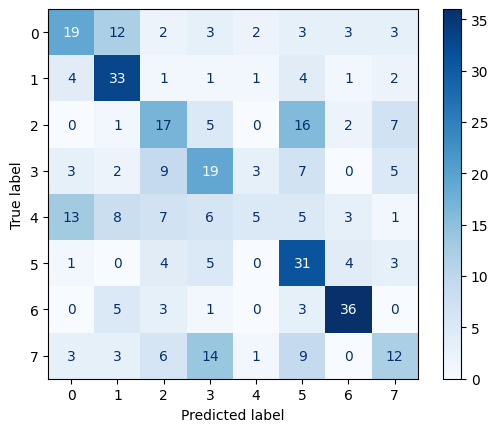

Time elapsed for epoch 158: 0:00:18.794375
Epoch 159/200, Batch 10/42, Loss: 0.8806
Epoch 159/200, Batch 20/42, Loss: 0.8782
Epoch 159/200, Batch 30/42, Loss: 0.8848
Epoch 159/200, Batch 40/42, Loss: 0.8710
Accuracy on images: 46.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46        47
           1       0.56      0.68      0.62        47
           2       0.36      0.31      0.33        48
           3       0.35      0.29      0.32        48
           4       0.42      0.23      0.30        48
           5       0.45      0.56      0.50        48
           6       0.75      0.79      0.77        48
           7       0.31      0.33      0.32        48

    accuracy                           0.46       382
   macro avg       0.45      0.46      0.45       382
weighted avg       0.45      0.46      0.45       382


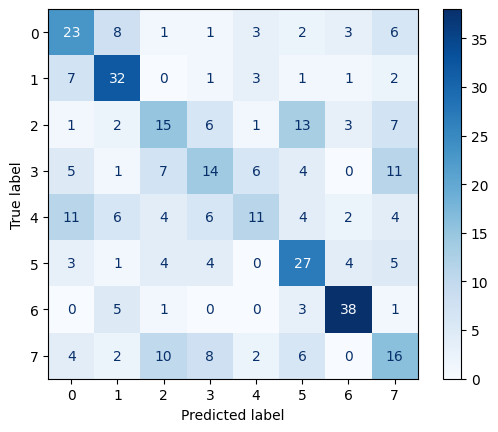

Time elapsed for epoch 159: 0:00:18.316021
Epoch 160/200, Batch 10/42, Loss: 0.8722
Epoch 160/200, Batch 20/42, Loss: 0.9296
Epoch 160/200, Batch 30/42, Loss: 0.7771
Epoch 160/200, Batch 40/42, Loss: 0.9728
Accuracy on images: 46.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.47      0.44        47
           1       0.57      0.72      0.64        47
           2       0.34      0.40      0.37        48
           3       0.41      0.31      0.35        48
           4       0.33      0.23      0.27        48
           5       0.46      0.56      0.50        48
           6       0.76      0.73      0.74        48
           7       0.39      0.31      0.35        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.46       382
weighted avg       0.46      0.47      0.46       382


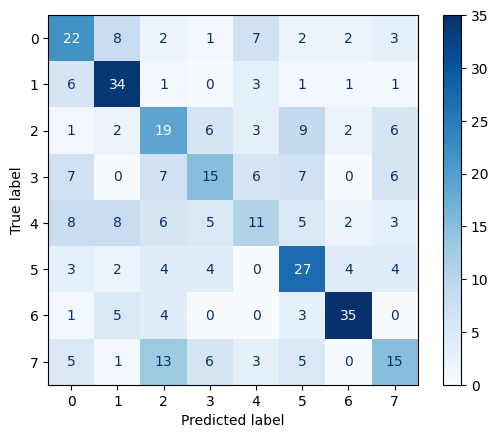

Time elapsed for epoch 160: 0:00:18.502186
Epoch 161/200, Batch 10/42, Loss: 0.9965
Epoch 161/200, Batch 20/42, Loss: 0.8822
Epoch 161/200, Batch 30/42, Loss: 0.8926
Epoch 161/200, Batch 40/42, Loss: 0.9352
Accuracy on images: 47.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.60      0.52        47
           1       0.65      0.70      0.67        47
           2       0.34      0.33      0.34        48
           3       0.41      0.31      0.35        48
           4       0.32      0.12      0.18        48
           5       0.45      0.52      0.49        48
           6       0.66      0.73      0.69        48
           7       0.37      0.46      0.41        48

    accuracy                           0.47       382
   macro avg       0.46      0.47      0.46       382
weighted avg       0.46      0.47      0.46       382


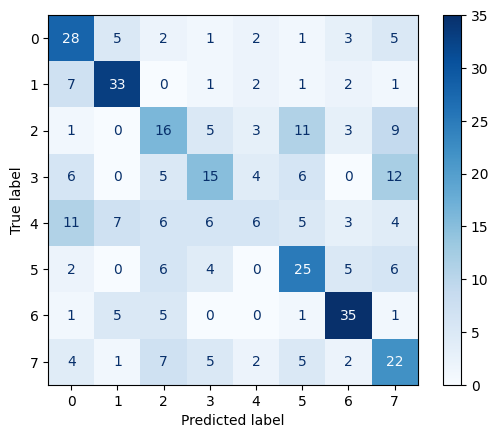

Time elapsed for epoch 161: 0:00:18.396163
Epoch 162/200, Batch 10/42, Loss: 0.8868
Epoch 162/200, Batch 20/42, Loss: 0.9599
Epoch 162/200, Batch 30/42, Loss: 0.9787
Epoch 162/200, Batch 40/42, Loss: 0.9265
Accuracy on images: 45.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.38      0.40        47
           1       0.50      0.77      0.61        47
           2       0.31      0.33      0.32        48
           3       0.34      0.29      0.31        48
           4       0.31      0.19      0.23        48
           5       0.51      0.60      0.55        48
           6       0.83      0.71      0.76        48
           7       0.33      0.33      0.33        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


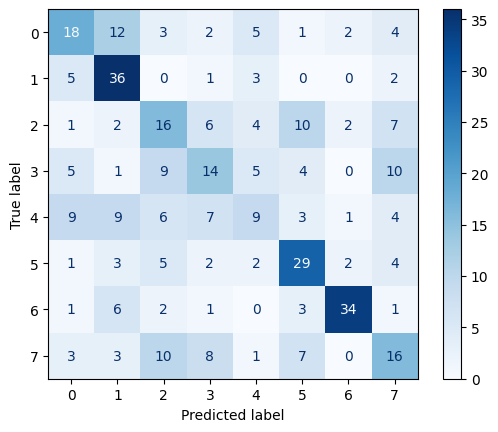

Time elapsed for epoch 162: 0:00:18.429170
Epoch 163/200, Batch 10/42, Loss: 0.8951
Epoch 163/200, Batch 20/42, Loss: 0.8559
Epoch 163/200, Batch 30/42, Loss: 0.9026
Epoch 163/200, Batch 40/42, Loss: 0.9260
Accuracy on images: 45.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.40      0.41        47
           1       0.59      0.57      0.58        47
           2       0.43      0.31      0.36        48
           3       0.35      0.40      0.37        48
           4       0.25      0.17      0.20        48
           5       0.46      0.54      0.50        48
           6       0.71      0.83      0.77        48
           7       0.35      0.40      0.37        48

    accuracy                           0.45       382
   macro avg       0.44      0.45      0.44       382
weighted avg       0.44      0.45      0.44       382


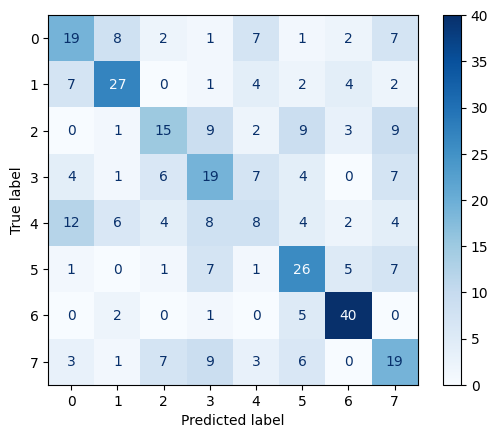

Time elapsed for epoch 163: 0:00:18.208120
Epoch 164/200, Batch 10/42, Loss: 0.9168
Epoch 164/200, Batch 20/42, Loss: 0.8836
Epoch 164/200, Batch 30/42, Loss: 0.9389
Epoch 164/200, Batch 40/42, Loss: 0.9609
Accuracy on images: 47.64%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.60      0.50        47
           1       0.60      0.74      0.67        47
           2       0.35      0.31      0.33        48
           3       0.31      0.29      0.30        48
           4       0.41      0.19      0.26        48
           5       0.46      0.56      0.50        48
           6       0.82      0.75      0.78        48
           7       0.38      0.38      0.38        48

    accuracy                           0.48       382
   macro avg       0.47      0.48      0.47       382
weighted avg       0.47      0.48      0.47       382


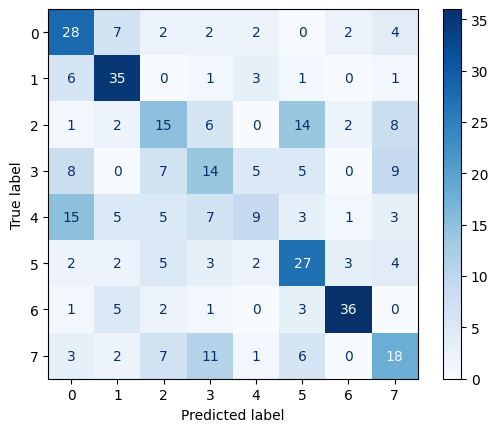

Time elapsed for epoch 164: 0:00:18.640215
Epoch 165/200, Batch 10/42, Loss: 0.8722
Epoch 165/200, Batch 20/42, Loss: 0.8216
Epoch 165/200, Batch 30/42, Loss: 0.8737
Epoch 165/200, Batch 40/42, Loss: 0.8716
Accuracy on images: 47.91%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        47
           1       0.55      0.68      0.61        47
           2       0.42      0.44      0.43        48
           3       0.35      0.35      0.35        48
           4       0.32      0.21      0.25        48
           5       0.48      0.60      0.53        48
           6       0.73      0.79      0.76        48
           7       0.44      0.38      0.40        48

    accuracy                           0.48       382
   macro avg       0.47      0.48      0.47       382
weighted avg       0.47      0.48      0.47       382


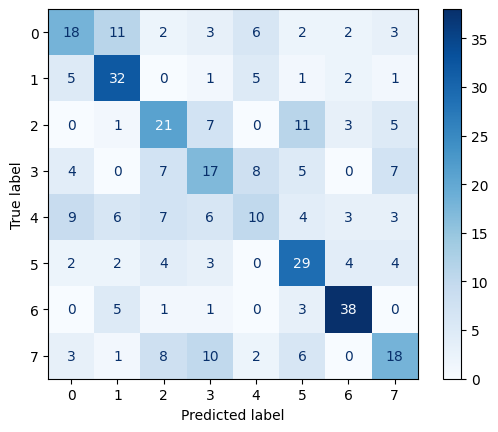

Time elapsed for epoch 165: 0:00:17.888048
Epoch 166/200, Batch 10/42, Loss: 0.7290
Epoch 166/200, Batch 20/42, Loss: 0.9206
Epoch 166/200, Batch 30/42, Loss: 0.8899
Epoch 166/200, Batch 40/42, Loss: 0.9048
Accuracy on images: 46.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.49      0.47        47
           1       0.52      0.68      0.59        47
           2       0.34      0.40      0.37        48
           3       0.40      0.40      0.40        48
           4       0.36      0.17      0.23        48
           5       0.46      0.65      0.53        48
           6       0.79      0.65      0.71        48
           7       0.38      0.31      0.34        48

    accuracy                           0.47       382
   macro avg       0.47      0.47      0.46       382
weighted avg       0.47      0.47      0.46       382


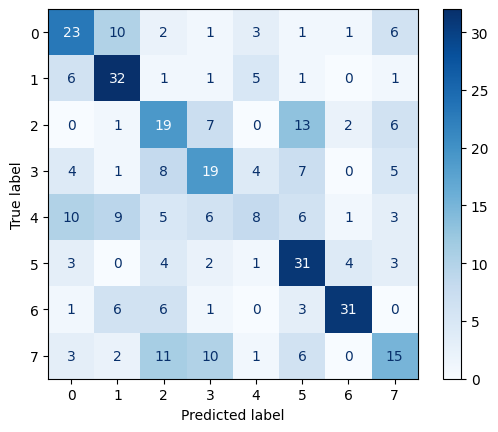

Time elapsed for epoch 166: 0:00:18.980294
Epoch 167/200, Batch 10/42, Loss: 0.8554


In [ ]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 200

train_loop(model, train_loader, optimizer, criterion, num_epochs, device)

## Conclusión
